# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [42]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████████████████████████████████████| 60.0K/60.0K [01:38<00:00, 606File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

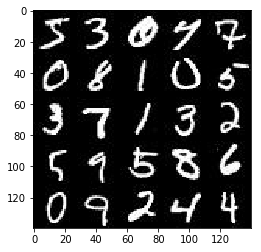

In [43]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

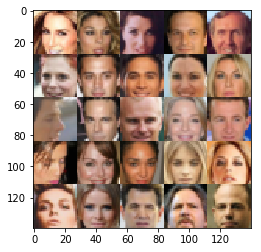

In [44]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [46]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return tf.placeholder(tf.float32, shape=([None, image_width, image_height, image_channels]), name='input_real'), \
                tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z'), \
                tf.placeholder(tf.float32, shape=None, name='learning_rate')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [70]:
keep_prob = 0.8

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):       
        # Input layer is 28x28x3
        # https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(batch_norm2)
# Discriminator should be smaller model than generator
#         x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         batch_norm3 = tf.layers.batch_normalization(x3, training=True)
#         relu3 = leaky_relu(batch_norm3)
        #add drop out 
        drop2 = tf.nn.dropout(relu2, keep_prob)

        # Flatten
        flat = tf.reshape(drop2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.nn.dropout(logits, keep_prob)
        out = tf.sigmoid(logits)
    return out, logits


def leaky_relu(node, alpha=0.01, name='leaky_relu'):
    return tf.maximum(alpha * node, node, name=name)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):

        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.nn.dropout(x1, keep_prob) # add drop out
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
            
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_o = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
       g_train_o = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)    
    
    return d_train_o, g_train_o


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # The inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                z_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: z_noise})
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise})
                steps += 1

                train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: z_noise})
                train_loss_g = g_loss.eval({input_z: z_noise})

                if steps % 10 == 0:
                    print("Epoch {}/{}: steps {}".format(epoch_i+1, epochs, steps),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)                   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5: steps 10 Discriminator Loss: 1.2844... Generator Loss: 0.6878
Epoch 1/5: steps 20 Discriminator Loss: 1.3078... Generator Loss: 0.8317
Epoch 1/5: steps 30 Discriminator Loss: 0.8799... Generator Loss: 1.2109
Epoch 1/5: steps 40 Discriminator Loss: 1.1637... Generator Loss: 0.7993
Epoch 1/5: steps 50 Discriminator Loss: 0.9290... Generator Loss: 1.0208
Epoch 1/5: steps 60 Discriminator Loss: 0.9290... Generator Loss: 1.1219
Epoch 1/5: steps 70 Discriminator Loss: 1.3494... Generator Loss: 0.8403
Epoch 1/5: steps 80 Discriminator Loss: 1.3122... Generator Loss: 0.7262
Epoch 1/5: steps 90 Discriminator Loss: 1.2294... Generator Loss: 0.7808
Epoch 1/5: steps 100 Discriminator Loss: 1.2077... Generator Loss: 0.8382


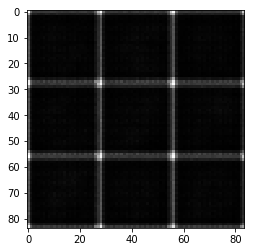

Epoch 1/5: steps 110 Discriminator Loss: 1.2874... Generator Loss: 0.8538
Epoch 1/5: steps 120 Discriminator Loss: 1.1600... Generator Loss: 0.7594
Epoch 1/5: steps 130 Discriminator Loss: 1.2797... Generator Loss: 0.7129
Epoch 1/5: steps 140 Discriminator Loss: 1.2119... Generator Loss: 0.7944
Epoch 1/5: steps 150 Discriminator Loss: 1.1741... Generator Loss: 0.9199
Epoch 1/5: steps 160 Discriminator Loss: 1.2822... Generator Loss: 0.8651
Epoch 1/5: steps 170 Discriminator Loss: 1.2700... Generator Loss: 0.8286
Epoch 1/5: steps 180 Discriminator Loss: 1.1507... Generator Loss: 0.9799
Epoch 1/5: steps 190 Discriminator Loss: 1.2797... Generator Loss: 0.8113
Epoch 1/5: steps 200 Discriminator Loss: 1.2025... Generator Loss: 0.8467


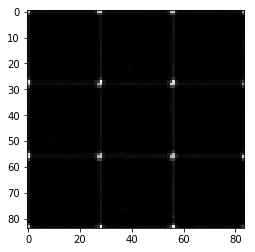

Epoch 1/5: steps 210 Discriminator Loss: 1.2619... Generator Loss: 0.8831
Epoch 1/5: steps 220 Discriminator Loss: 1.3465... Generator Loss: 0.7986
Epoch 1/5: steps 230 Discriminator Loss: 1.3250... Generator Loss: 0.8387
Epoch 1/5: steps 240 Discriminator Loss: 1.2980... Generator Loss: 0.8028
Epoch 1/5: steps 250 Discriminator Loss: 1.2577... Generator Loss: 0.7646
Epoch 1/5: steps 260 Discriminator Loss: 1.2713... Generator Loss: 0.9242
Epoch 1/5: steps 270 Discriminator Loss: 1.3119... Generator Loss: 0.7220
Epoch 1/5: steps 280 Discriminator Loss: 1.2589... Generator Loss: 0.7767
Epoch 1/5: steps 290 Discriminator Loss: 1.2631... Generator Loss: 0.8329
Epoch 1/5: steps 300 Discriminator Loss: 1.2358... Generator Loss: 0.8531


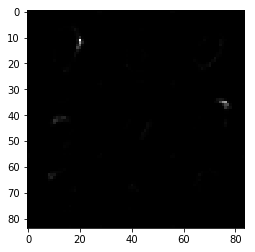

Epoch 1/5: steps 310 Discriminator Loss: 1.2274... Generator Loss: 0.7437
Epoch 1/5: steps 320 Discriminator Loss: 1.2999... Generator Loss: 0.7945
Epoch 1/5: steps 330 Discriminator Loss: 1.2673... Generator Loss: 0.9083
Epoch 1/5: steps 340 Discriminator Loss: 1.3479... Generator Loss: 0.7933
Epoch 1/5: steps 350 Discriminator Loss: 1.2532... Generator Loss: 0.9143
Epoch 1/5: steps 360 Discriminator Loss: 1.2490... Generator Loss: 0.9042
Epoch 1/5: steps 370 Discriminator Loss: 1.3252... Generator Loss: 0.8447
Epoch 1/5: steps 380 Discriminator Loss: 1.1634... Generator Loss: 0.8080
Epoch 1/5: steps 390 Discriminator Loss: 1.3041... Generator Loss: 0.7611
Epoch 1/5: steps 400 Discriminator Loss: 1.2345... Generator Loss: 0.8441


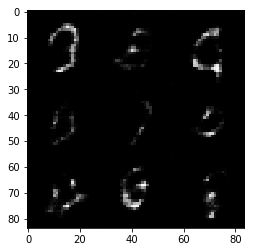

Epoch 1/5: steps 410 Discriminator Loss: 1.2543... Generator Loss: 0.7493
Epoch 1/5: steps 420 Discriminator Loss: 1.2539... Generator Loss: 0.8263
Epoch 1/5: steps 430 Discriminator Loss: 1.3030... Generator Loss: 0.8390
Epoch 1/5: steps 440 Discriminator Loss: 1.2808... Generator Loss: 0.8310
Epoch 1/5: steps 450 Discriminator Loss: 1.1767... Generator Loss: 0.8756
Epoch 1/5: steps 460 Discriminator Loss: 1.2978... Generator Loss: 0.6877
Epoch 1/5: steps 470 Discriminator Loss: 1.2928... Generator Loss: 0.8425
Epoch 1/5: steps 480 Discriminator Loss: 1.1908... Generator Loss: 0.8765
Epoch 1/5: steps 490 Discriminator Loss: 1.2481... Generator Loss: 0.7307
Epoch 1/5: steps 500 Discriminator Loss: 1.2545... Generator Loss: 0.8466


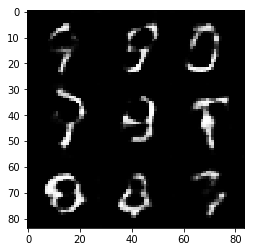

Epoch 1/5: steps 510 Discriminator Loss: 1.1568... Generator Loss: 0.8647
Epoch 1/5: steps 520 Discriminator Loss: 1.3049... Generator Loss: 0.7341
Epoch 1/5: steps 530 Discriminator Loss: 1.2721... Generator Loss: 0.7575
Epoch 1/5: steps 540 Discriminator Loss: 1.1860... Generator Loss: 0.8390
Epoch 1/5: steps 550 Discriminator Loss: 1.2304... Generator Loss: 0.7792
Epoch 1/5: steps 560 Discriminator Loss: 1.2981... Generator Loss: 0.8205
Epoch 1/5: steps 570 Discriminator Loss: 1.2342... Generator Loss: 0.8837
Epoch 1/5: steps 580 Discriminator Loss: 1.2734... Generator Loss: 0.7386
Epoch 1/5: steps 590 Discriminator Loss: 1.1757... Generator Loss: 0.8840
Epoch 1/5: steps 600 Discriminator Loss: 1.2912... Generator Loss: 0.8048


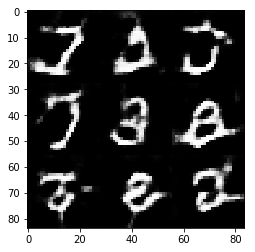

Epoch 1/5: steps 610 Discriminator Loss: 1.2488... Generator Loss: 0.8480
Epoch 1/5: steps 620 Discriminator Loss: 1.2181... Generator Loss: 0.7336
Epoch 1/5: steps 630 Discriminator Loss: 1.1605... Generator Loss: 0.8206
Epoch 1/5: steps 640 Discriminator Loss: 1.2222... Generator Loss: 0.8090
Epoch 1/5: steps 650 Discriminator Loss: 1.3474... Generator Loss: 0.8090
Epoch 1/5: steps 660 Discriminator Loss: 1.1782... Generator Loss: 1.0533
Epoch 1/5: steps 670 Discriminator Loss: 1.2942... Generator Loss: 0.8093
Epoch 1/5: steps 680 Discriminator Loss: 1.2199... Generator Loss: 0.7276
Epoch 1/5: steps 690 Discriminator Loss: 1.2940... Generator Loss: 0.9284
Epoch 1/5: steps 700 Discriminator Loss: 1.2376... Generator Loss: 0.8444


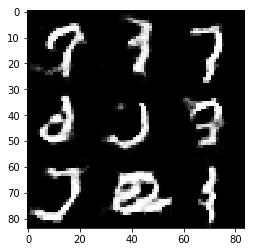

Epoch 1/5: steps 710 Discriminator Loss: 1.2697... Generator Loss: 0.9803
Epoch 1/5: steps 720 Discriminator Loss: 1.3541... Generator Loss: 0.7483
Epoch 1/5: steps 730 Discriminator Loss: 1.2649... Generator Loss: 0.7835
Epoch 1/5: steps 740 Discriminator Loss: 1.2694... Generator Loss: 0.8413
Epoch 1/5: steps 750 Discriminator Loss: 1.1136... Generator Loss: 0.8834
Epoch 1/5: steps 760 Discriminator Loss: 1.1691... Generator Loss: 0.8551
Epoch 1/5: steps 770 Discriminator Loss: 1.1809... Generator Loss: 0.8820
Epoch 1/5: steps 780 Discriminator Loss: 1.3004... Generator Loss: 0.7246
Epoch 1/5: steps 790 Discriminator Loss: 1.3070... Generator Loss: 1.0823
Epoch 1/5: steps 800 Discriminator Loss: 1.2191... Generator Loss: 0.8287


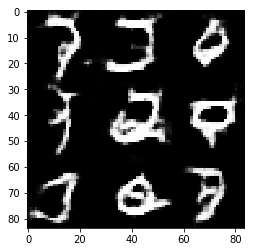

Epoch 1/5: steps 810 Discriminator Loss: 1.2343... Generator Loss: 0.8341
Epoch 1/5: steps 820 Discriminator Loss: 1.2276... Generator Loss: 0.8424
Epoch 1/5: steps 830 Discriminator Loss: 1.1768... Generator Loss: 0.9659
Epoch 1/5: steps 840 Discriminator Loss: 1.2262... Generator Loss: 0.7477
Epoch 1/5: steps 850 Discriminator Loss: 1.1730... Generator Loss: 1.0589
Epoch 1/5: steps 860 Discriminator Loss: 1.4110... Generator Loss: 0.7671
Epoch 1/5: steps 870 Discriminator Loss: 1.3144... Generator Loss: 0.6294
Epoch 1/5: steps 880 Discriminator Loss: 1.0775... Generator Loss: 0.9440
Epoch 1/5: steps 890 Discriminator Loss: 1.2320... Generator Loss: 0.9406
Epoch 1/5: steps 900 Discriminator Loss: 1.2186... Generator Loss: 0.9377


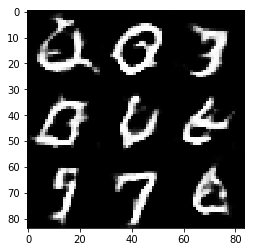

Epoch 1/5: steps 910 Discriminator Loss: 1.2046... Generator Loss: 0.9343
Epoch 1/5: steps 920 Discriminator Loss: 1.0803... Generator Loss: 1.0031
Epoch 1/5: steps 930 Discriminator Loss: 1.2675... Generator Loss: 0.8125
Epoch 2/5: steps 10 Discriminator Loss: 1.1133... Generator Loss: 1.0187
Epoch 2/5: steps 20 Discriminator Loss: 1.2889... Generator Loss: 0.8226
Epoch 2/5: steps 30 Discriminator Loss: 1.2406... Generator Loss: 0.9133
Epoch 2/5: steps 40 Discriminator Loss: 1.2390... Generator Loss: 0.8919
Epoch 2/5: steps 50 Discriminator Loss: 1.2926... Generator Loss: 0.6769
Epoch 2/5: steps 60 Discriminator Loss: 1.2700... Generator Loss: 0.7776
Epoch 2/5: steps 70 Discriminator Loss: 1.2484... Generator Loss: 0.7927
Epoch 2/5: steps 80 Discriminator Loss: 1.1916... Generator Loss: 0.8733
Epoch 2/5: steps 90 Discriminator Loss: 1.3121... Generator Loss: 0.9195
Epoch 2/5: steps 100 Discriminator Loss: 1.2241... Generator Loss: 0.7955


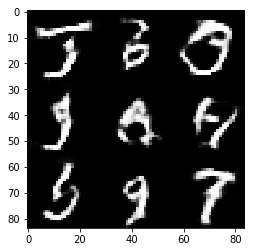

Epoch 2/5: steps 110 Discriminator Loss: 1.1687... Generator Loss: 0.9235
Epoch 2/5: steps 120 Discriminator Loss: 1.2058... Generator Loss: 0.9633
Epoch 2/5: steps 130 Discriminator Loss: 1.1504... Generator Loss: 0.8732
Epoch 2/5: steps 140 Discriminator Loss: 1.1883... Generator Loss: 0.7758
Epoch 2/5: steps 150 Discriminator Loss: 1.2830... Generator Loss: 0.9498
Epoch 2/5: steps 160 Discriminator Loss: 1.1997... Generator Loss: 1.0314
Epoch 2/5: steps 170 Discriminator Loss: 1.2510... Generator Loss: 0.8301
Epoch 2/5: steps 180 Discriminator Loss: 1.2759... Generator Loss: 0.8338
Epoch 2/5: steps 190 Discriminator Loss: 1.1259... Generator Loss: 1.0272
Epoch 2/5: steps 200 Discriminator Loss: 1.2589... Generator Loss: 0.7849


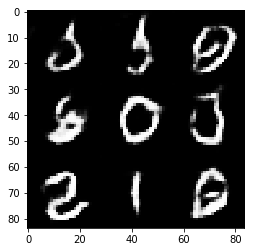

Epoch 2/5: steps 210 Discriminator Loss: 1.3010... Generator Loss: 0.8639
Epoch 2/5: steps 220 Discriminator Loss: 1.1656... Generator Loss: 0.7372
Epoch 2/5: steps 230 Discriminator Loss: 1.2918... Generator Loss: 0.7841
Epoch 2/5: steps 240 Discriminator Loss: 1.1699... Generator Loss: 0.8919
Epoch 2/5: steps 250 Discriminator Loss: 1.1319... Generator Loss: 0.7960
Epoch 2/5: steps 260 Discriminator Loss: 1.2218... Generator Loss: 0.8850
Epoch 2/5: steps 270 Discriminator Loss: 1.2357... Generator Loss: 0.9052
Epoch 2/5: steps 280 Discriminator Loss: 1.3313... Generator Loss: 0.9154
Epoch 2/5: steps 290 Discriminator Loss: 1.2003... Generator Loss: 0.7375
Epoch 2/5: steps 300 Discriminator Loss: 1.3739... Generator Loss: 0.6966


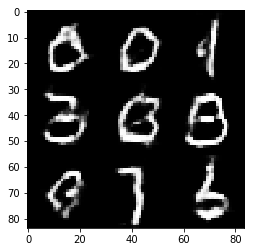

Epoch 2/5: steps 310 Discriminator Loss: 1.2067... Generator Loss: 0.7964
Epoch 2/5: steps 320 Discriminator Loss: 1.2370... Generator Loss: 0.9637
Epoch 2/5: steps 330 Discriminator Loss: 1.2523... Generator Loss: 0.8030
Epoch 2/5: steps 340 Discriminator Loss: 1.1403... Generator Loss: 0.8943
Epoch 2/5: steps 350 Discriminator Loss: 1.1466... Generator Loss: 1.1078
Epoch 2/5: steps 360 Discriminator Loss: 1.0898... Generator Loss: 0.7974
Epoch 2/5: steps 370 Discriminator Loss: 1.1565... Generator Loss: 0.8604
Epoch 2/5: steps 380 Discriminator Loss: 1.1297... Generator Loss: 0.9245
Epoch 2/5: steps 390 Discriminator Loss: 1.1584... Generator Loss: 0.8539
Epoch 2/5: steps 400 Discriminator Loss: 1.2110... Generator Loss: 0.7236


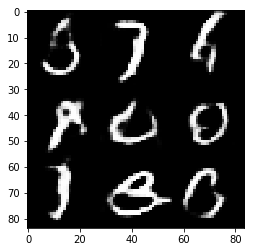

Epoch 2/5: steps 410 Discriminator Loss: 1.1956... Generator Loss: 0.9078
Epoch 2/5: steps 420 Discriminator Loss: 1.1601... Generator Loss: 0.9825
Epoch 2/5: steps 430 Discriminator Loss: 1.1469... Generator Loss: 0.8390
Epoch 2/5: steps 440 Discriminator Loss: 1.2028... Generator Loss: 0.7621
Epoch 2/5: steps 450 Discriminator Loss: 1.1308... Generator Loss: 1.1259
Epoch 2/5: steps 460 Discriminator Loss: 1.2825... Generator Loss: 0.6864
Epoch 2/5: steps 470 Discriminator Loss: 1.2508... Generator Loss: 0.8449
Epoch 2/5: steps 480 Discriminator Loss: 1.1635... Generator Loss: 1.2161
Epoch 2/5: steps 490 Discriminator Loss: 1.1632... Generator Loss: 0.8359
Epoch 2/5: steps 500 Discriminator Loss: 1.1356... Generator Loss: 0.8271


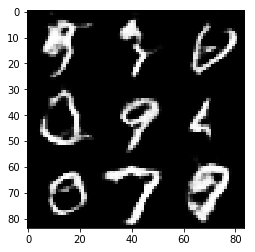

Epoch 2/5: steps 510 Discriminator Loss: 1.2166... Generator Loss: 0.8132
Epoch 2/5: steps 520 Discriminator Loss: 1.3777... Generator Loss: 0.5143
Epoch 2/5: steps 530 Discriminator Loss: 1.1912... Generator Loss: 0.9373
Epoch 2/5: steps 540 Discriminator Loss: 1.1317... Generator Loss: 0.8928
Epoch 2/5: steps 550 Discriminator Loss: 1.0903... Generator Loss: 0.8779
Epoch 2/5: steps 560 Discriminator Loss: 1.2586... Generator Loss: 0.9293
Epoch 2/5: steps 570 Discriminator Loss: 1.1946... Generator Loss: 0.7707
Epoch 2/5: steps 580 Discriminator Loss: 1.1504... Generator Loss: 0.7626
Epoch 2/5: steps 590 Discriminator Loss: 1.1679... Generator Loss: 0.8072
Epoch 2/5: steps 600 Discriminator Loss: 1.1627... Generator Loss: 0.9840


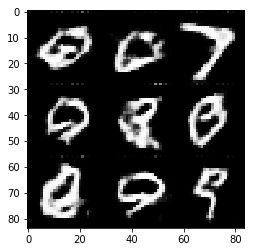

Epoch 2/5: steps 610 Discriminator Loss: 1.2403... Generator Loss: 0.7956
Epoch 2/5: steps 620 Discriminator Loss: 1.2537... Generator Loss: 0.7393
Epoch 2/5: steps 630 Discriminator Loss: 1.0791... Generator Loss: 0.8394
Epoch 2/5: steps 640 Discriminator Loss: 1.1845... Generator Loss: 0.9937
Epoch 2/5: steps 650 Discriminator Loss: 1.1111... Generator Loss: 0.9444
Epoch 2/5: steps 660 Discriminator Loss: 1.1406... Generator Loss: 1.1737
Epoch 2/5: steps 670 Discriminator Loss: 1.1643... Generator Loss: 0.8496
Epoch 2/5: steps 680 Discriminator Loss: 1.2285... Generator Loss: 0.7843
Epoch 2/5: steps 690 Discriminator Loss: 1.1275... Generator Loss: 0.8521
Epoch 2/5: steps 700 Discriminator Loss: 1.1457... Generator Loss: 1.0025


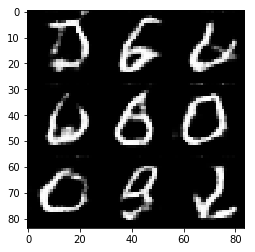

Epoch 2/5: steps 710 Discriminator Loss: 1.1901... Generator Loss: 0.9648
Epoch 2/5: steps 720 Discriminator Loss: 1.2026... Generator Loss: 0.8710
Epoch 2/5: steps 730 Discriminator Loss: 1.1989... Generator Loss: 0.9458
Epoch 2/5: steps 740 Discriminator Loss: 1.1409... Generator Loss: 1.0180
Epoch 2/5: steps 750 Discriminator Loss: 1.0528... Generator Loss: 0.9536
Epoch 2/5: steps 760 Discriminator Loss: 1.0765... Generator Loss: 1.0824
Epoch 2/5: steps 770 Discriminator Loss: 1.1083... Generator Loss: 1.0588
Epoch 2/5: steps 780 Discriminator Loss: 1.2255... Generator Loss: 0.9277
Epoch 2/5: steps 790 Discriminator Loss: 1.2479... Generator Loss: 0.9360
Epoch 2/5: steps 800 Discriminator Loss: 1.1908... Generator Loss: 1.0876


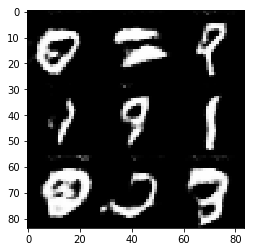

Epoch 2/5: steps 810 Discriminator Loss: 1.1021... Generator Loss: 1.0496
Epoch 2/5: steps 820 Discriminator Loss: 1.0872... Generator Loss: 0.9967
Epoch 2/5: steps 830 Discriminator Loss: 1.0383... Generator Loss: 1.0628
Epoch 2/5: steps 840 Discriminator Loss: 1.2492... Generator Loss: 1.1468
Epoch 2/5: steps 850 Discriminator Loss: 1.3290... Generator Loss: 1.1201
Epoch 2/5: steps 860 Discriminator Loss: 1.3254... Generator Loss: 0.8299
Epoch 2/5: steps 870 Discriminator Loss: 1.2897... Generator Loss: 0.8039
Epoch 2/5: steps 880 Discriminator Loss: 1.1686... Generator Loss: 1.1550
Epoch 2/5: steps 890 Discriminator Loss: 1.0824... Generator Loss: 0.9177
Epoch 2/5: steps 900 Discriminator Loss: 1.1245... Generator Loss: 1.1926


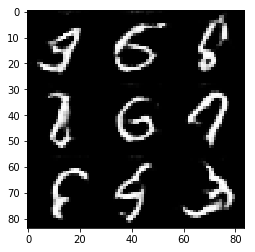

Epoch 2/5: steps 910 Discriminator Loss: 1.1089... Generator Loss: 0.9830
Epoch 2/5: steps 920 Discriminator Loss: 1.1377... Generator Loss: 0.8804
Epoch 2/5: steps 930 Discriminator Loss: 1.1704... Generator Loss: 0.9996
Epoch 3/5: steps 10 Discriminator Loss: 1.0824... Generator Loss: 0.9476
Epoch 3/5: steps 20 Discriminator Loss: 1.1747... Generator Loss: 0.9415
Epoch 3/5: steps 30 Discriminator Loss: 1.1074... Generator Loss: 0.9826
Epoch 3/5: steps 40 Discriminator Loss: 1.2068... Generator Loss: 1.1808
Epoch 3/5: steps 50 Discriminator Loss: 1.1110... Generator Loss: 1.2321
Epoch 3/5: steps 60 Discriminator Loss: 1.1752... Generator Loss: 0.9098
Epoch 3/5: steps 70 Discriminator Loss: 1.1424... Generator Loss: 0.9645
Epoch 3/5: steps 80 Discriminator Loss: 0.9897... Generator Loss: 0.9774
Epoch 3/5: steps 90 Discriminator Loss: 1.1561... Generator Loss: 1.0282
Epoch 3/5: steps 100 Discriminator Loss: 1.0313... Generator Loss: 0.9675


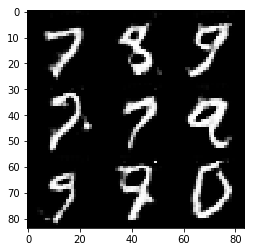

Epoch 3/5: steps 110 Discriminator Loss: 1.1949... Generator Loss: 1.1827
Epoch 3/5: steps 120 Discriminator Loss: 1.1211... Generator Loss: 1.2741
Epoch 3/5: steps 130 Discriminator Loss: 1.1136... Generator Loss: 1.1569
Epoch 3/5: steps 140 Discriminator Loss: 1.1301... Generator Loss: 0.8874
Epoch 3/5: steps 150 Discriminator Loss: 1.2102... Generator Loss: 1.0660
Epoch 3/5: steps 160 Discriminator Loss: 1.0903... Generator Loss: 0.7970
Epoch 3/5: steps 170 Discriminator Loss: 1.1618... Generator Loss: 0.9957
Epoch 3/5: steps 180 Discriminator Loss: 1.1033... Generator Loss: 0.9430
Epoch 3/5: steps 190 Discriminator Loss: 1.1485... Generator Loss: 1.0192
Epoch 3/5: steps 200 Discriminator Loss: 1.1231... Generator Loss: 1.0813


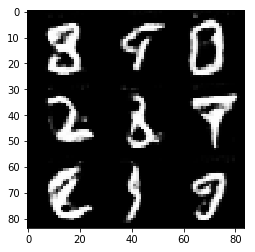

Epoch 3/5: steps 210 Discriminator Loss: 1.0710... Generator Loss: 1.1449
Epoch 3/5: steps 220 Discriminator Loss: 1.1786... Generator Loss: 1.1465
Epoch 3/5: steps 230 Discriminator Loss: 1.0932... Generator Loss: 0.9541
Epoch 3/5: steps 240 Discriminator Loss: 1.1963... Generator Loss: 0.8535
Epoch 3/5: steps 250 Discriminator Loss: 0.9933... Generator Loss: 0.9212
Epoch 3/5: steps 260 Discriminator Loss: 1.0852... Generator Loss: 0.9615
Epoch 3/5: steps 270 Discriminator Loss: 1.0883... Generator Loss: 0.8833
Epoch 3/5: steps 280 Discriminator Loss: 1.1968... Generator Loss: 0.9232
Epoch 3/5: steps 290 Discriminator Loss: 1.0590... Generator Loss: 0.9229
Epoch 3/5: steps 300 Discriminator Loss: 1.1741... Generator Loss: 1.0500


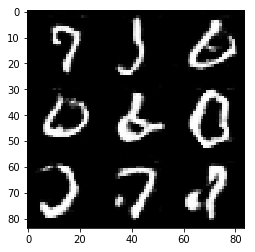

Epoch 3/5: steps 310 Discriminator Loss: 1.0024... Generator Loss: 0.9280
Epoch 3/5: steps 320 Discriminator Loss: 1.1801... Generator Loss: 0.9338
Epoch 3/5: steps 330 Discriminator Loss: 1.0420... Generator Loss: 1.0992
Epoch 3/5: steps 340 Discriminator Loss: 1.2739... Generator Loss: 0.8169
Epoch 3/5: steps 350 Discriminator Loss: 1.1331... Generator Loss: 0.9162
Epoch 3/5: steps 360 Discriminator Loss: 1.1395... Generator Loss: 1.2103
Epoch 3/5: steps 370 Discriminator Loss: 1.1556... Generator Loss: 0.8400
Epoch 3/5: steps 380 Discriminator Loss: 0.9887... Generator Loss: 1.0678
Epoch 3/5: steps 390 Discriminator Loss: 1.0575... Generator Loss: 1.0362
Epoch 3/5: steps 400 Discriminator Loss: 1.2896... Generator Loss: 1.1585


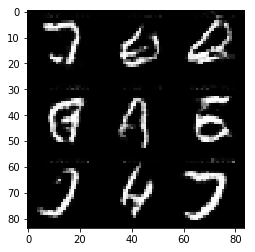

Epoch 3/5: steps 410 Discriminator Loss: 1.1524... Generator Loss: 1.0965
Epoch 3/5: steps 420 Discriminator Loss: 1.1274... Generator Loss: 0.8947
Epoch 3/5: steps 430 Discriminator Loss: 1.1335... Generator Loss: 0.8812
Epoch 3/5: steps 440 Discriminator Loss: 1.0753... Generator Loss: 0.9027
Epoch 3/5: steps 450 Discriminator Loss: 1.1647... Generator Loss: 0.9080
Epoch 3/5: steps 460 Discriminator Loss: 1.3402... Generator Loss: 0.7208
Epoch 3/5: steps 470 Discriminator Loss: 1.2214... Generator Loss: 0.7480
Epoch 3/5: steps 480 Discriminator Loss: 0.9936... Generator Loss: 1.0003
Epoch 3/5: steps 490 Discriminator Loss: 1.1798... Generator Loss: 0.9804
Epoch 3/5: steps 500 Discriminator Loss: 1.1176... Generator Loss: 0.9313


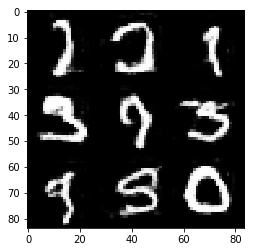

Epoch 3/5: steps 510 Discriminator Loss: 1.1904... Generator Loss: 0.8210
Epoch 3/5: steps 520 Discriminator Loss: 1.1656... Generator Loss: 0.8182
Epoch 3/5: steps 530 Discriminator Loss: 1.1549... Generator Loss: 0.7947
Epoch 3/5: steps 540 Discriminator Loss: 1.1369... Generator Loss: 0.8302
Epoch 3/5: steps 550 Discriminator Loss: 1.0583... Generator Loss: 0.8786
Epoch 3/5: steps 560 Discriminator Loss: 1.2601... Generator Loss: 0.7834
Epoch 3/5: steps 570 Discriminator Loss: 1.1114... Generator Loss: 0.8959
Epoch 3/5: steps 580 Discriminator Loss: 1.1913... Generator Loss: 0.9916
Epoch 3/5: steps 590 Discriminator Loss: 1.1257... Generator Loss: 0.9839
Epoch 3/5: steps 600 Discriminator Loss: 1.2302... Generator Loss: 0.9458


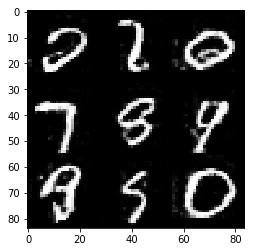

Epoch 3/5: steps 610 Discriminator Loss: 1.1233... Generator Loss: 0.8184
Epoch 3/5: steps 620 Discriminator Loss: 1.1445... Generator Loss: 0.9761
Epoch 3/5: steps 630 Discriminator Loss: 1.1214... Generator Loss: 0.9901
Epoch 3/5: steps 640 Discriminator Loss: 1.1728... Generator Loss: 0.7670
Epoch 3/5: steps 650 Discriminator Loss: 1.3135... Generator Loss: 0.8976
Epoch 3/5: steps 660 Discriminator Loss: 1.1749... Generator Loss: 0.7828
Epoch 3/5: steps 670 Discriminator Loss: 1.2182... Generator Loss: 0.6957
Epoch 3/5: steps 680 Discriminator Loss: 1.3137... Generator Loss: 0.7571
Epoch 3/5: steps 690 Discriminator Loss: 1.2153... Generator Loss: 0.9126
Epoch 3/5: steps 700 Discriminator Loss: 1.1935... Generator Loss: 0.9661


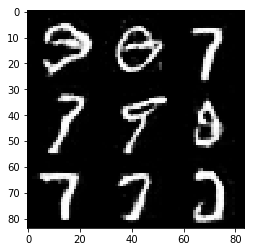

Epoch 3/5: steps 710 Discriminator Loss: 1.3020... Generator Loss: 0.6913
Epoch 3/5: steps 720 Discriminator Loss: 1.2848... Generator Loss: 1.0566
Epoch 3/5: steps 730 Discriminator Loss: 1.1631... Generator Loss: 1.0161
Epoch 3/5: steps 740 Discriminator Loss: 1.2022... Generator Loss: 1.0842
Epoch 3/5: steps 750 Discriminator Loss: 1.1283... Generator Loss: 0.9185
Epoch 3/5: steps 760 Discriminator Loss: 1.1594... Generator Loss: 0.8746
Epoch 3/5: steps 770 Discriminator Loss: 1.1988... Generator Loss: 0.9228
Epoch 3/5: steps 780 Discriminator Loss: 1.2274... Generator Loss: 0.9232
Epoch 3/5: steps 790 Discriminator Loss: 1.2804... Generator Loss: 0.9717
Epoch 3/5: steps 800 Discriminator Loss: 1.3129... Generator Loss: 0.8910


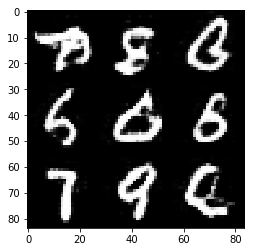

Epoch 3/5: steps 810 Discriminator Loss: 1.1885... Generator Loss: 0.9526
Epoch 3/5: steps 820 Discriminator Loss: 1.1204... Generator Loss: 0.9515
Epoch 3/5: steps 830 Discriminator Loss: 1.3855... Generator Loss: 1.1674
Epoch 3/5: steps 840 Discriminator Loss: 1.1202... Generator Loss: 0.8184
Epoch 3/5: steps 850 Discriminator Loss: 1.1863... Generator Loss: 0.9199
Epoch 3/5: steps 860 Discriminator Loss: 1.4077... Generator Loss: 0.6559
Epoch 3/5: steps 870 Discriminator Loss: 1.3737... Generator Loss: 0.8401
Epoch 3/5: steps 880 Discriminator Loss: 1.1771... Generator Loss: 0.8750
Epoch 3/5: steps 890 Discriminator Loss: 1.1026... Generator Loss: 0.9089
Epoch 3/5: steps 900 Discriminator Loss: 1.1979... Generator Loss: 0.9158


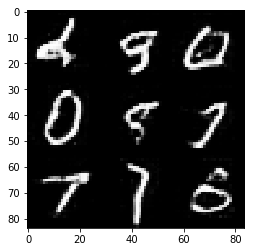

Epoch 3/5: steps 910 Discriminator Loss: 1.0975... Generator Loss: 0.9407
Epoch 3/5: steps 920 Discriminator Loss: 1.1775... Generator Loss: 0.8547
Epoch 3/5: steps 930 Discriminator Loss: 1.1752... Generator Loss: 1.0806
Epoch 4/5: steps 10 Discriminator Loss: 1.2955... Generator Loss: 0.9719
Epoch 4/5: steps 20 Discriminator Loss: 1.1757... Generator Loss: 0.9757
Epoch 4/5: steps 30 Discriminator Loss: 1.3121... Generator Loss: 1.0338
Epoch 4/5: steps 40 Discriminator Loss: 1.1473... Generator Loss: 0.8981
Epoch 4/5: steps 50 Discriminator Loss: 1.0549... Generator Loss: 1.0134
Epoch 4/5: steps 60 Discriminator Loss: 1.2884... Generator Loss: 0.8219
Epoch 4/5: steps 70 Discriminator Loss: 1.1694... Generator Loss: 0.8725
Epoch 4/5: steps 80 Discriminator Loss: 1.0859... Generator Loss: 0.8634
Epoch 4/5: steps 90 Discriminator Loss: 1.1963... Generator Loss: 0.8453
Epoch 4/5: steps 100 Discriminator Loss: 1.2511... Generator Loss: 0.7590


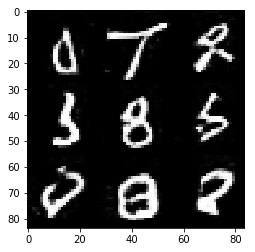

Epoch 4/5: steps 110 Discriminator Loss: 1.2070... Generator Loss: 0.8755
Epoch 4/5: steps 120 Discriminator Loss: 1.1332... Generator Loss: 1.1555
Epoch 4/5: steps 130 Discriminator Loss: 1.2042... Generator Loss: 0.8768
Epoch 4/5: steps 140 Discriminator Loss: 1.1502... Generator Loss: 1.0463
Epoch 4/5: steps 150 Discriminator Loss: 1.1598... Generator Loss: 0.8383
Epoch 4/5: steps 160 Discriminator Loss: 1.2648... Generator Loss: 1.0062
Epoch 4/5: steps 170 Discriminator Loss: 1.2523... Generator Loss: 1.0575
Epoch 4/5: steps 180 Discriminator Loss: 1.2658... Generator Loss: 0.7600
Epoch 4/5: steps 190 Discriminator Loss: 1.2420... Generator Loss: 0.8805
Epoch 4/5: steps 200 Discriminator Loss: 1.1849... Generator Loss: 0.8719


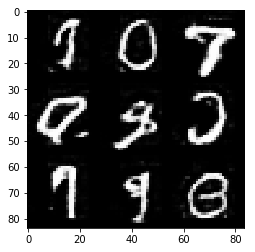

Epoch 4/5: steps 210 Discriminator Loss: 1.1654... Generator Loss: 1.0120
Epoch 4/5: steps 220 Discriminator Loss: 1.2103... Generator Loss: 0.7414
Epoch 4/5: steps 230 Discriminator Loss: 1.2207... Generator Loss: 0.7927
Epoch 4/5: steps 240 Discriminator Loss: 1.3273... Generator Loss: 0.8250
Epoch 4/5: steps 250 Discriminator Loss: 1.1565... Generator Loss: 0.8782
Epoch 4/5: steps 260 Discriminator Loss: 1.1390... Generator Loss: 0.8670
Epoch 4/5: steps 270 Discriminator Loss: 1.1857... Generator Loss: 0.8232
Epoch 4/5: steps 280 Discriminator Loss: 1.2276... Generator Loss: 0.7000
Epoch 4/5: steps 290 Discriminator Loss: 1.1561... Generator Loss: 0.9801
Epoch 4/5: steps 300 Discriminator Loss: 1.2467... Generator Loss: 0.9070


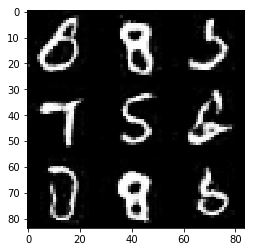

Epoch 4/5: steps 310 Discriminator Loss: 1.1411... Generator Loss: 0.9237
Epoch 4/5: steps 320 Discriminator Loss: 1.2369... Generator Loss: 0.7148
Epoch 4/5: steps 330 Discriminator Loss: 1.1347... Generator Loss: 1.0571
Epoch 4/5: steps 340 Discriminator Loss: 1.1790... Generator Loss: 0.7500
Epoch 4/5: steps 350 Discriminator Loss: 1.2933... Generator Loss: 0.7987
Epoch 4/5: steps 360 Discriminator Loss: 1.1709... Generator Loss: 0.8752
Epoch 4/5: steps 370 Discriminator Loss: 1.2045... Generator Loss: 0.9273
Epoch 4/5: steps 380 Discriminator Loss: 1.1632... Generator Loss: 0.8918
Epoch 4/5: steps 390 Discriminator Loss: 1.2518... Generator Loss: 0.8541
Epoch 4/5: steps 400 Discriminator Loss: 1.1889... Generator Loss: 0.8585


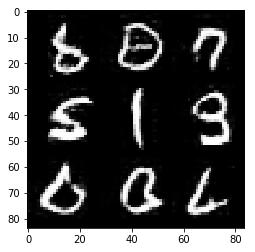

Epoch 4/5: steps 410 Discriminator Loss: 1.2103... Generator Loss: 0.8439
Epoch 4/5: steps 420 Discriminator Loss: 1.1095... Generator Loss: 0.9175
Epoch 4/5: steps 430 Discriminator Loss: 1.1449... Generator Loss: 0.9554
Epoch 4/5: steps 440 Discriminator Loss: 1.2280... Generator Loss: 1.2051
Epoch 4/5: steps 450 Discriminator Loss: 1.1291... Generator Loss: 0.7326
Epoch 4/5: steps 460 Discriminator Loss: 1.2437... Generator Loss: 0.9602
Epoch 4/5: steps 470 Discriminator Loss: 1.2851... Generator Loss: 0.7343
Epoch 4/5: steps 480 Discriminator Loss: 1.1570... Generator Loss: 0.9048
Epoch 4/5: steps 490 Discriminator Loss: 1.2017... Generator Loss: 0.8429
Epoch 4/5: steps 500 Discriminator Loss: 1.1845... Generator Loss: 0.7979


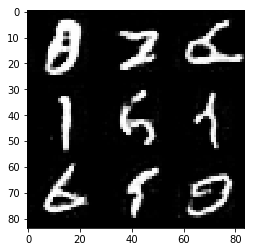

Epoch 4/5: steps 510 Discriminator Loss: 1.2720... Generator Loss: 0.9583
Epoch 4/5: steps 520 Discriminator Loss: 1.2452... Generator Loss: 0.9007
Epoch 4/5: steps 530 Discriminator Loss: 1.1755... Generator Loss: 0.9628
Epoch 4/5: steps 540 Discriminator Loss: 1.2226... Generator Loss: 0.8690
Epoch 4/5: steps 550 Discriminator Loss: 1.1439... Generator Loss: 0.8330
Epoch 4/5: steps 560 Discriminator Loss: 1.3600... Generator Loss: 0.7361
Epoch 4/5: steps 570 Discriminator Loss: 1.2351... Generator Loss: 0.8058
Epoch 4/5: steps 580 Discriminator Loss: 1.1181... Generator Loss: 0.8057
Epoch 4/5: steps 590 Discriminator Loss: 1.2883... Generator Loss: 1.0067
Epoch 4/5: steps 600 Discriminator Loss: 1.2216... Generator Loss: 0.9023


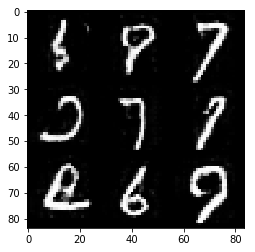

Epoch 4/5: steps 610 Discriminator Loss: 1.2106... Generator Loss: 0.7804
Epoch 4/5: steps 620 Discriminator Loss: 1.1689... Generator Loss: 0.8748
Epoch 4/5: steps 630 Discriminator Loss: 1.1500... Generator Loss: 0.9993
Epoch 4/5: steps 640 Discriminator Loss: 1.1316... Generator Loss: 0.8884
Epoch 4/5: steps 650 Discriminator Loss: 1.3073... Generator Loss: 0.8524
Epoch 4/5: steps 660 Discriminator Loss: 1.1512... Generator Loss: 0.7925
Epoch 4/5: steps 670 Discriminator Loss: 1.2112... Generator Loss: 0.7632
Epoch 4/5: steps 680 Discriminator Loss: 1.2060... Generator Loss: 0.9069
Epoch 4/5: steps 690 Discriminator Loss: 1.2489... Generator Loss: 0.8031
Epoch 4/5: steps 700 Discriminator Loss: 1.2330... Generator Loss: 0.7585


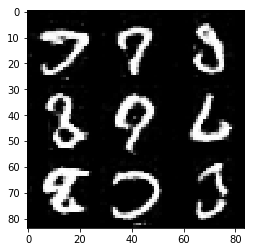

Epoch 4/5: steps 710 Discriminator Loss: 1.2002... Generator Loss: 0.9351
Epoch 4/5: steps 720 Discriminator Loss: 1.2217... Generator Loss: 0.9819
Epoch 4/5: steps 730 Discriminator Loss: 1.2256... Generator Loss: 0.8524
Epoch 4/5: steps 740 Discriminator Loss: 1.1991... Generator Loss: 0.8855
Epoch 4/5: steps 750 Discriminator Loss: 1.2398... Generator Loss: 0.9129
Epoch 4/5: steps 760 Discriminator Loss: 1.1582... Generator Loss: 0.8817
Epoch 4/5: steps 770 Discriminator Loss: 1.1584... Generator Loss: 0.8825
Epoch 4/5: steps 780 Discriminator Loss: 1.2876... Generator Loss: 0.9633
Epoch 4/5: steps 790 Discriminator Loss: 1.2553... Generator Loss: 0.7881
Epoch 4/5: steps 800 Discriminator Loss: 1.1758... Generator Loss: 0.7709


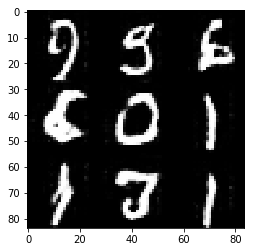

Epoch 4/5: steps 810 Discriminator Loss: 1.2737... Generator Loss: 0.8504
Epoch 4/5: steps 820 Discriminator Loss: 1.2463... Generator Loss: 0.9140
Epoch 4/5: steps 830 Discriminator Loss: 1.2408... Generator Loss: 0.7867
Epoch 4/5: steps 840 Discriminator Loss: 1.1111... Generator Loss: 0.9228
Epoch 4/5: steps 850 Discriminator Loss: 1.0900... Generator Loss: 0.8492
Epoch 4/5: steps 860 Discriminator Loss: 1.3349... Generator Loss: 0.7496
Epoch 4/5: steps 870 Discriminator Loss: 1.3066... Generator Loss: 0.8732
Epoch 4/5: steps 880 Discriminator Loss: 1.3360... Generator Loss: 0.7567
Epoch 4/5: steps 890 Discriminator Loss: 1.2521... Generator Loss: 0.9974
Epoch 4/5: steps 900 Discriminator Loss: 1.1658... Generator Loss: 0.9843


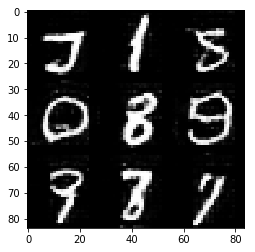

Epoch 4/5: steps 910 Discriminator Loss: 1.1693... Generator Loss: 0.9124
Epoch 4/5: steps 920 Discriminator Loss: 1.1750... Generator Loss: 0.9294
Epoch 4/5: steps 930 Discriminator Loss: 1.2118... Generator Loss: 1.3457
Epoch 5/5: steps 10 Discriminator Loss: 1.2365... Generator Loss: 0.8353
Epoch 5/5: steps 20 Discriminator Loss: 1.1747... Generator Loss: 0.9517
Epoch 5/5: steps 30 Discriminator Loss: 1.2270... Generator Loss: 1.0212
Epoch 5/5: steps 40 Discriminator Loss: 1.3032... Generator Loss: 0.9202
Epoch 5/5: steps 50 Discriminator Loss: 1.2603... Generator Loss: 0.8113
Epoch 5/5: steps 60 Discriminator Loss: 1.2751... Generator Loss: 0.8774
Epoch 5/5: steps 70 Discriminator Loss: 1.1329... Generator Loss: 1.0367
Epoch 5/5: steps 80 Discriminator Loss: 1.1700... Generator Loss: 0.7979
Epoch 5/5: steps 90 Discriminator Loss: 1.1978... Generator Loss: 0.9437
Epoch 5/5: steps 100 Discriminator Loss: 1.2754... Generator Loss: 0.8440


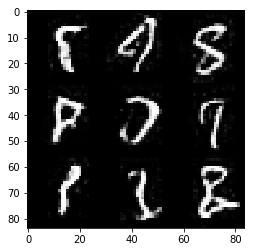

Epoch 5/5: steps 110 Discriminator Loss: 1.2537... Generator Loss: 0.7744
Epoch 5/5: steps 120 Discriminator Loss: 1.1048... Generator Loss: 0.9113
Epoch 5/5: steps 130 Discriminator Loss: 1.2169... Generator Loss: 0.8684
Epoch 5/5: steps 140 Discriminator Loss: 1.1830... Generator Loss: 0.9321
Epoch 5/5: steps 150 Discriminator Loss: 1.1704... Generator Loss: 1.0042
Epoch 5/5: steps 160 Discriminator Loss: 1.2089... Generator Loss: 0.8081
Epoch 5/5: steps 170 Discriminator Loss: 1.2559... Generator Loss: 0.8581
Epoch 5/5: steps 180 Discriminator Loss: 1.2655... Generator Loss: 1.0973
Epoch 5/5: steps 190 Discriminator Loss: 1.2451... Generator Loss: 0.8099
Epoch 5/5: steps 200 Discriminator Loss: 1.1923... Generator Loss: 0.7932


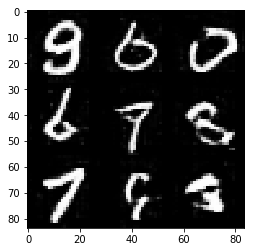

Epoch 5/5: steps 210 Discriminator Loss: 1.1728... Generator Loss: 0.9068
Epoch 5/5: steps 220 Discriminator Loss: 1.2716... Generator Loss: 0.8435
Epoch 5/5: steps 230 Discriminator Loss: 1.2146... Generator Loss: 0.8418
Epoch 5/5: steps 240 Discriminator Loss: 1.1913... Generator Loss: 0.8966
Epoch 5/5: steps 250 Discriminator Loss: 1.1390... Generator Loss: 0.8711
Epoch 5/5: steps 260 Discriminator Loss: 1.1398... Generator Loss: 0.8148
Epoch 5/5: steps 270 Discriminator Loss: 1.1774... Generator Loss: 0.9099
Epoch 5/5: steps 280 Discriminator Loss: 1.2769... Generator Loss: 0.9407
Epoch 5/5: steps 290 Discriminator Loss: 1.0673... Generator Loss: 0.9111
Epoch 5/5: steps 300 Discriminator Loss: 1.2513... Generator Loss: 0.8377


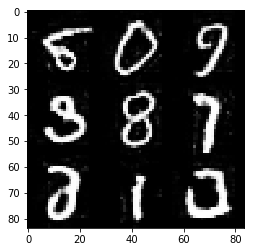

Epoch 5/5: steps 310 Discriminator Loss: 1.1610... Generator Loss: 0.8845
Epoch 5/5: steps 320 Discriminator Loss: 1.2140... Generator Loss: 0.7764
Epoch 5/5: steps 330 Discriminator Loss: 1.0956... Generator Loss: 0.9278
Epoch 5/5: steps 340 Discriminator Loss: 1.2056... Generator Loss: 0.8081
Epoch 5/5: steps 350 Discriminator Loss: 1.2411... Generator Loss: 1.0508
Epoch 5/5: steps 360 Discriminator Loss: 1.1422... Generator Loss: 0.8309
Epoch 5/5: steps 370 Discriminator Loss: 1.2807... Generator Loss: 0.8977
Epoch 5/5: steps 380 Discriminator Loss: 1.0676... Generator Loss: 1.0083
Epoch 5/5: steps 390 Discriminator Loss: 1.2205... Generator Loss: 0.8509
Epoch 5/5: steps 400 Discriminator Loss: 1.1850... Generator Loss: 0.9421


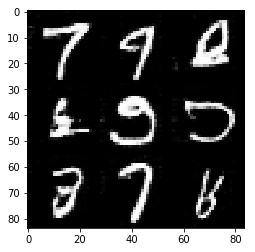

Epoch 5/5: steps 410 Discriminator Loss: 1.1944... Generator Loss: 0.8115
Epoch 5/5: steps 420 Discriminator Loss: 1.2317... Generator Loss: 0.8815
Epoch 5/5: steps 430 Discriminator Loss: 1.3063... Generator Loss: 0.8562
Epoch 5/5: steps 440 Discriminator Loss: 1.1364... Generator Loss: 0.8675
Epoch 5/5: steps 450 Discriminator Loss: 1.1176... Generator Loss: 1.0965
Epoch 5/5: steps 460 Discriminator Loss: 1.1850... Generator Loss: 1.0061
Epoch 5/5: steps 470 Discriminator Loss: 1.1881... Generator Loss: 0.8295
Epoch 5/5: steps 480 Discriminator Loss: 1.2789... Generator Loss: 0.8525
Epoch 5/5: steps 490 Discriminator Loss: 1.2419... Generator Loss: 0.9056
Epoch 5/5: steps 500 Discriminator Loss: 1.0881... Generator Loss: 0.9364


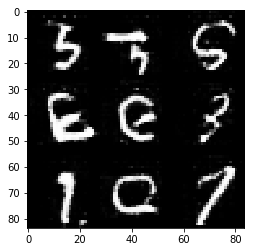

Epoch 5/5: steps 510 Discriminator Loss: 1.2047... Generator Loss: 0.9329
Epoch 5/5: steps 520 Discriminator Loss: 1.1226... Generator Loss: 0.8741
Epoch 5/5: steps 530 Discriminator Loss: 1.2145... Generator Loss: 1.1240
Epoch 5/5: steps 540 Discriminator Loss: 1.1712... Generator Loss: 0.8723
Epoch 5/5: steps 550 Discriminator Loss: 1.1502... Generator Loss: 1.0452
Epoch 5/5: steps 560 Discriminator Loss: 1.1782... Generator Loss: 0.7501
Epoch 5/5: steps 570 Discriminator Loss: 1.1934... Generator Loss: 1.0688
Epoch 5/5: steps 580 Discriminator Loss: 1.2108... Generator Loss: 0.8773
Epoch 5/5: steps 590 Discriminator Loss: 1.2533... Generator Loss: 1.0228
Epoch 5/5: steps 600 Discriminator Loss: 1.2114... Generator Loss: 0.7463


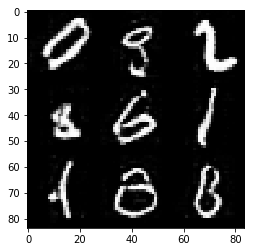

Epoch 5/5: steps 610 Discriminator Loss: 1.1731... Generator Loss: 0.9741
Epoch 5/5: steps 620 Discriminator Loss: 1.2583... Generator Loss: 0.9904
Epoch 5/5: steps 630 Discriminator Loss: 1.3415... Generator Loss: 1.1311
Epoch 5/5: steps 640 Discriminator Loss: 1.1972... Generator Loss: 0.9621
Epoch 5/5: steps 650 Discriminator Loss: 1.3447... Generator Loss: 0.9178
Epoch 5/5: steps 660 Discriminator Loss: 1.2612... Generator Loss: 0.9730
Epoch 5/5: steps 670 Discriminator Loss: 1.1502... Generator Loss: 0.9383
Epoch 5/5: steps 680 Discriminator Loss: 1.2611... Generator Loss: 0.8913
Epoch 5/5: steps 690 Discriminator Loss: 1.2114... Generator Loss: 1.0262
Epoch 5/5: steps 700 Discriminator Loss: 1.2293... Generator Loss: 0.9276


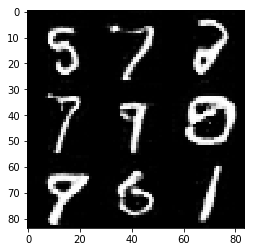

Epoch 5/5: steps 710 Discriminator Loss: 1.2928... Generator Loss: 0.6819
Epoch 5/5: steps 720 Discriminator Loss: 1.2784... Generator Loss: 0.8320
Epoch 5/5: steps 730 Discriminator Loss: 1.1705... Generator Loss: 0.9195
Epoch 5/5: steps 740 Discriminator Loss: 1.2154... Generator Loss: 0.8401
Epoch 5/5: steps 750 Discriminator Loss: 1.2198... Generator Loss: 0.8413
Epoch 5/5: steps 760 Discriminator Loss: 1.1540... Generator Loss: 0.8553
Epoch 5/5: steps 770 Discriminator Loss: 1.1722... Generator Loss: 0.8524
Epoch 5/5: steps 780 Discriminator Loss: 1.3064... Generator Loss: 0.8534
Epoch 5/5: steps 790 Discriminator Loss: 1.2874... Generator Loss: 0.9210
Epoch 5/5: steps 800 Discriminator Loss: 1.2771... Generator Loss: 0.8616


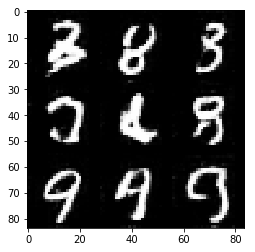

Epoch 5/5: steps 810 Discriminator Loss: 1.1724... Generator Loss: 1.0223
Epoch 5/5: steps 820 Discriminator Loss: 1.1291... Generator Loss: 0.9029
Epoch 5/5: steps 830 Discriminator Loss: 1.1638... Generator Loss: 1.0271
Epoch 5/5: steps 840 Discriminator Loss: 1.1339... Generator Loss: 0.7463
Epoch 5/5: steps 850 Discriminator Loss: 1.4603... Generator Loss: 0.4194
Epoch 5/5: steps 860 Discriminator Loss: 1.3639... Generator Loss: 0.9799
Epoch 5/5: steps 870 Discriminator Loss: 1.3457... Generator Loss: 0.8359
Epoch 5/5: steps 880 Discriminator Loss: 1.3679... Generator Loss: 0.9139
Epoch 5/5: steps 890 Discriminator Loss: 1.0896... Generator Loss: 0.9294
Epoch 5/5: steps 900 Discriminator Loss: 1.1603... Generator Loss: 0.8230


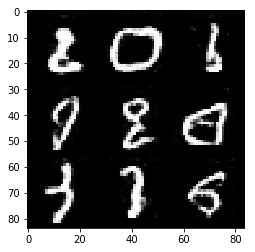

Epoch 5/5: steps 910 Discriminator Loss: 1.1682... Generator Loss: 0.8210
Epoch 5/5: steps 920 Discriminator Loss: 1.1668... Generator Loss: 0.7060
Epoch 5/5: steps 930 Discriminator Loss: 1.2111... Generator Loss: 1.0775


In [84]:
batch_size = 64
z_dim = 100
learning_rate = .0003
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5: steps 10 Discriminator Loss: 1.5192... Generator Loss: 0.6782
Epoch 1/5: steps 20 Discriminator Loss: 1.4686... Generator Loss: 0.7772
Epoch 1/5: steps 30 Discriminator Loss: 1.3323... Generator Loss: 0.7284
Epoch 1/5: steps 40 Discriminator Loss: 1.2378... Generator Loss: 0.9239
Epoch 1/5: steps 50 Discriminator Loss: 1.0628... Generator Loss: 1.0307
Epoch 1/5: steps 60 Discriminator Loss: 0.9794... Generator Loss: 1.0577
Epoch 1/5: steps 70 Discriminator Loss: 0.8427... Generator Loss: 1.2717
Epoch 1/5: steps 80 Discriminator Loss: 0.7993... Generator Loss: 1.3237
Epoch 1/5: steps 90 Discriminator Loss: 0.7460... Generator Loss: 1.1865
Epoch 1/5: steps 100 Discriminator Loss: 0.6681... Generator Loss: 1.5467


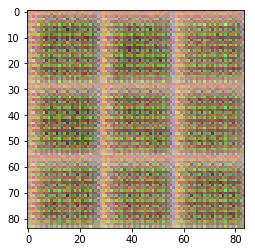

Epoch 1/5: steps 110 Discriminator Loss: 0.6745... Generator Loss: 1.6039
Epoch 1/5: steps 120 Discriminator Loss: 0.5455... Generator Loss: 1.8599
Epoch 1/5: steps 130 Discriminator Loss: 0.4885... Generator Loss: 1.7194
Epoch 1/5: steps 140 Discriminator Loss: 0.4652... Generator Loss: 1.9130
Epoch 1/5: steps 150 Discriminator Loss: 0.5569... Generator Loss: 1.9953
Epoch 1/5: steps 160 Discriminator Loss: 0.5278... Generator Loss: 1.8289
Epoch 1/5: steps 170 Discriminator Loss: 0.5327... Generator Loss: 2.1200
Epoch 1/5: steps 180 Discriminator Loss: 0.4889... Generator Loss: 1.8191
Epoch 1/5: steps 190 Discriminator Loss: 0.4039... Generator Loss: 2.4454
Epoch 1/5: steps 200 Discriminator Loss: 0.3689... Generator Loss: 2.4768


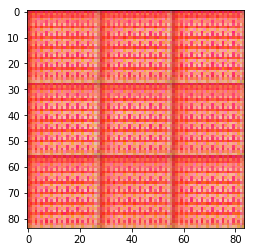

Epoch 1/5: steps 210 Discriminator Loss: 0.4191... Generator Loss: 2.7939
Epoch 1/5: steps 220 Discriminator Loss: 0.4046... Generator Loss: 2.3668
Epoch 1/5: steps 230 Discriminator Loss: 0.4185... Generator Loss: 2.4553
Epoch 1/5: steps 240 Discriminator Loss: 0.4496... Generator Loss: 2.4675
Epoch 1/5: steps 250 Discriminator Loss: 0.8382... Generator Loss: 2.0332
Epoch 1/5: steps 260 Discriminator Loss: 0.5890... Generator Loss: 1.3996
Epoch 1/5: steps 270 Discriminator Loss: 0.6819... Generator Loss: 1.3454
Epoch 1/5: steps 280 Discriminator Loss: 1.3955... Generator Loss: 0.4520
Epoch 1/5: steps 290 Discriminator Loss: 0.7761... Generator Loss: 1.3655
Epoch 1/5: steps 300 Discriminator Loss: 0.5360... Generator Loss: 1.5492


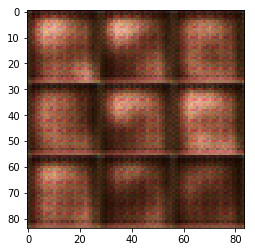

Epoch 1/5: steps 310 Discriminator Loss: 0.6289... Generator Loss: 1.9019
Epoch 1/5: steps 320 Discriminator Loss: 0.8050... Generator Loss: 0.9963
Epoch 1/5: steps 330 Discriminator Loss: 0.4926... Generator Loss: 1.8004
Epoch 1/5: steps 340 Discriminator Loss: 0.5318... Generator Loss: 1.6898
Epoch 1/5: steps 350 Discriminator Loss: 0.5728... Generator Loss: 1.7145
Epoch 1/5: steps 360 Discriminator Loss: 0.4023... Generator Loss: 2.4961
Epoch 1/5: steps 370 Discriminator Loss: 0.3638... Generator Loss: 3.3226
Epoch 1/5: steps 380 Discriminator Loss: 0.4047... Generator Loss: 2.9765
Epoch 1/5: steps 390 Discriminator Loss: 0.4360... Generator Loss: 2.0871
Epoch 1/5: steps 400 Discriminator Loss: 0.4058... Generator Loss: 2.7842


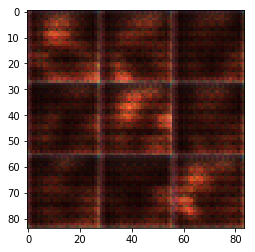

Epoch 1/5: steps 410 Discriminator Loss: 0.6540... Generator Loss: 1.3023
Epoch 1/5: steps 420 Discriminator Loss: 0.6973... Generator Loss: 1.0090
Epoch 1/5: steps 430 Discriminator Loss: 0.3561... Generator Loss: 3.6520
Epoch 1/5: steps 440 Discriminator Loss: 0.5642... Generator Loss: 1.6379
Epoch 1/5: steps 450 Discriminator Loss: 0.6127... Generator Loss: 1.2295
Epoch 1/5: steps 460 Discriminator Loss: 0.3779... Generator Loss: 3.1109
Epoch 1/5: steps 470 Discriminator Loss: 0.3635... Generator Loss: 2.1954
Epoch 1/5: steps 480 Discriminator Loss: 0.4375... Generator Loss: 8.0290
Epoch 1/5: steps 490 Discriminator Loss: 0.6376... Generator Loss: 2.7203
Epoch 1/5: steps 500 Discriminator Loss: 0.5318... Generator Loss: 1.4709


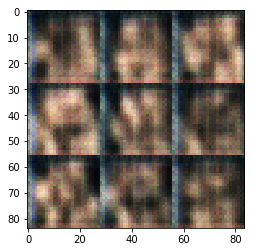

Epoch 1/5: steps 510 Discriminator Loss: 0.4356... Generator Loss: 3.1780
Epoch 1/5: steps 520 Discriminator Loss: 0.4738... Generator Loss: 1.8482
Epoch 1/5: steps 530 Discriminator Loss: 0.3973... Generator Loss: 2.5151
Epoch 1/5: steps 540 Discriminator Loss: 0.5138... Generator Loss: 1.6781
Epoch 1/5: steps 550 Discriminator Loss: 0.3654... Generator Loss: 3.0520
Epoch 1/5: steps 560 Discriminator Loss: 0.3752... Generator Loss: 3.3289
Epoch 1/5: steps 570 Discriminator Loss: 0.5028... Generator Loss: 1.4758
Epoch 1/5: steps 580 Discriminator Loss: 0.4306... Generator Loss: 3.5621
Epoch 1/5: steps 590 Discriminator Loss: 0.3273... Generator Loss: 5.0551
Epoch 1/5: steps 600 Discriminator Loss: 0.3590... Generator Loss: 3.9476


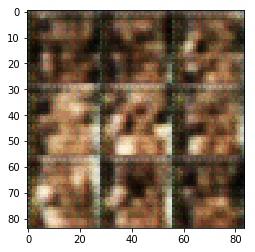

Epoch 1/5: steps 610 Discriminator Loss: 0.4265... Generator Loss: 2.5437
Epoch 1/5: steps 620 Discriminator Loss: 0.4193... Generator Loss: 4.0507
Epoch 1/5: steps 630 Discriminator Loss: 0.3707... Generator Loss: 2.8156
Epoch 1/5: steps 640 Discriminator Loss: 0.4921... Generator Loss: 3.3273
Epoch 1/5: steps 650 Discriminator Loss: 0.3383... Generator Loss: 4.1146
Epoch 1/5: steps 660 Discriminator Loss: 0.4943... Generator Loss: 1.8476
Epoch 1/5: steps 670 Discriminator Loss: 0.3974... Generator Loss: 2.9515
Epoch 1/5: steps 680 Discriminator Loss: 0.3838... Generator Loss: 2.2258
Epoch 1/5: steps 690 Discriminator Loss: 0.3646... Generator Loss: 2.6790
Epoch 1/5: steps 700 Discriminator Loss: 0.3603... Generator Loss: 2.6738


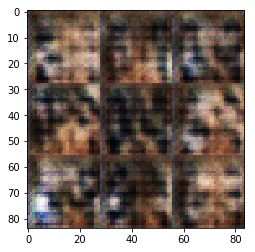

Epoch 1/5: steps 710 Discriminator Loss: 0.3577... Generator Loss: 2.8696
Epoch 1/5: steps 720 Discriminator Loss: 0.3549... Generator Loss: 2.8707
Epoch 1/5: steps 730 Discriminator Loss: 0.3916... Generator Loss: 2.1700
Epoch 1/5: steps 740 Discriminator Loss: 0.3937... Generator Loss: 2.7461
Epoch 1/5: steps 750 Discriminator Loss: 0.6986... Generator Loss: 1.1114
Epoch 1/5: steps 760 Discriminator Loss: 0.6450... Generator Loss: 1.2556
Epoch 1/5: steps 770 Discriminator Loss: 0.3840... Generator Loss: 5.2096
Epoch 1/5: steps 780 Discriminator Loss: 0.3124... Generator Loss: 7.0366
Epoch 1/5: steps 790 Discriminator Loss: 0.5434... Generator Loss: 3.4836
Epoch 1/5: steps 800 Discriminator Loss: 0.5097... Generator Loss: 1.9451


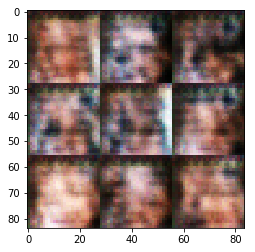

Epoch 1/5: steps 810 Discriminator Loss: 0.4832... Generator Loss: 1.7235
Epoch 1/5: steps 820 Discriminator Loss: 0.4093... Generator Loss: 2.0122
Epoch 1/5: steps 830 Discriminator Loss: 0.4718... Generator Loss: 2.3181
Epoch 1/5: steps 840 Discriminator Loss: 0.3593... Generator Loss: 2.3013
Epoch 1/5: steps 850 Discriminator Loss: 0.3818... Generator Loss: 2.5707
Epoch 1/5: steps 860 Discriminator Loss: 0.3997... Generator Loss: 2.2496
Epoch 1/5: steps 870 Discriminator Loss: 0.3905... Generator Loss: 2.2576
Epoch 1/5: steps 880 Discriminator Loss: 0.3372... Generator Loss: 3.9857
Epoch 1/5: steps 890 Discriminator Loss: 0.4761... Generator Loss: 1.6131
Epoch 1/5: steps 900 Discriminator Loss: 0.7294... Generator Loss: 1.4536


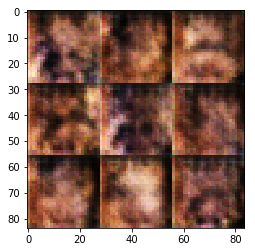

Epoch 1/5: steps 910 Discriminator Loss: 0.3868... Generator Loss: 2.7961
Epoch 1/5: steps 920 Discriminator Loss: 0.8857... Generator Loss: 3.3619
Epoch 1/5: steps 930 Discriminator Loss: 0.5110... Generator Loss: 1.5866
Epoch 1/5: steps 940 Discriminator Loss: 0.5366... Generator Loss: 1.8076
Epoch 1/5: steps 950 Discriminator Loss: 0.5036... Generator Loss: 2.5187
Epoch 1/5: steps 960 Discriminator Loss: 0.3606... Generator Loss: 3.4227
Epoch 1/5: steps 970 Discriminator Loss: 0.3711... Generator Loss: 3.2038
Epoch 1/5: steps 980 Discriminator Loss: 0.5526... Generator Loss: 1.9197
Epoch 1/5: steps 990 Discriminator Loss: 1.1375... Generator Loss: 1.0391
Epoch 1/5: steps 1000 Discriminator Loss: 0.4423... Generator Loss: 2.6213


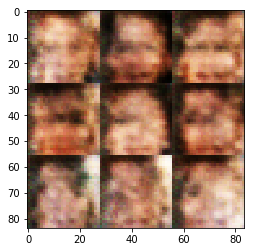

Epoch 1/5: steps 1010 Discriminator Loss: 0.4853... Generator Loss: 1.6335
Epoch 1/5: steps 1020 Discriminator Loss: 0.5970... Generator Loss: 1.4087
Epoch 1/5: steps 1030 Discriminator Loss: 0.3876... Generator Loss: 2.5100
Epoch 1/5: steps 1040 Discriminator Loss: 0.4243... Generator Loss: 2.2860
Epoch 1/5: steps 1050 Discriminator Loss: 0.5173... Generator Loss: 1.9567
Epoch 1/5: steps 1060 Discriminator Loss: 0.4216... Generator Loss: 3.1631
Epoch 1/5: steps 1070 Discriminator Loss: 0.4385... Generator Loss: 1.8222
Epoch 1/5: steps 1080 Discriminator Loss: 0.4499... Generator Loss: 1.8186
Epoch 1/5: steps 1090 Discriminator Loss: 0.4085... Generator Loss: 2.6527
Epoch 1/5: steps 1100 Discriminator Loss: 0.4440... Generator Loss: 3.2434


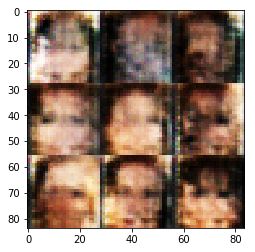

Epoch 1/5: steps 1110 Discriminator Loss: 1.3348... Generator Loss: 1.7065
Epoch 1/5: steps 1120 Discriminator Loss: 0.9438... Generator Loss: 0.9319
Epoch 1/5: steps 1130 Discriminator Loss: 0.4871... Generator Loss: 2.1188
Epoch 1/5: steps 1140 Discriminator Loss: 0.5497... Generator Loss: 1.6109
Epoch 1/5: steps 1150 Discriminator Loss: 0.4281... Generator Loss: 2.6048
Epoch 1/5: steps 1160 Discriminator Loss: 0.4230... Generator Loss: 3.8257
Epoch 1/5: steps 1170 Discriminator Loss: 0.5600... Generator Loss: 2.7956
Epoch 1/5: steps 1180 Discriminator Loss: 0.4107... Generator Loss: 2.3453
Epoch 1/5: steps 1190 Discriminator Loss: 0.7474... Generator Loss: 1.1742
Epoch 1/5: steps 1200 Discriminator Loss: 0.7929... Generator Loss: 0.8963


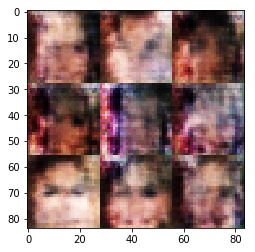

Epoch 1/5: steps 1210 Discriminator Loss: 0.6164... Generator Loss: 1.3974
Epoch 1/5: steps 1220 Discriminator Loss: 0.5560... Generator Loss: 2.1969
Epoch 1/5: steps 1230 Discriminator Loss: 1.3992... Generator Loss: 0.7793
Epoch 1/5: steps 1240 Discriminator Loss: 0.8428... Generator Loss: 1.2415
Epoch 1/5: steps 1250 Discriminator Loss: 0.7857... Generator Loss: 0.9471
Epoch 1/5: steps 1260 Discriminator Loss: 0.6047... Generator Loss: 1.5613
Epoch 1/5: steps 1270 Discriminator Loss: 0.5788... Generator Loss: 2.1164
Epoch 1/5: steps 1280 Discriminator Loss: 0.5573... Generator Loss: 1.6513
Epoch 1/5: steps 1290 Discriminator Loss: 0.7041... Generator Loss: 2.0018
Epoch 1/5: steps 1300 Discriminator Loss: 0.5321... Generator Loss: 1.7516


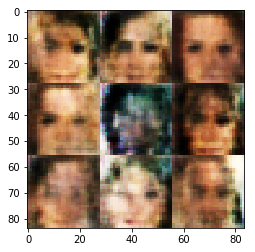

Epoch 1/5: steps 1310 Discriminator Loss: 0.5017... Generator Loss: 2.5598
Epoch 1/5: steps 1320 Discriminator Loss: 0.5048... Generator Loss: 1.8457
Epoch 1/5: steps 1330 Discriminator Loss: 0.5985... Generator Loss: 1.7759
Epoch 1/5: steps 1340 Discriminator Loss: 0.5660... Generator Loss: 2.7225
Epoch 1/5: steps 1350 Discriminator Loss: 0.6831... Generator Loss: 1.2228
Epoch 1/5: steps 1360 Discriminator Loss: 1.2802... Generator Loss: 1.6086
Epoch 1/5: steps 1370 Discriminator Loss: 0.8691... Generator Loss: 0.9046
Epoch 1/5: steps 1380 Discriminator Loss: 0.7494... Generator Loss: 1.5025
Epoch 1/5: steps 1390 Discriminator Loss: 0.6133... Generator Loss: 1.4716
Epoch 1/5: steps 1400 Discriminator Loss: 0.6399... Generator Loss: 1.4458


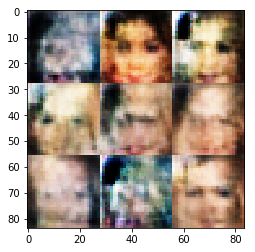

Epoch 1/5: steps 1410 Discriminator Loss: 0.5288... Generator Loss: 2.0830
Epoch 1/5: steps 1420 Discriminator Loss: 0.6662... Generator Loss: 1.7682
Epoch 1/5: steps 1430 Discriminator Loss: 1.1669... Generator Loss: 0.7684
Epoch 1/5: steps 1440 Discriminator Loss: 0.7979... Generator Loss: 1.1564
Epoch 1/5: steps 1450 Discriminator Loss: 0.8328... Generator Loss: 1.4694
Epoch 1/5: steps 1460 Discriminator Loss: 0.5678... Generator Loss: 1.8402
Epoch 1/5: steps 1470 Discriminator Loss: 0.7120... Generator Loss: 1.3873
Epoch 1/5: steps 1480 Discriminator Loss: 2.7294... Generator Loss: 2.6079
Epoch 1/5: steps 1490 Discriminator Loss: 0.8650... Generator Loss: 1.2274
Epoch 1/5: steps 1500 Discriminator Loss: 0.7690... Generator Loss: 1.0992


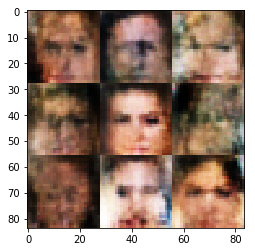

Epoch 1/5: steps 1510 Discriminator Loss: 0.6657... Generator Loss: 2.1055
Epoch 1/5: steps 1520 Discriminator Loss: 0.5315... Generator Loss: 2.1053
Epoch 1/5: steps 1530 Discriminator Loss: 0.6774... Generator Loss: 1.7328
Epoch 1/5: steps 1540 Discriminator Loss: 0.8442... Generator Loss: 1.1018
Epoch 1/5: steps 1550 Discriminator Loss: 0.6471... Generator Loss: 1.7660
Epoch 1/5: steps 1560 Discriminator Loss: 1.1192... Generator Loss: 0.7474
Epoch 1/5: steps 1570 Discriminator Loss: 0.7366... Generator Loss: 1.2421
Epoch 1/5: steps 1580 Discriminator Loss: 0.6893... Generator Loss: 1.7837
Epoch 1/5: steps 1590 Discriminator Loss: 0.7469... Generator Loss: 1.4348
Epoch 1/5: steps 1600 Discriminator Loss: 1.1114... Generator Loss: 1.0684


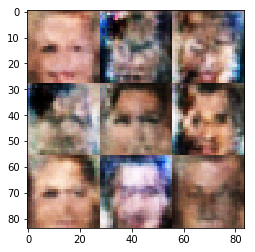

Epoch 1/5: steps 1610 Discriminator Loss: 0.7372... Generator Loss: 1.3941
Epoch 1/5: steps 1620 Discriminator Loss: 0.7066... Generator Loss: 1.3792
Epoch 1/5: steps 1630 Discriminator Loss: 0.5655... Generator Loss: 1.5915
Epoch 1/5: steps 1640 Discriminator Loss: 0.6253... Generator Loss: 1.8856
Epoch 1/5: steps 1650 Discriminator Loss: 0.8476... Generator Loss: 1.7051
Epoch 1/5: steps 1660 Discriminator Loss: 1.6285... Generator Loss: 1.1162
Epoch 1/5: steps 1670 Discriminator Loss: 1.0232... Generator Loss: 0.9226
Epoch 1/5: steps 1680 Discriminator Loss: 0.8811... Generator Loss: 1.4122
Epoch 1/5: steps 1690 Discriminator Loss: 0.9059... Generator Loss: 1.0479
Epoch 1/5: steps 1700 Discriminator Loss: 1.0812... Generator Loss: 1.7653


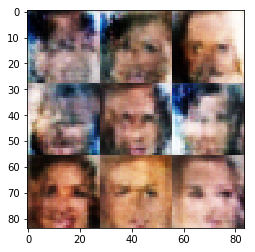

Epoch 1/5: steps 1710 Discriminator Loss: 0.9287... Generator Loss: 1.0437
Epoch 1/5: steps 1720 Discriminator Loss: 0.8823... Generator Loss: 0.9486
Epoch 1/5: steps 1730 Discriminator Loss: 0.7908... Generator Loss: 1.1798
Epoch 1/5: steps 1740 Discriminator Loss: 0.8516... Generator Loss: 1.1690
Epoch 1/5: steps 1750 Discriminator Loss: 0.9553... Generator Loss: 1.4809
Epoch 1/5: steps 1760 Discriminator Loss: 0.8036... Generator Loss: 1.3647
Epoch 1/5: steps 1770 Discriminator Loss: 0.7906... Generator Loss: 1.2924
Epoch 1/5: steps 1780 Discriminator Loss: 0.6585... Generator Loss: 1.6166
Epoch 1/5: steps 1790 Discriminator Loss: 1.4312... Generator Loss: 0.9791
Epoch 1/5: steps 1800 Discriminator Loss: 0.9862... Generator Loss: 1.1298


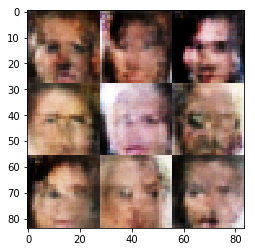

Epoch 1/5: steps 1810 Discriminator Loss: 0.7819... Generator Loss: 1.1423
Epoch 1/5: steps 1820 Discriminator Loss: 0.8215... Generator Loss: 1.1385
Epoch 1/5: steps 1830 Discriminator Loss: 1.6482... Generator Loss: 1.0662
Epoch 1/5: steps 1840 Discriminator Loss: 0.9577... Generator Loss: 1.0366
Epoch 1/5: steps 1850 Discriminator Loss: 0.9140... Generator Loss: 1.0105
Epoch 1/5: steps 1860 Discriminator Loss: 0.8982... Generator Loss: 1.0456
Epoch 1/5: steps 1870 Discriminator Loss: 0.9821... Generator Loss: 1.0886
Epoch 1/5: steps 1880 Discriminator Loss: 0.8379... Generator Loss: 0.9970
Epoch 1/5: steps 1890 Discriminator Loss: 0.7075... Generator Loss: 1.3035
Epoch 1/5: steps 1900 Discriminator Loss: 0.7900... Generator Loss: 1.3725


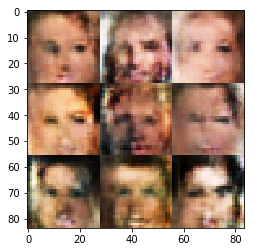

Epoch 1/5: steps 1910 Discriminator Loss: 0.9137... Generator Loss: 1.1156
Epoch 1/5: steps 1920 Discriminator Loss: 0.8745... Generator Loss: 1.0000
Epoch 1/5: steps 1930 Discriminator Loss: 0.8771... Generator Loss: 1.1914
Epoch 1/5: steps 1940 Discriminator Loss: 0.8572... Generator Loss: 1.0388
Epoch 1/5: steps 1950 Discriminator Loss: 0.9922... Generator Loss: 1.0692
Epoch 1/5: steps 1960 Discriminator Loss: 0.8828... Generator Loss: 1.3633
Epoch 1/5: steps 1970 Discriminator Loss: 0.8122... Generator Loss: 1.0529
Epoch 1/5: steps 1980 Discriminator Loss: 0.8299... Generator Loss: 1.3393
Epoch 1/5: steps 1990 Discriminator Loss: 0.9517... Generator Loss: 0.9226
Epoch 1/5: steps 2000 Discriminator Loss: 1.1059... Generator Loss: 1.5172


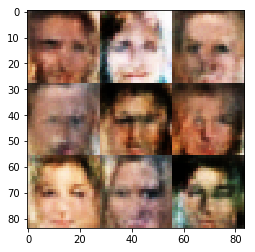

Epoch 1/5: steps 2010 Discriminator Loss: 0.8265... Generator Loss: 1.3338
Epoch 1/5: steps 2020 Discriminator Loss: 0.8835... Generator Loss: 1.2438
Epoch 1/5: steps 2030 Discriminator Loss: 0.6896... Generator Loss: 1.5676
Epoch 1/5: steps 2040 Discriminator Loss: 0.8274... Generator Loss: 1.0837
Epoch 1/5: steps 2050 Discriminator Loss: 2.1055... Generator Loss: 0.9323
Epoch 1/5: steps 2060 Discriminator Loss: 0.7527... Generator Loss: 1.6338
Epoch 1/5: steps 2070 Discriminator Loss: 0.8502... Generator Loss: 1.4306
Epoch 1/5: steps 2080 Discriminator Loss: 0.9885... Generator Loss: 1.1921
Epoch 1/5: steps 2090 Discriminator Loss: 0.8835... Generator Loss: 1.1348
Epoch 1/5: steps 2100 Discriminator Loss: 1.1536... Generator Loss: 1.1454


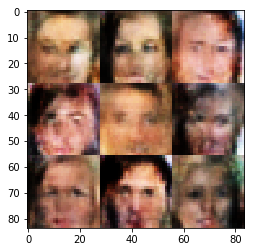

Epoch 1/5: steps 2110 Discriminator Loss: 1.0045... Generator Loss: 1.1516
Epoch 1/5: steps 2120 Discriminator Loss: 0.8056... Generator Loss: 1.2898
Epoch 1/5: steps 2130 Discriminator Loss: 0.9178... Generator Loss: 1.1133
Epoch 1/5: steps 2140 Discriminator Loss: 0.9539... Generator Loss: 0.9772
Epoch 1/5: steps 2150 Discriminator Loss: 1.0962... Generator Loss: 1.1902
Epoch 1/5: steps 2160 Discriminator Loss: 0.8488... Generator Loss: 1.6010
Epoch 1/5: steps 2170 Discriminator Loss: 0.8795... Generator Loss: 1.2867
Epoch 1/5: steps 2180 Discriminator Loss: 0.8884... Generator Loss: 1.2981
Epoch 1/5: steps 2190 Discriminator Loss: 0.9436... Generator Loss: 1.0672
Epoch 1/5: steps 2200 Discriminator Loss: 0.9788... Generator Loss: 1.1014


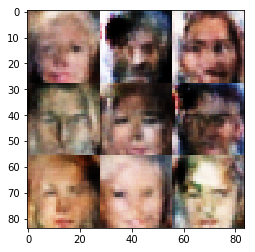

Epoch 1/5: steps 2210 Discriminator Loss: 0.7877... Generator Loss: 1.7675
Epoch 1/5: steps 2220 Discriminator Loss: 0.8685... Generator Loss: 1.2603
Epoch 1/5: steps 2230 Discriminator Loss: 1.2230... Generator Loss: 0.8161
Epoch 1/5: steps 2240 Discriminator Loss: 0.8406... Generator Loss: 1.3064
Epoch 1/5: steps 2250 Discriminator Loss: 1.0377... Generator Loss: 1.1556
Epoch 1/5: steps 2260 Discriminator Loss: 0.9562... Generator Loss: 1.0281
Epoch 1/5: steps 2270 Discriminator Loss: 0.8191... Generator Loss: 1.2047
Epoch 1/5: steps 2280 Discriminator Loss: 1.2370... Generator Loss: 1.4199
Epoch 1/5: steps 2290 Discriminator Loss: 0.8100... Generator Loss: 1.4208
Epoch 1/5: steps 2300 Discriminator Loss: 0.8805... Generator Loss: 1.1303


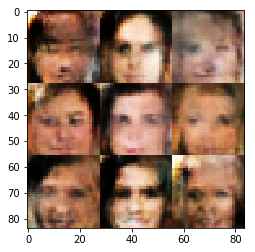

Epoch 1/5: steps 2310 Discriminator Loss: 0.7443... Generator Loss: 1.5167
Epoch 1/5: steps 2320 Discriminator Loss: 1.3850... Generator Loss: 1.8433
Epoch 1/5: steps 2330 Discriminator Loss: 0.8865... Generator Loss: 1.4610
Epoch 1/5: steps 2340 Discriminator Loss: 0.9709... Generator Loss: 1.0107
Epoch 1/5: steps 2350 Discriminator Loss: 0.9399... Generator Loss: 1.0346
Epoch 1/5: steps 2360 Discriminator Loss: 0.8802... Generator Loss: 1.0496
Epoch 1/5: steps 2370 Discriminator Loss: 1.0701... Generator Loss: 1.0976
Epoch 1/5: steps 2380 Discriminator Loss: 0.8650... Generator Loss: 1.1139
Epoch 1/5: steps 2390 Discriminator Loss: 0.9265... Generator Loss: 1.0121
Epoch 1/5: steps 2400 Discriminator Loss: 0.8798... Generator Loss: 1.2124


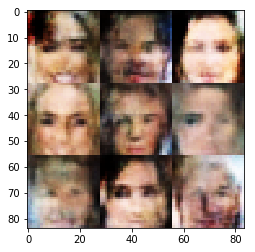

Epoch 1/5: steps 2410 Discriminator Loss: 0.9039... Generator Loss: 1.3857
Epoch 1/5: steps 2420 Discriminator Loss: 0.9149... Generator Loss: 1.1255
Epoch 1/5: steps 2430 Discriminator Loss: 0.9558... Generator Loss: 1.0085
Epoch 1/5: steps 2440 Discriminator Loss: 1.1456... Generator Loss: 0.7047
Epoch 1/5: steps 2450 Discriminator Loss: 1.0617... Generator Loss: 1.3263
Epoch 1/5: steps 2460 Discriminator Loss: 0.9767... Generator Loss: 1.0838
Epoch 1/5: steps 2470 Discriminator Loss: 1.0289... Generator Loss: 1.1450
Epoch 1/5: steps 2480 Discriminator Loss: 0.8839... Generator Loss: 1.2910
Epoch 1/5: steps 2490 Discriminator Loss: 1.0464... Generator Loss: 1.0776
Epoch 1/5: steps 2500 Discriminator Loss: 1.1890... Generator Loss: 1.0568


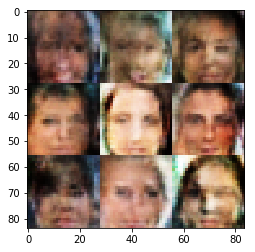

Epoch 1/5: steps 2510 Discriminator Loss: 1.0467... Generator Loss: 1.1386
Epoch 1/5: steps 2520 Discriminator Loss: 0.8851... Generator Loss: 1.3686
Epoch 1/5: steps 2530 Discriminator Loss: 0.8792... Generator Loss: 1.3103
Epoch 1/5: steps 2540 Discriminator Loss: 0.8878... Generator Loss: 1.3425
Epoch 1/5: steps 2550 Discriminator Loss: 1.5234... Generator Loss: 2.1268
Epoch 1/5: steps 2560 Discriminator Loss: 1.0437... Generator Loss: 1.1740
Epoch 1/5: steps 2570 Discriminator Loss: 0.8014... Generator Loss: 1.3091
Epoch 1/5: steps 2580 Discriminator Loss: 0.9126... Generator Loss: 1.1367
Epoch 1/5: steps 2590 Discriminator Loss: 1.0781... Generator Loss: 1.1467
Epoch 1/5: steps 2600 Discriminator Loss: 1.1383... Generator Loss: 1.0628


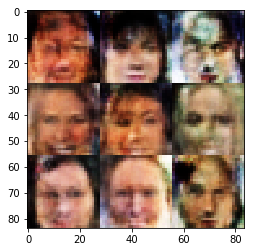

Epoch 1/5: steps 2610 Discriminator Loss: 0.9736... Generator Loss: 1.1083
Epoch 1/5: steps 2620 Discriminator Loss: 0.9819... Generator Loss: 1.1734
Epoch 1/5: steps 2630 Discriminator Loss: 0.8670... Generator Loss: 1.1155
Epoch 1/5: steps 2640 Discriminator Loss: 0.9931... Generator Loss: 1.0198
Epoch 1/5: steps 2650 Discriminator Loss: 0.9695... Generator Loss: 1.0126
Epoch 1/5: steps 2660 Discriminator Loss: 0.8855... Generator Loss: 1.2405
Epoch 1/5: steps 2670 Discriminator Loss: 1.0197... Generator Loss: 1.0158
Epoch 1/5: steps 2680 Discriminator Loss: 1.0212... Generator Loss: 0.9492
Epoch 1/5: steps 2690 Discriminator Loss: 1.3724... Generator Loss: 0.5827
Epoch 1/5: steps 2700 Discriminator Loss: 0.9989... Generator Loss: 1.0377


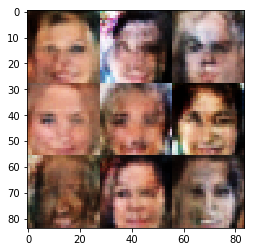

Epoch 1/5: steps 2710 Discriminator Loss: 0.9090... Generator Loss: 1.2326
Epoch 1/5: steps 2720 Discriminator Loss: 1.1263... Generator Loss: 0.9125
Epoch 1/5: steps 2730 Discriminator Loss: 1.1546... Generator Loss: 0.8710
Epoch 1/5: steps 2740 Discriminator Loss: 1.0119... Generator Loss: 1.1423
Epoch 1/5: steps 2750 Discriminator Loss: 0.9631... Generator Loss: 0.8769
Epoch 1/5: steps 2760 Discriminator Loss: 1.0670... Generator Loss: 1.0637
Epoch 1/5: steps 2770 Discriminator Loss: 1.0388... Generator Loss: 0.9868
Epoch 1/5: steps 2780 Discriminator Loss: 0.9986... Generator Loss: 1.2301
Epoch 1/5: steps 2790 Discriminator Loss: 1.0503... Generator Loss: 0.9005
Epoch 1/5: steps 2800 Discriminator Loss: 0.9775... Generator Loss: 1.2664


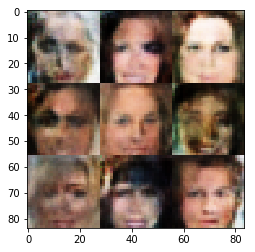

Epoch 1/5: steps 2810 Discriminator Loss: 0.9310... Generator Loss: 1.2207
Epoch 1/5: steps 2820 Discriminator Loss: 1.0302... Generator Loss: 0.9448
Epoch 1/5: steps 2830 Discriminator Loss: 1.1382... Generator Loss: 1.4231
Epoch 1/5: steps 2840 Discriminator Loss: 1.1332... Generator Loss: 0.7797
Epoch 1/5: steps 2850 Discriminator Loss: 1.0342... Generator Loss: 1.0305
Epoch 1/5: steps 2860 Discriminator Loss: 0.9311... Generator Loss: 1.2356
Epoch 1/5: steps 2870 Discriminator Loss: 0.8863... Generator Loss: 1.2796
Epoch 1/5: steps 2880 Discriminator Loss: 0.8710... Generator Loss: 1.4018
Epoch 1/5: steps 2890 Discriminator Loss: 0.9857... Generator Loss: 1.1766
Epoch 1/5: steps 2900 Discriminator Loss: 0.9634... Generator Loss: 1.0614


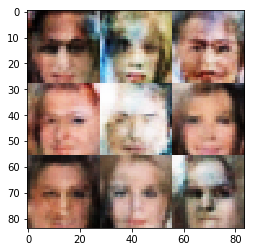

Epoch 1/5: steps 2910 Discriminator Loss: 1.0492... Generator Loss: 0.9054
Epoch 1/5: steps 2920 Discriminator Loss: 0.9216... Generator Loss: 1.3683
Epoch 1/5: steps 2930 Discriminator Loss: 0.9253... Generator Loss: 1.4036
Epoch 1/5: steps 2940 Discriminator Loss: 0.9400... Generator Loss: 1.1413
Epoch 1/5: steps 2950 Discriminator Loss: 1.0726... Generator Loss: 1.1738
Epoch 1/5: steps 2960 Discriminator Loss: 1.0203... Generator Loss: 0.9954
Epoch 1/5: steps 2970 Discriminator Loss: 1.0005... Generator Loss: 1.1842
Epoch 1/5: steps 2980 Discriminator Loss: 1.0594... Generator Loss: 0.7670
Epoch 1/5: steps 2990 Discriminator Loss: 0.9745... Generator Loss: 1.3319
Epoch 1/5: steps 3000 Discriminator Loss: 0.9236... Generator Loss: 1.1443


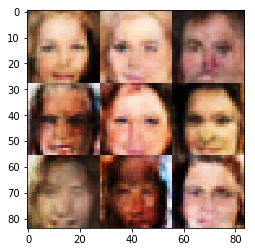

Epoch 1/5: steps 3010 Discriminator Loss: 1.2315... Generator Loss: 0.7986
Epoch 1/5: steps 3020 Discriminator Loss: 1.0439... Generator Loss: 0.9808
Epoch 1/5: steps 3030 Discriminator Loss: 1.1482... Generator Loss: 0.9569
Epoch 1/5: steps 3040 Discriminator Loss: 1.0568... Generator Loss: 1.0912
Epoch 1/5: steps 3050 Discriminator Loss: 0.9641... Generator Loss: 1.0761
Epoch 1/5: steps 3060 Discriminator Loss: 0.9607... Generator Loss: 1.4017
Epoch 1/5: steps 3070 Discriminator Loss: 1.0473... Generator Loss: 1.1858
Epoch 1/5: steps 3080 Discriminator Loss: 0.9647... Generator Loss: 1.1380
Epoch 1/5: steps 3090 Discriminator Loss: 0.8903... Generator Loss: 1.1073
Epoch 1/5: steps 3100 Discriminator Loss: 1.0502... Generator Loss: 0.9545


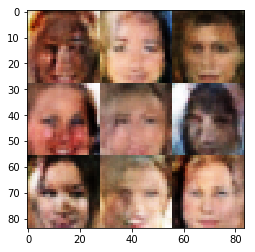

Epoch 1/5: steps 3110 Discriminator Loss: 0.9966... Generator Loss: 1.1361
Epoch 1/5: steps 3120 Discriminator Loss: 1.0542... Generator Loss: 1.0757
Epoch 1/5: steps 3130 Discriminator Loss: 0.9085... Generator Loss: 1.1598
Epoch 1/5: steps 3140 Discriminator Loss: 0.8577... Generator Loss: 1.4509
Epoch 1/5: steps 3150 Discriminator Loss: 1.0505... Generator Loss: 0.9161
Epoch 1/5: steps 3160 Discriminator Loss: 0.9571... Generator Loss: 0.9476
Epoch 2/5: steps 10 Discriminator Loss: 0.9513... Generator Loss: 1.0009
Epoch 2/5: steps 20 Discriminator Loss: 0.9089... Generator Loss: 1.0309
Epoch 2/5: steps 30 Discriminator Loss: 0.9648... Generator Loss: 0.9539
Epoch 2/5: steps 40 Discriminator Loss: 1.0128... Generator Loss: 1.3739
Epoch 2/5: steps 50 Discriminator Loss: 0.9731... Generator Loss: 1.2394
Epoch 2/5: steps 60 Discriminator Loss: 1.0640... Generator Loss: 1.1633
Epoch 2/5: steps 70 Discriminator Loss: 1.0442... Generator Loss: 0.9452
Epoch 2/5: steps 80 Discriminator Loss:

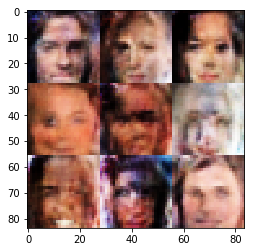

Epoch 2/5: steps 110 Discriminator Loss: 3.0456... Generator Loss: 3.6715
Epoch 2/5: steps 120 Discriminator Loss: 1.1878... Generator Loss: 0.8886
Epoch 2/5: steps 130 Discriminator Loss: 1.0612... Generator Loss: 1.0380
Epoch 2/5: steps 140 Discriminator Loss: 0.9800... Generator Loss: 1.2457
Epoch 2/5: steps 150 Discriminator Loss: 1.0058... Generator Loss: 1.2075
Epoch 2/5: steps 160 Discriminator Loss: 0.8951... Generator Loss: 1.4459
Epoch 2/5: steps 170 Discriminator Loss: 1.0948... Generator Loss: 0.8462
Epoch 2/5: steps 180 Discriminator Loss: 1.0242... Generator Loss: 0.9555
Epoch 2/5: steps 190 Discriminator Loss: 0.9894... Generator Loss: 1.0599
Epoch 2/5: steps 200 Discriminator Loss: 1.0931... Generator Loss: 0.8677


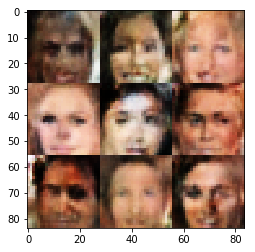

Epoch 2/5: steps 210 Discriminator Loss: 1.1787... Generator Loss: 1.1793
Epoch 2/5: steps 220 Discriminator Loss: 1.0963... Generator Loss: 0.9211
Epoch 2/5: steps 230 Discriminator Loss: 1.0963... Generator Loss: 0.9769
Epoch 2/5: steps 240 Discriminator Loss: 1.0181... Generator Loss: 1.1393
Epoch 2/5: steps 250 Discriminator Loss: 1.1949... Generator Loss: 0.7207
Epoch 2/5: steps 260 Discriminator Loss: 1.0530... Generator Loss: 1.0139
Epoch 2/5: steps 270 Discriminator Loss: 0.9681... Generator Loss: 1.1447
Epoch 2/5: steps 280 Discriminator Loss: 1.0185... Generator Loss: 1.1123
Epoch 2/5: steps 290 Discriminator Loss: 0.8713... Generator Loss: 1.4731
Epoch 2/5: steps 300 Discriminator Loss: 1.0988... Generator Loss: 1.0868


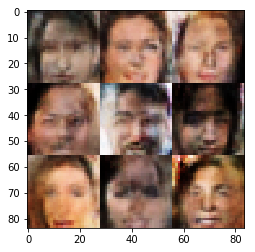

Epoch 2/5: steps 310 Discriminator Loss: 0.9443... Generator Loss: 1.1756
Epoch 2/5: steps 320 Discriminator Loss: 0.9673... Generator Loss: 1.0369
Epoch 2/5: steps 330 Discriminator Loss: 1.0226... Generator Loss: 0.7214
Epoch 2/5: steps 340 Discriminator Loss: 1.1452... Generator Loss: 0.9638
Epoch 2/5: steps 350 Discriminator Loss: 1.0417... Generator Loss: 1.1911
Epoch 2/5: steps 360 Discriminator Loss: 1.0059... Generator Loss: 0.9069
Epoch 2/5: steps 370 Discriminator Loss: 1.0774... Generator Loss: 1.1252
Epoch 2/5: steps 380 Discriminator Loss: 0.8755... Generator Loss: 1.2493
Epoch 2/5: steps 390 Discriminator Loss: 1.2082... Generator Loss: 1.0348
Epoch 2/5: steps 400 Discriminator Loss: 1.0973... Generator Loss: 0.9458


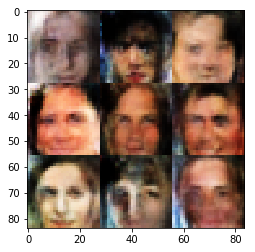

Epoch 2/5: steps 410 Discriminator Loss: 1.0749... Generator Loss: 0.9217
Epoch 2/5: steps 420 Discriminator Loss: 0.9351... Generator Loss: 1.3273
Epoch 2/5: steps 430 Discriminator Loss: 1.1782... Generator Loss: 1.1621
Epoch 2/5: steps 440 Discriminator Loss: 1.1261... Generator Loss: 0.8610
Epoch 2/5: steps 450 Discriminator Loss: 1.0176... Generator Loss: 1.0962
Epoch 2/5: steps 460 Discriminator Loss: 1.0881... Generator Loss: 0.9081
Epoch 2/5: steps 470 Discriminator Loss: 0.9345... Generator Loss: 1.1950
Epoch 2/5: steps 480 Discriminator Loss: 1.1722... Generator Loss: 1.2263
Epoch 2/5: steps 490 Discriminator Loss: 1.0826... Generator Loss: 1.0263
Epoch 2/5: steps 500 Discriminator Loss: 0.7970... Generator Loss: 1.9242


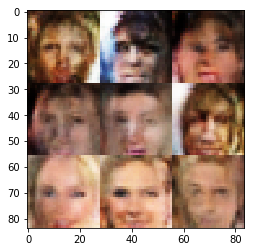

Epoch 2/5: steps 510 Discriminator Loss: 1.1403... Generator Loss: 0.9996
Epoch 2/5: steps 520 Discriminator Loss: 1.0595... Generator Loss: 1.0553
Epoch 2/5: steps 530 Discriminator Loss: 0.9668... Generator Loss: 1.6110
Epoch 2/5: steps 540 Discriminator Loss: 0.9805... Generator Loss: 0.9978
Epoch 2/5: steps 550 Discriminator Loss: 1.0879... Generator Loss: 0.9124
Epoch 2/5: steps 560 Discriminator Loss: 1.0406... Generator Loss: 0.8122
Epoch 2/5: steps 570 Discriminator Loss: 1.0343... Generator Loss: 0.9132
Epoch 2/5: steps 580 Discriminator Loss: 1.7881... Generator Loss: 1.8113
Epoch 2/5: steps 590 Discriminator Loss: 1.1026... Generator Loss: 0.9518
Epoch 2/5: steps 600 Discriminator Loss: 1.1224... Generator Loss: 1.0254


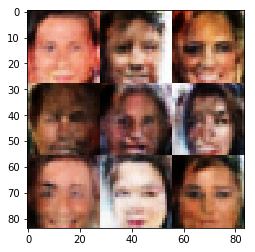

Epoch 2/5: steps 610 Discriminator Loss: 1.1319... Generator Loss: 0.9554
Epoch 2/5: steps 620 Discriminator Loss: 1.1312... Generator Loss: 1.0007
Epoch 2/5: steps 630 Discriminator Loss: 1.1061... Generator Loss: 0.8859
Epoch 2/5: steps 640 Discriminator Loss: 1.1834... Generator Loss: 0.8839
Epoch 2/5: steps 650 Discriminator Loss: 1.0110... Generator Loss: 1.1787
Epoch 2/5: steps 660 Discriminator Loss: 1.0788... Generator Loss: 1.2425
Epoch 2/5: steps 670 Discriminator Loss: 1.0342... Generator Loss: 1.0103
Epoch 2/5: steps 680 Discriminator Loss: 1.0954... Generator Loss: 0.8673
Epoch 2/5: steps 690 Discriminator Loss: 1.1233... Generator Loss: 1.1648
Epoch 2/5: steps 700 Discriminator Loss: 1.0804... Generator Loss: 1.0673


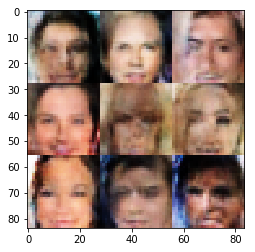

Epoch 2/5: steps 710 Discriminator Loss: 1.0386... Generator Loss: 1.1368
Epoch 2/5: steps 720 Discriminator Loss: 1.0726... Generator Loss: 0.9059
Epoch 2/5: steps 730 Discriminator Loss: 1.1784... Generator Loss: 0.8919
Epoch 2/5: steps 740 Discriminator Loss: 1.0021... Generator Loss: 1.0229
Epoch 2/5: steps 750 Discriminator Loss: 1.0138... Generator Loss: 1.3893
Epoch 2/5: steps 760 Discriminator Loss: 0.9063... Generator Loss: 1.3921
Epoch 2/5: steps 770 Discriminator Loss: 0.9828... Generator Loss: 1.0859
Epoch 2/5: steps 780 Discriminator Loss: 1.0399... Generator Loss: 1.1234
Epoch 2/5: steps 790 Discriminator Loss: 0.9523... Generator Loss: 1.4954
Epoch 2/5: steps 800 Discriminator Loss: 1.0931... Generator Loss: 1.0389


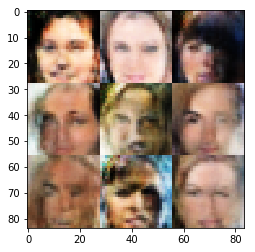

Epoch 2/5: steps 810 Discriminator Loss: 1.1590... Generator Loss: 1.0617
Epoch 2/5: steps 820 Discriminator Loss: 1.0195... Generator Loss: 0.8695
Epoch 2/5: steps 830 Discriminator Loss: 1.0365... Generator Loss: 0.9659
Epoch 2/5: steps 840 Discriminator Loss: 1.0653... Generator Loss: 0.9926
Epoch 2/5: steps 850 Discriminator Loss: 0.9614... Generator Loss: 1.2858
Epoch 2/5: steps 860 Discriminator Loss: 1.1676... Generator Loss: 0.9887
Epoch 2/5: steps 870 Discriminator Loss: 1.5824... Generator Loss: 1.8110
Epoch 2/5: steps 880 Discriminator Loss: 1.0776... Generator Loss: 0.8602
Epoch 2/5: steps 890 Discriminator Loss: 1.1405... Generator Loss: 0.9194
Epoch 2/5: steps 900 Discriminator Loss: 1.1150... Generator Loss: 0.8233


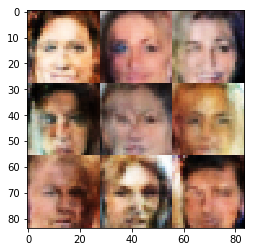

Epoch 2/5: steps 910 Discriminator Loss: 1.0203... Generator Loss: 0.9643
Epoch 2/5: steps 920 Discriminator Loss: 1.1321... Generator Loss: 0.7253
Epoch 2/5: steps 930 Discriminator Loss: 1.1296... Generator Loss: 0.9984
Epoch 2/5: steps 940 Discriminator Loss: 1.0927... Generator Loss: 0.9222
Epoch 2/5: steps 950 Discriminator Loss: 1.0108... Generator Loss: 1.1808
Epoch 2/5: steps 960 Discriminator Loss: 1.1047... Generator Loss: 1.0124
Epoch 2/5: steps 970 Discriminator Loss: 1.1749... Generator Loss: 0.8302
Epoch 2/5: steps 980 Discriminator Loss: 1.0707... Generator Loss: 0.9576
Epoch 2/5: steps 990 Discriminator Loss: 1.1004... Generator Loss: 1.1854
Epoch 2/5: steps 1000 Discriminator Loss: 1.1337... Generator Loss: 0.9296


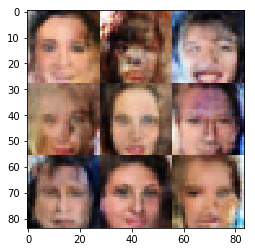

Epoch 2/5: steps 1010 Discriminator Loss: 0.9925... Generator Loss: 1.1322
Epoch 2/5: steps 1020 Discriminator Loss: 1.3057... Generator Loss: 0.7724
Epoch 2/5: steps 1030 Discriminator Loss: 1.1334... Generator Loss: 0.7906
Epoch 2/5: steps 1040 Discriminator Loss: 1.0217... Generator Loss: 1.2006
Epoch 2/5: steps 1050 Discriminator Loss: 0.9193... Generator Loss: 1.1025
Epoch 2/5: steps 1060 Discriminator Loss: 0.9986... Generator Loss: 1.0013
Epoch 2/5: steps 1070 Discriminator Loss: 1.0753... Generator Loss: 1.0681
Epoch 2/5: steps 1080 Discriminator Loss: 1.0625... Generator Loss: 0.9943
Epoch 2/5: steps 1090 Discriminator Loss: 1.1039... Generator Loss: 0.9702
Epoch 2/5: steps 1100 Discriminator Loss: 0.8976... Generator Loss: 1.3294


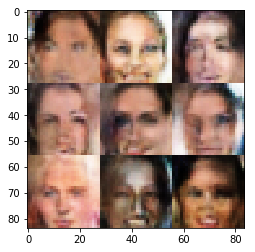

Epoch 2/5: steps 1110 Discriminator Loss: 1.2375... Generator Loss: 0.9416
Epoch 2/5: steps 1120 Discriminator Loss: 1.0151... Generator Loss: 1.3003
Epoch 2/5: steps 1130 Discriminator Loss: 0.9982... Generator Loss: 0.9342
Epoch 2/5: steps 1140 Discriminator Loss: 0.9687... Generator Loss: 1.1147
Epoch 2/5: steps 1150 Discriminator Loss: 1.0940... Generator Loss: 1.0219
Epoch 2/5: steps 1160 Discriminator Loss: 0.9490... Generator Loss: 1.2876
Epoch 2/5: steps 1170 Discriminator Loss: 1.1351... Generator Loss: 1.1651
Epoch 2/5: steps 1180 Discriminator Loss: 1.1168... Generator Loss: 0.9185
Epoch 2/5: steps 1190 Discriminator Loss: 1.0765... Generator Loss: 1.0936
Epoch 2/5: steps 1200 Discriminator Loss: 0.9922... Generator Loss: 0.8665


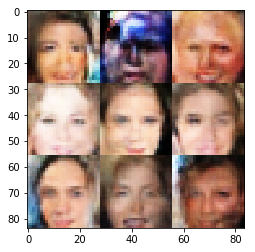

Epoch 2/5: steps 1210 Discriminator Loss: 1.0865... Generator Loss: 1.0124
Epoch 2/5: steps 1220 Discriminator Loss: 0.8451... Generator Loss: 1.5676
Epoch 2/5: steps 1230 Discriminator Loss: 1.1435... Generator Loss: 0.8553
Epoch 2/5: steps 1240 Discriminator Loss: 1.1520... Generator Loss: 1.0540
Epoch 2/5: steps 1250 Discriminator Loss: 0.9916... Generator Loss: 1.0568
Epoch 2/5: steps 1260 Discriminator Loss: 1.0413... Generator Loss: 0.9512
Epoch 2/5: steps 1270 Discriminator Loss: 1.0855... Generator Loss: 1.1726
Epoch 2/5: steps 1280 Discriminator Loss: 1.0154... Generator Loss: 0.8500
Epoch 2/5: steps 1290 Discriminator Loss: 1.2460... Generator Loss: 1.3605
Epoch 2/5: steps 1300 Discriminator Loss: 1.1871... Generator Loss: 0.9588


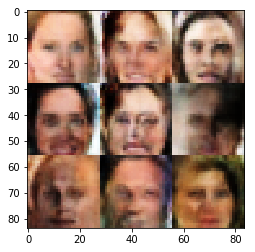

Epoch 2/5: steps 1310 Discriminator Loss: 1.0435... Generator Loss: 1.1110
Epoch 2/5: steps 1320 Discriminator Loss: 1.0858... Generator Loss: 1.0787
Epoch 2/5: steps 1330 Discriminator Loss: 0.9503... Generator Loss: 1.1999
Epoch 2/5: steps 1340 Discriminator Loss: 1.2261... Generator Loss: 0.9566
Epoch 2/5: steps 1350 Discriminator Loss: 1.1349... Generator Loss: 1.0333
Epoch 2/5: steps 1360 Discriminator Loss: 1.0182... Generator Loss: 1.0353
Epoch 2/5: steps 1370 Discriminator Loss: 1.0615... Generator Loss: 1.0074
Epoch 2/5: steps 1380 Discriminator Loss: 1.1485... Generator Loss: 0.9712
Epoch 2/5: steps 1390 Discriminator Loss: 0.9966... Generator Loss: 0.9826
Epoch 2/5: steps 1400 Discriminator Loss: 0.8796... Generator Loss: 1.4517


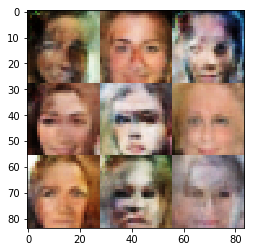

Epoch 2/5: steps 1410 Discriminator Loss: 1.0986... Generator Loss: 1.0521
Epoch 2/5: steps 1420 Discriminator Loss: 1.1021... Generator Loss: 0.8807
Epoch 2/5: steps 1430 Discriminator Loss: 1.2716... Generator Loss: 1.1563
Epoch 2/5: steps 1440 Discriminator Loss: 1.1129... Generator Loss: 0.7443
Epoch 2/5: steps 1450 Discriminator Loss: 1.1086... Generator Loss: 0.9842
Epoch 2/5: steps 1460 Discriminator Loss: 1.0292... Generator Loss: 0.8766
Epoch 2/5: steps 1470 Discriminator Loss: 1.0987... Generator Loss: 0.9130
Epoch 2/5: steps 1480 Discriminator Loss: 1.0725... Generator Loss: 1.0647
Epoch 2/5: steps 1490 Discriminator Loss: 1.0478... Generator Loss: 0.9048
Epoch 2/5: steps 1500 Discriminator Loss: 1.2075... Generator Loss: 0.7230


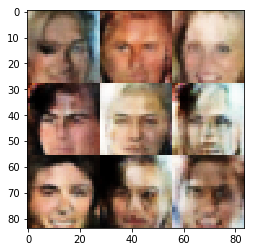

Epoch 2/5: steps 1510 Discriminator Loss: 1.1982... Generator Loss: 0.9728
Epoch 2/5: steps 1520 Discriminator Loss: 0.9461... Generator Loss: 1.4512
Epoch 2/5: steps 1530 Discriminator Loss: 0.7667... Generator Loss: 1.4456
Epoch 2/5: steps 1540 Discriminator Loss: 2.2503... Generator Loss: 2.2863
Epoch 2/5: steps 1550 Discriminator Loss: 1.3503... Generator Loss: 0.7886
Epoch 2/5: steps 1560 Discriminator Loss: 1.1599... Generator Loss: 0.8844
Epoch 2/5: steps 1570 Discriminator Loss: 1.0857... Generator Loss: 0.8434
Epoch 2/5: steps 1580 Discriminator Loss: 1.0826... Generator Loss: 1.0018
Epoch 2/5: steps 1590 Discriminator Loss: 1.1283... Generator Loss: 0.9759
Epoch 2/5: steps 1600 Discriminator Loss: 1.0111... Generator Loss: 0.9273


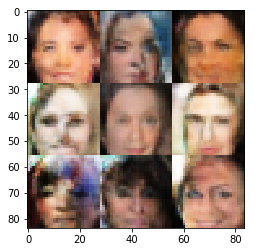

Epoch 2/5: steps 1610 Discriminator Loss: 1.1421... Generator Loss: 0.9763
Epoch 2/5: steps 1620 Discriminator Loss: 1.0269... Generator Loss: 1.1584
Epoch 2/5: steps 1630 Discriminator Loss: 1.1810... Generator Loss: 1.0005
Epoch 2/5: steps 1640 Discriminator Loss: 1.1050... Generator Loss: 1.0101
Epoch 2/5: steps 1650 Discriminator Loss: 1.1787... Generator Loss: 0.8538
Epoch 2/5: steps 1660 Discriminator Loss: 1.0444... Generator Loss: 1.0301
Epoch 2/5: steps 1670 Discriminator Loss: 1.1330... Generator Loss: 0.8816
Epoch 2/5: steps 1680 Discriminator Loss: 1.1359... Generator Loss: 1.0319
Epoch 2/5: steps 1690 Discriminator Loss: 1.0212... Generator Loss: 0.9861
Epoch 2/5: steps 1700 Discriminator Loss: 1.0600... Generator Loss: 1.1594


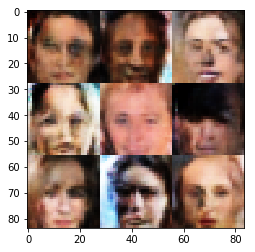

Epoch 2/5: steps 1710 Discriminator Loss: 1.1246... Generator Loss: 1.4169
Epoch 2/5: steps 1720 Discriminator Loss: 1.1355... Generator Loss: 1.3011
Epoch 2/5: steps 1730 Discriminator Loss: 1.0401... Generator Loss: 1.1416
Epoch 2/5: steps 1740 Discriminator Loss: 1.1526... Generator Loss: 1.0736
Epoch 2/5: steps 1750 Discriminator Loss: 1.1911... Generator Loss: 0.8950
Epoch 2/5: steps 1760 Discriminator Loss: 1.0609... Generator Loss: 0.8418
Epoch 2/5: steps 1770 Discriminator Loss: 1.0770... Generator Loss: 1.0011
Epoch 2/5: steps 1780 Discriminator Loss: 1.1764... Generator Loss: 0.9090
Epoch 2/5: steps 1790 Discriminator Loss: 1.1345... Generator Loss: 1.0283
Epoch 2/5: steps 1800 Discriminator Loss: 1.0057... Generator Loss: 0.8506


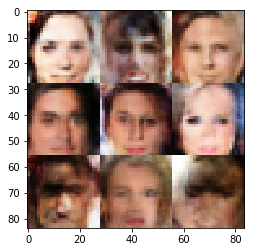

Epoch 2/5: steps 1810 Discriminator Loss: 1.0571... Generator Loss: 1.0817
Epoch 2/5: steps 1820 Discriminator Loss: 1.1772... Generator Loss: 0.9384
Epoch 2/5: steps 1830 Discriminator Loss: 0.9982... Generator Loss: 0.8924
Epoch 2/5: steps 1840 Discriminator Loss: 1.1435... Generator Loss: 1.0951
Epoch 2/5: steps 1850 Discriminator Loss: 1.1126... Generator Loss: 1.1564
Epoch 2/5: steps 1860 Discriminator Loss: 1.1151... Generator Loss: 0.8697
Epoch 2/5: steps 1870 Discriminator Loss: 1.1761... Generator Loss: 0.8173
Epoch 2/5: steps 1880 Discriminator Loss: 1.0994... Generator Loss: 1.1629
Epoch 2/5: steps 1890 Discriminator Loss: 0.9068... Generator Loss: 1.4301
Epoch 2/5: steps 1900 Discriminator Loss: 1.1656... Generator Loss: 0.9998


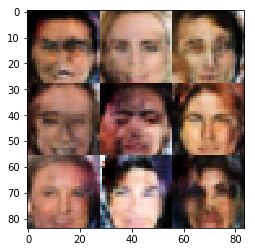

Epoch 2/5: steps 1910 Discriminator Loss: 1.0637... Generator Loss: 1.0236
Epoch 2/5: steps 1920 Discriminator Loss: 1.0786... Generator Loss: 0.9556
Epoch 2/5: steps 1930 Discriminator Loss: 1.0984... Generator Loss: 0.9896
Epoch 2/5: steps 1940 Discriminator Loss: 1.1422... Generator Loss: 0.8431
Epoch 2/5: steps 1950 Discriminator Loss: 1.0154... Generator Loss: 1.1697
Epoch 2/5: steps 1960 Discriminator Loss: 1.1184... Generator Loss: 0.9380
Epoch 2/5: steps 1970 Discriminator Loss: 1.0564... Generator Loss: 1.2006
Epoch 2/5: steps 1980 Discriminator Loss: 1.0582... Generator Loss: 1.0983
Epoch 2/5: steps 1990 Discriminator Loss: 1.0233... Generator Loss: 1.1262
Epoch 2/5: steps 2000 Discriminator Loss: 1.0882... Generator Loss: 1.0111


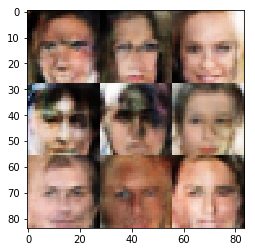

Epoch 2/5: steps 2010 Discriminator Loss: 1.1081... Generator Loss: 0.8593
Epoch 2/5: steps 2020 Discriminator Loss: 1.0056... Generator Loss: 0.8846
Epoch 2/5: steps 2030 Discriminator Loss: 1.1476... Generator Loss: 0.9668
Epoch 2/5: steps 2040 Discriminator Loss: 1.3656... Generator Loss: 0.5746
Epoch 2/5: steps 2050 Discriminator Loss: 1.5879... Generator Loss: 1.6032
Epoch 2/5: steps 2060 Discriminator Loss: 1.3245... Generator Loss: 0.7777
Epoch 2/5: steps 2070 Discriminator Loss: 1.2364... Generator Loss: 0.9551
Epoch 2/5: steps 2080 Discriminator Loss: 1.0140... Generator Loss: 0.9944
Epoch 2/5: steps 2090 Discriminator Loss: 1.1997... Generator Loss: 0.9416
Epoch 2/5: steps 2100 Discriminator Loss: 1.1552... Generator Loss: 0.8777


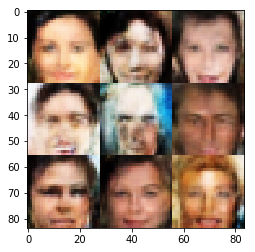

Epoch 2/5: steps 2110 Discriminator Loss: 1.1913... Generator Loss: 0.9290
Epoch 2/5: steps 2120 Discriminator Loss: 1.1388... Generator Loss: 1.0006
Epoch 2/5: steps 2130 Discriminator Loss: 1.2017... Generator Loss: 0.9576
Epoch 2/5: steps 2140 Discriminator Loss: 1.1217... Generator Loss: 0.9352
Epoch 2/5: steps 2150 Discriminator Loss: 1.0828... Generator Loss: 1.2065
Epoch 2/5: steps 2160 Discriminator Loss: 1.1722... Generator Loss: 1.0165
Epoch 2/5: steps 2170 Discriminator Loss: 1.0227... Generator Loss: 1.1053
Epoch 2/5: steps 2180 Discriminator Loss: 1.2459... Generator Loss: 0.9310
Epoch 2/5: steps 2190 Discriminator Loss: 1.1507... Generator Loss: 0.9423
Epoch 2/5: steps 2200 Discriminator Loss: 1.1225... Generator Loss: 0.8286


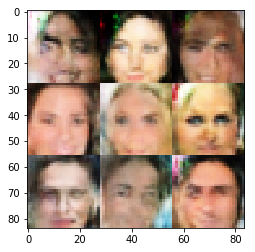

Epoch 2/5: steps 2210 Discriminator Loss: 1.1059... Generator Loss: 1.0943
Epoch 2/5: steps 2220 Discriminator Loss: 1.1094... Generator Loss: 1.0923
Epoch 2/5: steps 2230 Discriminator Loss: 1.1882... Generator Loss: 0.9035
Epoch 2/5: steps 2240 Discriminator Loss: 1.3371... Generator Loss: 1.2041
Epoch 2/5: steps 2250 Discriminator Loss: 1.1694... Generator Loss: 0.9930
Epoch 2/5: steps 2260 Discriminator Loss: 1.0600... Generator Loss: 1.2182
Epoch 2/5: steps 2270 Discriminator Loss: 1.1322... Generator Loss: 0.8398
Epoch 2/5: steps 2280 Discriminator Loss: 1.1246... Generator Loss: 0.9094
Epoch 2/5: steps 2290 Discriminator Loss: 1.0136... Generator Loss: 1.1405
Epoch 2/5: steps 2300 Discriminator Loss: 0.9179... Generator Loss: 1.2044


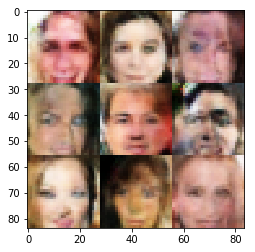

Epoch 2/5: steps 2310 Discriminator Loss: 1.0941... Generator Loss: 0.9767
Epoch 2/5: steps 2320 Discriminator Loss: 1.1175... Generator Loss: 0.7704
Epoch 2/5: steps 2330 Discriminator Loss: 1.1160... Generator Loss: 0.9417
Epoch 2/5: steps 2340 Discriminator Loss: 1.1138... Generator Loss: 0.9113
Epoch 2/5: steps 2350 Discriminator Loss: 1.1108... Generator Loss: 1.1997
Epoch 2/5: steps 2360 Discriminator Loss: 1.0514... Generator Loss: 1.0067
Epoch 2/5: steps 2370 Discriminator Loss: 1.1423... Generator Loss: 0.7875
Epoch 2/5: steps 2380 Discriminator Loss: 1.0557... Generator Loss: 1.2864
Epoch 2/5: steps 2390 Discriminator Loss: 1.1677... Generator Loss: 0.8228
Epoch 2/5: steps 2400 Discriminator Loss: 0.9502... Generator Loss: 1.4423


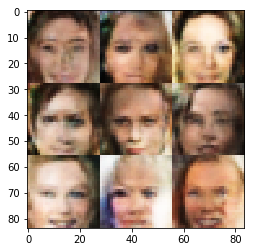

Epoch 2/5: steps 2410 Discriminator Loss: 1.1468... Generator Loss: 0.7225
Epoch 2/5: steps 2420 Discriminator Loss: 0.9365... Generator Loss: 1.3546
Epoch 2/5: steps 2430 Discriminator Loss: 1.0938... Generator Loss: 0.9526
Epoch 2/5: steps 2440 Discriminator Loss: 1.0048... Generator Loss: 1.1066
Epoch 2/5: steps 2450 Discriminator Loss: 1.1325... Generator Loss: 1.0597
Epoch 2/5: steps 2460 Discriminator Loss: 1.0915... Generator Loss: 1.0232
Epoch 2/5: steps 2470 Discriminator Loss: 1.0709... Generator Loss: 0.9598
Epoch 2/5: steps 2480 Discriminator Loss: 1.0864... Generator Loss: 0.9559
Epoch 2/5: steps 2490 Discriminator Loss: 1.0797... Generator Loss: 1.0110
Epoch 2/5: steps 2500 Discriminator Loss: 1.0041... Generator Loss: 1.1867


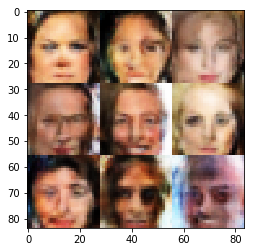

Epoch 2/5: steps 2510 Discriminator Loss: 1.1658... Generator Loss: 1.1304
Epoch 2/5: steps 2520 Discriminator Loss: 1.0764... Generator Loss: 0.9249
Epoch 2/5: steps 2530 Discriminator Loss: 1.1163... Generator Loss: 1.0690
Epoch 2/5: steps 2540 Discriminator Loss: 1.1743... Generator Loss: 0.9240
Epoch 2/5: steps 2550 Discriminator Loss: 1.2223... Generator Loss: 0.7754
Epoch 2/5: steps 2560 Discriminator Loss: 1.0612... Generator Loss: 1.3221
Epoch 2/5: steps 2570 Discriminator Loss: 1.1526... Generator Loss: 0.8322
Epoch 2/5: steps 2580 Discriminator Loss: 1.1155... Generator Loss: 1.0310
Epoch 2/5: steps 2590 Discriminator Loss: 1.2661... Generator Loss: 0.8686
Epoch 2/5: steps 2600 Discriminator Loss: 1.0793... Generator Loss: 1.0791


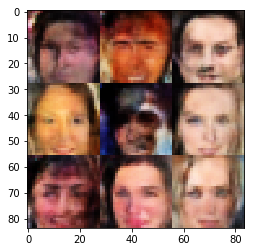

Epoch 2/5: steps 2610 Discriminator Loss: 1.1604... Generator Loss: 0.9674
Epoch 2/5: steps 2620 Discriminator Loss: 0.9836... Generator Loss: 1.0764
Epoch 2/5: steps 2630 Discriminator Loss: 1.1999... Generator Loss: 0.8016
Epoch 2/5: steps 2640 Discriminator Loss: 1.2235... Generator Loss: 0.8673
Epoch 2/5: steps 2650 Discriminator Loss: 1.0990... Generator Loss: 1.0154
Epoch 2/5: steps 2660 Discriminator Loss: 1.0070... Generator Loss: 1.0738
Epoch 2/5: steps 2670 Discriminator Loss: 1.2557... Generator Loss: 1.0117
Epoch 2/5: steps 2680 Discriminator Loss: 1.1117... Generator Loss: 1.1468
Epoch 2/5: steps 2690 Discriminator Loss: 1.1933... Generator Loss: 0.8885
Epoch 2/5: steps 2700 Discriminator Loss: 1.0683... Generator Loss: 0.8789


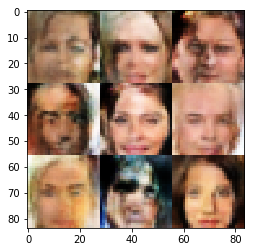

Epoch 2/5: steps 2710 Discriminator Loss: 1.0433... Generator Loss: 1.0422
Epoch 2/5: steps 2720 Discriminator Loss: 1.1983... Generator Loss: 0.8647
Epoch 2/5: steps 2730 Discriminator Loss: 1.2751... Generator Loss: 0.8407
Epoch 2/5: steps 2740 Discriminator Loss: 1.1188... Generator Loss: 0.9770
Epoch 2/5: steps 2750 Discriminator Loss: 1.1363... Generator Loss: 0.9327
Epoch 2/5: steps 2760 Discriminator Loss: 1.3099... Generator Loss: 0.7773
Epoch 2/5: steps 2770 Discriminator Loss: 1.0886... Generator Loss: 1.0346
Epoch 2/5: steps 2780 Discriminator Loss: 0.9903... Generator Loss: 1.0998
Epoch 2/5: steps 2790 Discriminator Loss: 1.1443... Generator Loss: 0.9055
Epoch 2/5: steps 2800 Discriminator Loss: 1.1750... Generator Loss: 1.0609


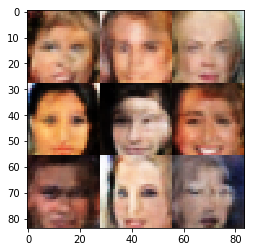

Epoch 2/5: steps 2810 Discriminator Loss: 1.3567... Generator Loss: 0.6405
Epoch 2/5: steps 2820 Discriminator Loss: 1.1615... Generator Loss: 0.9730
Epoch 2/5: steps 2830 Discriminator Loss: 1.0391... Generator Loss: 1.0735
Epoch 2/5: steps 2840 Discriminator Loss: 1.0792... Generator Loss: 1.3615
Epoch 2/5: steps 2850 Discriminator Loss: 1.2196... Generator Loss: 0.9844
Epoch 2/5: steps 2860 Discriminator Loss: 1.1082... Generator Loss: 1.0550
Epoch 2/5: steps 2870 Discriminator Loss: 1.1360... Generator Loss: 0.7489
Epoch 2/5: steps 2880 Discriminator Loss: 1.1232... Generator Loss: 1.0916
Epoch 2/5: steps 2890 Discriminator Loss: 1.2339... Generator Loss: 0.9622
Epoch 2/5: steps 2900 Discriminator Loss: 1.2084... Generator Loss: 0.9743


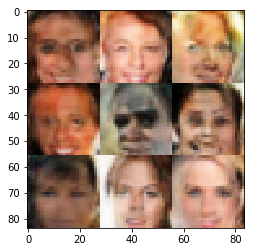

Epoch 2/5: steps 2910 Discriminator Loss: 1.1557... Generator Loss: 0.8364
Epoch 2/5: steps 2920 Discriminator Loss: 1.1478... Generator Loss: 0.8858
Epoch 2/5: steps 2930 Discriminator Loss: 1.0860... Generator Loss: 0.9280
Epoch 2/5: steps 2940 Discriminator Loss: 1.1649... Generator Loss: 0.9621
Epoch 2/5: steps 2950 Discriminator Loss: 1.2830... Generator Loss: 1.0055
Epoch 2/5: steps 2960 Discriminator Loss: 1.0597... Generator Loss: 1.2126
Epoch 2/5: steps 2970 Discriminator Loss: 1.1978... Generator Loss: 1.0878
Epoch 2/5: steps 2980 Discriminator Loss: 1.0449... Generator Loss: 0.9444
Epoch 2/5: steps 2990 Discriminator Loss: 1.1401... Generator Loss: 1.1263
Epoch 2/5: steps 3000 Discriminator Loss: 1.1488... Generator Loss: 1.0040


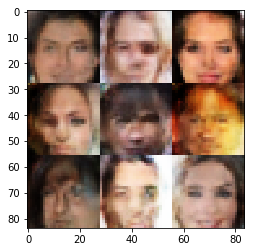

Epoch 2/5: steps 3010 Discriminator Loss: 1.2629... Generator Loss: 0.9285
Epoch 2/5: steps 3020 Discriminator Loss: 1.1576... Generator Loss: 0.8187
Epoch 2/5: steps 3030 Discriminator Loss: 1.1451... Generator Loss: 1.1741
Epoch 2/5: steps 3040 Discriminator Loss: 1.1797... Generator Loss: 0.8137
Epoch 2/5: steps 3050 Discriminator Loss: 1.1760... Generator Loss: 0.8652
Epoch 2/5: steps 3060 Discriminator Loss: 1.1502... Generator Loss: 0.8373
Epoch 2/5: steps 3070 Discriminator Loss: 1.0120... Generator Loss: 1.0700
Epoch 2/5: steps 3080 Discriminator Loss: 0.9827... Generator Loss: 1.0101
Epoch 2/5: steps 3090 Discriminator Loss: 1.1742... Generator Loss: 0.8963
Epoch 2/5: steps 3100 Discriminator Loss: 1.1988... Generator Loss: 0.9051


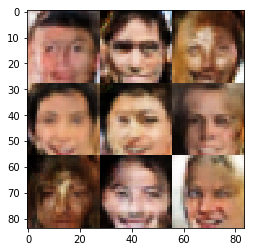

Epoch 2/5: steps 3110 Discriminator Loss: 1.3447... Generator Loss: 1.1558
Epoch 2/5: steps 3120 Discriminator Loss: 1.2030... Generator Loss: 0.9113
Epoch 2/5: steps 3130 Discriminator Loss: 1.1507... Generator Loss: 1.1441
Epoch 2/5: steps 3140 Discriminator Loss: 1.3306... Generator Loss: 0.6585
Epoch 2/5: steps 3150 Discriminator Loss: 1.1490... Generator Loss: 0.9547
Epoch 2/5: steps 3160 Discriminator Loss: 1.0753... Generator Loss: 0.9091
Epoch 3/5: steps 10 Discriminator Loss: 1.2107... Generator Loss: 1.1816
Epoch 3/5: steps 20 Discriminator Loss: 1.0272... Generator Loss: 0.8997
Epoch 3/5: steps 30 Discriminator Loss: 1.1334... Generator Loss: 1.0019
Epoch 3/5: steps 40 Discriminator Loss: 1.3026... Generator Loss: 0.7344
Epoch 3/5: steps 50 Discriminator Loss: 1.1740... Generator Loss: 1.1280
Epoch 3/5: steps 60 Discriminator Loss: 0.9640... Generator Loss: 1.2134
Epoch 3/5: steps 70 Discriminator Loss: 1.2714... Generator Loss: 0.9206
Epoch 3/5: steps 80 Discriminator Loss:

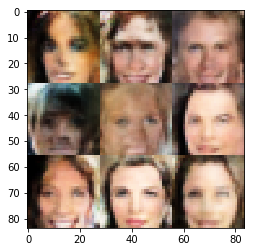

Epoch 3/5: steps 110 Discriminator Loss: 1.1160... Generator Loss: 1.1118
Epoch 3/5: steps 120 Discriminator Loss: 1.0868... Generator Loss: 0.9585
Epoch 3/5: steps 130 Discriminator Loss: 1.0294... Generator Loss: 0.8146
Epoch 3/5: steps 140 Discriminator Loss: 1.0824... Generator Loss: 0.8389
Epoch 3/5: steps 150 Discriminator Loss: 1.0946... Generator Loss: 1.0828
Epoch 3/5: steps 160 Discriminator Loss: 1.0888... Generator Loss: 0.7163
Epoch 3/5: steps 170 Discriminator Loss: 1.1781... Generator Loss: 0.9098
Epoch 3/5: steps 180 Discriminator Loss: 1.0502... Generator Loss: 0.9919
Epoch 3/5: steps 190 Discriminator Loss: 1.0926... Generator Loss: 0.8893
Epoch 3/5: steps 200 Discriminator Loss: 1.0218... Generator Loss: 1.0080


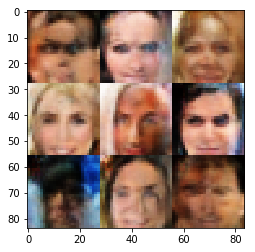

Epoch 3/5: steps 210 Discriminator Loss: 1.2110... Generator Loss: 0.7684
Epoch 3/5: steps 220 Discriminator Loss: 1.7148... Generator Loss: 1.8061
Epoch 3/5: steps 230 Discriminator Loss: 1.1923... Generator Loss: 0.9591
Epoch 3/5: steps 240 Discriminator Loss: 1.0963... Generator Loss: 0.8420
Epoch 3/5: steps 250 Discriminator Loss: 1.1340... Generator Loss: 1.0301
Epoch 3/5: steps 260 Discriminator Loss: 1.0482... Generator Loss: 1.4949
Epoch 3/5: steps 270 Discriminator Loss: 1.2185... Generator Loss: 0.8880
Epoch 3/5: steps 280 Discriminator Loss: 1.1530... Generator Loss: 0.7064
Epoch 3/5: steps 290 Discriminator Loss: 1.1803... Generator Loss: 0.8267
Epoch 3/5: steps 300 Discriminator Loss: 1.0991... Generator Loss: 1.0062


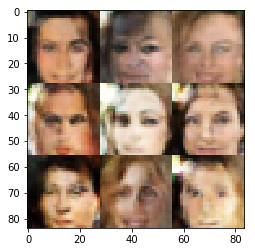

Epoch 3/5: steps 310 Discriminator Loss: 1.1351... Generator Loss: 0.9815
Epoch 3/5: steps 320 Discriminator Loss: 1.0283... Generator Loss: 0.8599
Epoch 3/5: steps 330 Discriminator Loss: 1.2189... Generator Loss: 0.7599
Epoch 3/5: steps 340 Discriminator Loss: 1.2358... Generator Loss: 1.0632
Epoch 3/5: steps 350 Discriminator Loss: 1.0998... Generator Loss: 0.8563
Epoch 3/5: steps 360 Discriminator Loss: 1.1446... Generator Loss: 0.9667
Epoch 3/5: steps 370 Discriminator Loss: 1.1272... Generator Loss: 1.1068
Epoch 3/5: steps 380 Discriminator Loss: 1.2337... Generator Loss: 0.7942
Epoch 3/5: steps 390 Discriminator Loss: 1.1911... Generator Loss: 1.1999
Epoch 3/5: steps 400 Discriminator Loss: 1.1255... Generator Loss: 1.0290


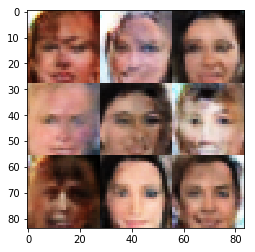

Epoch 3/5: steps 410 Discriminator Loss: 1.1249... Generator Loss: 0.9210
Epoch 3/5: steps 420 Discriminator Loss: 1.2326... Generator Loss: 0.7901
Epoch 3/5: steps 430 Discriminator Loss: 1.1798... Generator Loss: 0.9852
Epoch 3/5: steps 440 Discriminator Loss: 1.2438... Generator Loss: 0.8723
Epoch 3/5: steps 450 Discriminator Loss: 1.1959... Generator Loss: 0.9188
Epoch 3/5: steps 460 Discriminator Loss: 1.3170... Generator Loss: 0.8741
Epoch 3/5: steps 470 Discriminator Loss: 1.0597... Generator Loss: 0.9829
Epoch 3/5: steps 480 Discriminator Loss: 1.1518... Generator Loss: 0.8945
Epoch 3/5: steps 490 Discriminator Loss: 1.2048... Generator Loss: 0.7715
Epoch 3/5: steps 500 Discriminator Loss: 1.0421... Generator Loss: 1.1476


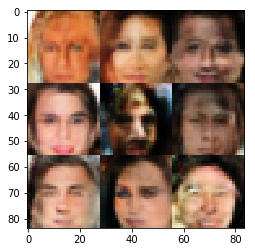

Epoch 3/5: steps 510 Discriminator Loss: 1.2297... Generator Loss: 0.6732
Epoch 3/5: steps 520 Discriminator Loss: 1.0726... Generator Loss: 1.1317
Epoch 3/5: steps 530 Discriminator Loss: 1.0827... Generator Loss: 0.8914
Epoch 3/5: steps 540 Discriminator Loss: 1.2911... Generator Loss: 0.8951
Epoch 3/5: steps 550 Discriminator Loss: 1.2239... Generator Loss: 0.9233
Epoch 3/5: steps 560 Discriminator Loss: 1.1671... Generator Loss: 0.9908
Epoch 3/5: steps 570 Discriminator Loss: 1.1158... Generator Loss: 1.2364
Epoch 3/5: steps 580 Discriminator Loss: 1.0905... Generator Loss: 0.8772
Epoch 3/5: steps 590 Discriminator Loss: 1.1480... Generator Loss: 1.0069
Epoch 3/5: steps 600 Discriminator Loss: 1.1592... Generator Loss: 0.9394


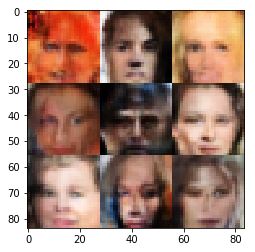

Epoch 3/5: steps 610 Discriminator Loss: 1.1767... Generator Loss: 0.8424
Epoch 3/5: steps 620 Discriminator Loss: 1.1078... Generator Loss: 0.8234
Epoch 3/5: steps 630 Discriminator Loss: 1.0430... Generator Loss: 0.9112
Epoch 3/5: steps 640 Discriminator Loss: 1.0986... Generator Loss: 0.9923
Epoch 3/5: steps 650 Discriminator Loss: 1.1577... Generator Loss: 0.9007
Epoch 3/5: steps 660 Discriminator Loss: 1.2072... Generator Loss: 1.2854
Epoch 3/5: steps 670 Discriminator Loss: 1.2674... Generator Loss: 0.8604
Epoch 3/5: steps 680 Discriminator Loss: 1.1631... Generator Loss: 0.8238
Epoch 3/5: steps 690 Discriminator Loss: 1.1390... Generator Loss: 0.8361
Epoch 3/5: steps 700 Discriminator Loss: 1.1828... Generator Loss: 0.8031


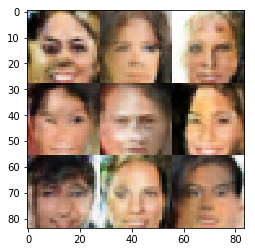

Epoch 3/5: steps 710 Discriminator Loss: 1.2179... Generator Loss: 1.1138
Epoch 3/5: steps 720 Discriminator Loss: 1.2700... Generator Loss: 1.1453
Epoch 3/5: steps 730 Discriminator Loss: 1.3029... Generator Loss: 0.8615
Epoch 3/5: steps 740 Discriminator Loss: 1.2382... Generator Loss: 0.7957
Epoch 3/5: steps 750 Discriminator Loss: 1.1988... Generator Loss: 0.9966
Epoch 3/5: steps 760 Discriminator Loss: 1.2364... Generator Loss: 0.7098
Epoch 3/5: steps 770 Discriminator Loss: 1.2377... Generator Loss: 1.0239
Epoch 3/5: steps 780 Discriminator Loss: 1.2328... Generator Loss: 1.0467
Epoch 3/5: steps 790 Discriminator Loss: 1.1960... Generator Loss: 0.8526
Epoch 3/5: steps 800 Discriminator Loss: 1.1613... Generator Loss: 1.0065


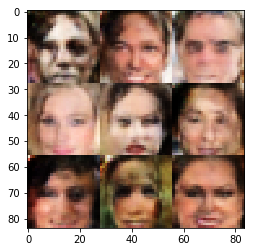

Epoch 3/5: steps 810 Discriminator Loss: 1.2708... Generator Loss: 0.9070
Epoch 3/5: steps 820 Discriminator Loss: 1.1915... Generator Loss: 0.7023
Epoch 3/5: steps 830 Discriminator Loss: 1.2018... Generator Loss: 0.9775
Epoch 3/5: steps 840 Discriminator Loss: 1.1096... Generator Loss: 1.0423
Epoch 3/5: steps 850 Discriminator Loss: 1.1008... Generator Loss: 1.0035
Epoch 3/5: steps 860 Discriminator Loss: 1.2966... Generator Loss: 0.8535
Epoch 3/5: steps 870 Discriminator Loss: 1.1816... Generator Loss: 0.8049
Epoch 3/5: steps 880 Discriminator Loss: 1.1384... Generator Loss: 0.9179
Epoch 3/5: steps 890 Discriminator Loss: 1.3108... Generator Loss: 0.7342
Epoch 3/5: steps 900 Discriminator Loss: 1.2052... Generator Loss: 0.8875


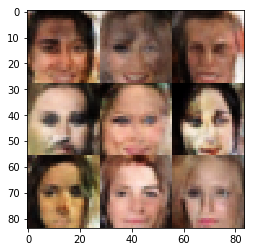

Epoch 3/5: steps 910 Discriminator Loss: 1.0750... Generator Loss: 1.0262
Epoch 3/5: steps 920 Discriminator Loss: 1.1806... Generator Loss: 0.9126
Epoch 3/5: steps 930 Discriminator Loss: 1.1956... Generator Loss: 0.9701
Epoch 3/5: steps 940 Discriminator Loss: 1.1566... Generator Loss: 0.8930
Epoch 3/5: steps 950 Discriminator Loss: 1.0927... Generator Loss: 1.0730
Epoch 3/5: steps 960 Discriminator Loss: 1.0839... Generator Loss: 1.0036
Epoch 3/5: steps 970 Discriminator Loss: 1.0959... Generator Loss: 0.8014
Epoch 3/5: steps 980 Discriminator Loss: 1.0819... Generator Loss: 1.0426
Epoch 3/5: steps 990 Discriminator Loss: 1.1936... Generator Loss: 0.8693
Epoch 3/5: steps 1000 Discriminator Loss: 1.1997... Generator Loss: 0.8320


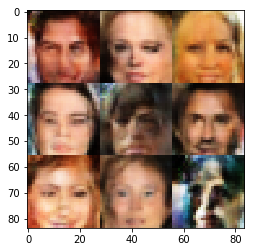

Epoch 3/5: steps 1010 Discriminator Loss: 1.1366... Generator Loss: 0.9977
Epoch 3/5: steps 1020 Discriminator Loss: 0.9640... Generator Loss: 1.4430
Epoch 3/5: steps 1030 Discriminator Loss: 1.2543... Generator Loss: 0.9527
Epoch 3/5: steps 1040 Discriminator Loss: 1.1758... Generator Loss: 0.9441
Epoch 3/5: steps 1050 Discriminator Loss: 1.0763... Generator Loss: 0.8840
Epoch 3/5: steps 1060 Discriminator Loss: 1.0976... Generator Loss: 0.9897
Epoch 3/5: steps 1070 Discriminator Loss: 1.2121... Generator Loss: 0.9718
Epoch 3/5: steps 1080 Discriminator Loss: 1.1160... Generator Loss: 0.8877
Epoch 3/5: steps 1090 Discriminator Loss: 1.1164... Generator Loss: 1.0385
Epoch 3/5: steps 1100 Discriminator Loss: 1.1969... Generator Loss: 0.9801


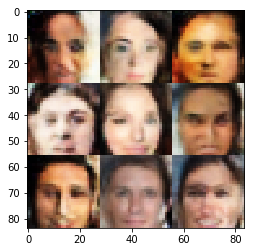

Epoch 3/5: steps 1110 Discriminator Loss: 1.3220... Generator Loss: 0.8831
Epoch 3/5: steps 1120 Discriminator Loss: 1.1345... Generator Loss: 0.9276
Epoch 3/5: steps 1130 Discriminator Loss: 1.1621... Generator Loss: 0.8914
Epoch 3/5: steps 1140 Discriminator Loss: 1.1807... Generator Loss: 0.8024
Epoch 3/5: steps 1150 Discriminator Loss: 1.1126... Generator Loss: 0.9379
Epoch 3/5: steps 1160 Discriminator Loss: 1.1152... Generator Loss: 0.8745
Epoch 3/5: steps 1170 Discriminator Loss: 1.1452... Generator Loss: 0.9545
Epoch 3/5: steps 1180 Discriminator Loss: 1.1324... Generator Loss: 0.9000
Epoch 3/5: steps 1190 Discriminator Loss: 1.1918... Generator Loss: 0.9430
Epoch 3/5: steps 1200 Discriminator Loss: 1.1561... Generator Loss: 0.8252


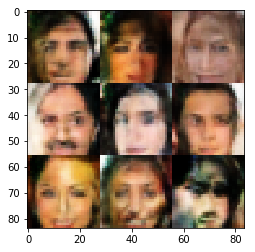

Epoch 3/5: steps 1210 Discriminator Loss: 1.1011... Generator Loss: 0.9890
Epoch 3/5: steps 1220 Discriminator Loss: 1.0523... Generator Loss: 0.8920
Epoch 3/5: steps 1230 Discriminator Loss: 1.0482... Generator Loss: 0.9782
Epoch 3/5: steps 1240 Discriminator Loss: 1.2361... Generator Loss: 0.9202
Epoch 3/5: steps 1250 Discriminator Loss: 1.2280... Generator Loss: 0.8606
Epoch 3/5: steps 1260 Discriminator Loss: 1.2689... Generator Loss: 0.8671
Epoch 3/5: steps 1270 Discriminator Loss: 1.1354... Generator Loss: 0.9984
Epoch 3/5: steps 1280 Discriminator Loss: 1.0889... Generator Loss: 0.9979
Epoch 3/5: steps 1290 Discriminator Loss: 1.0697... Generator Loss: 1.1020
Epoch 3/5: steps 1300 Discriminator Loss: 1.2180... Generator Loss: 0.9661


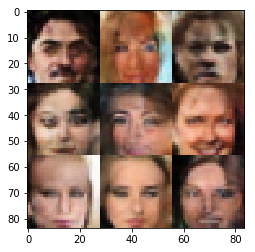

Epoch 3/5: steps 1310 Discriminator Loss: 1.1830... Generator Loss: 0.8176
Epoch 3/5: steps 1320 Discriminator Loss: 1.1003... Generator Loss: 0.9788
Epoch 3/5: steps 1330 Discriminator Loss: 1.0054... Generator Loss: 1.1952
Epoch 3/5: steps 1340 Discriminator Loss: 1.0939... Generator Loss: 1.1964
Epoch 3/5: steps 1350 Discriminator Loss: 1.1285... Generator Loss: 0.9062
Epoch 3/5: steps 1360 Discriminator Loss: 1.0961... Generator Loss: 0.9079
Epoch 3/5: steps 1370 Discriminator Loss: 1.2598... Generator Loss: 1.0955
Epoch 3/5: steps 1380 Discriminator Loss: 1.1051... Generator Loss: 0.9610
Epoch 3/5: steps 1390 Discriminator Loss: 1.0990... Generator Loss: 0.8565
Epoch 3/5: steps 1400 Discriminator Loss: 1.0764... Generator Loss: 1.0453


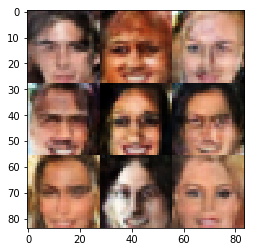

Epoch 3/5: steps 1410 Discriminator Loss: 1.1066... Generator Loss: 0.8699
Epoch 3/5: steps 1420 Discriminator Loss: 1.1566... Generator Loss: 1.0167
Epoch 3/5: steps 1430 Discriminator Loss: 1.1564... Generator Loss: 1.1124
Epoch 3/5: steps 1440 Discriminator Loss: 1.1506... Generator Loss: 0.8721
Epoch 3/5: steps 1450 Discriminator Loss: 1.0813... Generator Loss: 1.1203
Epoch 3/5: steps 1460 Discriminator Loss: 1.0590... Generator Loss: 1.0777
Epoch 3/5: steps 1470 Discriminator Loss: 1.2073... Generator Loss: 1.0185
Epoch 3/5: steps 1480 Discriminator Loss: 1.2612... Generator Loss: 0.8812
Epoch 3/5: steps 1490 Discriminator Loss: 1.2053... Generator Loss: 0.7830
Epoch 3/5: steps 1500 Discriminator Loss: 1.2058... Generator Loss: 0.7608


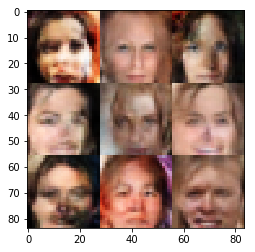

Epoch 3/5: steps 1510 Discriminator Loss: 1.1902... Generator Loss: 0.8592
Epoch 3/5: steps 1520 Discriminator Loss: 1.1380... Generator Loss: 0.9267
Epoch 3/5: steps 1530 Discriminator Loss: 1.1655... Generator Loss: 1.1823
Epoch 3/5: steps 1540 Discriminator Loss: 1.2631... Generator Loss: 0.9006
Epoch 3/5: steps 1550 Discriminator Loss: 1.2114... Generator Loss: 0.7861
Epoch 3/5: steps 1560 Discriminator Loss: 1.2164... Generator Loss: 1.3366
Epoch 3/5: steps 1570 Discriminator Loss: 1.1137... Generator Loss: 0.8583
Epoch 3/5: steps 1580 Discriminator Loss: 1.1130... Generator Loss: 1.0619
Epoch 3/5: steps 1590 Discriminator Loss: 1.0903... Generator Loss: 0.8644
Epoch 3/5: steps 1600 Discriminator Loss: 1.1997... Generator Loss: 1.0226


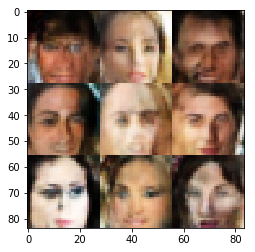

Epoch 3/5: steps 1610 Discriminator Loss: 1.2037... Generator Loss: 0.9778
Epoch 3/5: steps 1620 Discriminator Loss: 1.3419... Generator Loss: 0.8228
Epoch 3/5: steps 1630 Discriminator Loss: 1.2654... Generator Loss: 0.7285
Epoch 3/5: steps 1640 Discriminator Loss: 1.2342... Generator Loss: 1.0062
Epoch 3/5: steps 1650 Discriminator Loss: 1.1853... Generator Loss: 0.8450
Epoch 3/5: steps 1660 Discriminator Loss: 1.1706... Generator Loss: 0.8726
Epoch 3/5: steps 1670 Discriminator Loss: 1.2217... Generator Loss: 0.7860
Epoch 3/5: steps 1680 Discriminator Loss: 1.1479... Generator Loss: 0.9692
Epoch 3/5: steps 1690 Discriminator Loss: 1.1641... Generator Loss: 0.9924
Epoch 3/5: steps 1700 Discriminator Loss: 1.1229... Generator Loss: 0.8866


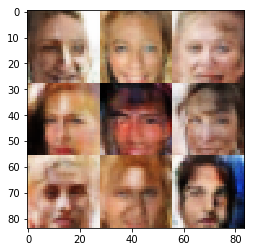

Epoch 3/5: steps 1710 Discriminator Loss: 1.0806... Generator Loss: 1.1209
Epoch 3/5: steps 1720 Discriminator Loss: 1.0987... Generator Loss: 0.9922
Epoch 3/5: steps 1730 Discriminator Loss: 1.0338... Generator Loss: 1.1109
Epoch 3/5: steps 1740 Discriminator Loss: 1.1042... Generator Loss: 1.0231
Epoch 3/5: steps 1750 Discriminator Loss: 1.2901... Generator Loss: 0.8242
Epoch 3/5: steps 1760 Discriminator Loss: 1.1739... Generator Loss: 0.8033
Epoch 3/5: steps 1770 Discriminator Loss: 1.1649... Generator Loss: 0.8919
Epoch 3/5: steps 1780 Discriminator Loss: 1.0992... Generator Loss: 1.0475
Epoch 3/5: steps 1790 Discriminator Loss: 1.1459... Generator Loss: 0.7891
Epoch 3/5: steps 1800 Discriminator Loss: 1.3054... Generator Loss: 0.7876


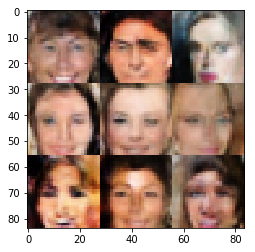

Epoch 3/5: steps 1810 Discriminator Loss: 1.2755... Generator Loss: 1.2049
Epoch 3/5: steps 1820 Discriminator Loss: 1.2220... Generator Loss: 0.8453
Epoch 3/5: steps 1830 Discriminator Loss: 1.1473... Generator Loss: 0.8668
Epoch 3/5: steps 1840 Discriminator Loss: 1.3405... Generator Loss: 0.8967
Epoch 3/5: steps 1850 Discriminator Loss: 1.1793... Generator Loss: 0.8907
Epoch 3/5: steps 1860 Discriminator Loss: 1.2013... Generator Loss: 1.1764
Epoch 3/5: steps 1870 Discriminator Loss: 1.2384... Generator Loss: 0.8154
Epoch 3/5: steps 1880 Discriminator Loss: 1.2404... Generator Loss: 0.8361
Epoch 3/5: steps 1890 Discriminator Loss: 1.1109... Generator Loss: 0.9582
Epoch 3/5: steps 1900 Discriminator Loss: 1.1495... Generator Loss: 1.0413


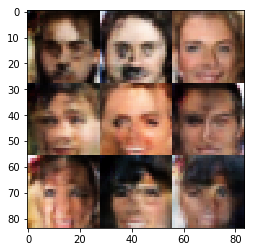

Epoch 3/5: steps 1910 Discriminator Loss: 1.1438... Generator Loss: 0.8079
Epoch 3/5: steps 1920 Discriminator Loss: 1.2062... Generator Loss: 0.9619
Epoch 3/5: steps 1930 Discriminator Loss: 1.1393... Generator Loss: 1.1763
Epoch 3/5: steps 1940 Discriminator Loss: 1.1638... Generator Loss: 0.8625
Epoch 3/5: steps 1950 Discriminator Loss: 1.3945... Generator Loss: 0.6419
Epoch 3/5: steps 1960 Discriminator Loss: 1.4370... Generator Loss: 0.6834
Epoch 3/5: steps 1970 Discriminator Loss: 1.3297... Generator Loss: 0.8449
Epoch 3/5: steps 1980 Discriminator Loss: 1.1446... Generator Loss: 0.9645
Epoch 3/5: steps 1990 Discriminator Loss: 1.1704... Generator Loss: 0.9133
Epoch 3/5: steps 2000 Discriminator Loss: 1.2209... Generator Loss: 0.7299


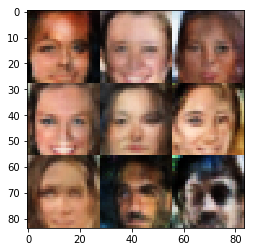

Epoch 3/5: steps 2010 Discriminator Loss: 1.1302... Generator Loss: 0.9448
Epoch 3/5: steps 2020 Discriminator Loss: 1.0919... Generator Loss: 0.9990
Epoch 3/5: steps 2030 Discriminator Loss: 1.2657... Generator Loss: 0.8864
Epoch 3/5: steps 2040 Discriminator Loss: 1.2311... Generator Loss: 0.7806
Epoch 3/5: steps 2050 Discriminator Loss: 1.1287... Generator Loss: 0.8290
Epoch 3/5: steps 2060 Discriminator Loss: 1.2169... Generator Loss: 0.8648
Epoch 3/5: steps 2070 Discriminator Loss: 1.1790... Generator Loss: 0.8556
Epoch 3/5: steps 2080 Discriminator Loss: 0.9980... Generator Loss: 1.0518
Epoch 3/5: steps 2090 Discriminator Loss: 1.1903... Generator Loss: 0.8267
Epoch 3/5: steps 2100 Discriminator Loss: 1.1571... Generator Loss: 0.8429


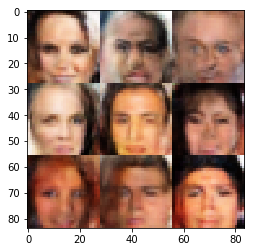

Epoch 3/5: steps 2110 Discriminator Loss: 1.1471... Generator Loss: 0.8407
Epoch 3/5: steps 2120 Discriminator Loss: 1.1539... Generator Loss: 0.8271
Epoch 3/5: steps 2130 Discriminator Loss: 1.2940... Generator Loss: 0.7694
Epoch 3/5: steps 2140 Discriminator Loss: 1.0618... Generator Loss: 0.9723
Epoch 3/5: steps 2150 Discriminator Loss: 1.1496... Generator Loss: 0.9614
Epoch 3/5: steps 2160 Discriminator Loss: 1.2465... Generator Loss: 0.8877
Epoch 3/5: steps 2170 Discriminator Loss: 1.1405... Generator Loss: 1.0805
Epoch 3/5: steps 2180 Discriminator Loss: 1.1395... Generator Loss: 1.0283
Epoch 3/5: steps 2190 Discriminator Loss: 1.2066... Generator Loss: 0.9450
Epoch 3/5: steps 2200 Discriminator Loss: 1.1101... Generator Loss: 0.7952


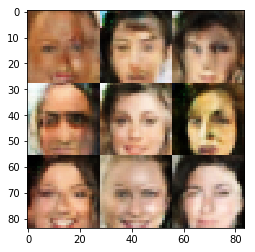

Epoch 3/5: steps 2210 Discriminator Loss: 1.1495... Generator Loss: 0.9014
Epoch 3/5: steps 2220 Discriminator Loss: 1.2288... Generator Loss: 0.8224
Epoch 3/5: steps 2230 Discriminator Loss: 1.1837... Generator Loss: 0.8893
Epoch 3/5: steps 2240 Discriminator Loss: 1.1818... Generator Loss: 1.1458
Epoch 3/5: steps 2250 Discriminator Loss: 1.2341... Generator Loss: 0.9504
Epoch 3/5: steps 2260 Discriminator Loss: 1.2223... Generator Loss: 0.8107
Epoch 3/5: steps 2270 Discriminator Loss: 1.0840... Generator Loss: 0.9349
Epoch 3/5: steps 2280 Discriminator Loss: 1.2640... Generator Loss: 0.9237
Epoch 3/5: steps 2290 Discriminator Loss: 1.1599... Generator Loss: 0.9537
Epoch 3/5: steps 2300 Discriminator Loss: 1.3866... Generator Loss: 1.3911


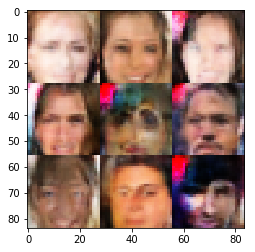

Epoch 3/5: steps 2310 Discriminator Loss: 1.4021... Generator Loss: 0.7569
Epoch 3/5: steps 2320 Discriminator Loss: 1.1568... Generator Loss: 0.9173
Epoch 3/5: steps 2330 Discriminator Loss: 1.1918... Generator Loss: 1.5274
Epoch 3/5: steps 2340 Discriminator Loss: 1.0966... Generator Loss: 0.9718
Epoch 3/5: steps 2350 Discriminator Loss: 1.8522... Generator Loss: 1.9333
Epoch 3/5: steps 2360 Discriminator Loss: 1.3429... Generator Loss: 0.9409
Epoch 3/5: steps 2370 Discriminator Loss: 1.2493... Generator Loss: 0.9851
Epoch 3/5: steps 2380 Discriminator Loss: 1.2016... Generator Loss: 0.9491
Epoch 3/5: steps 2390 Discriminator Loss: 1.2424... Generator Loss: 0.7762
Epoch 3/5: steps 2400 Discriminator Loss: 1.1956... Generator Loss: 0.8692


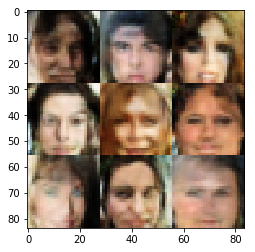

Epoch 3/5: steps 2410 Discriminator Loss: 1.2862... Generator Loss: 0.7734
Epoch 3/5: steps 2420 Discriminator Loss: 1.1479... Generator Loss: 0.8819
Epoch 3/5: steps 2430 Discriminator Loss: 1.2186... Generator Loss: 0.8161
Epoch 3/5: steps 2440 Discriminator Loss: 1.1180... Generator Loss: 0.8755
Epoch 3/5: steps 2450 Discriminator Loss: 1.2136... Generator Loss: 0.9765
Epoch 3/5: steps 2460 Discriminator Loss: 1.1215... Generator Loss: 0.9008
Epoch 3/5: steps 2470 Discriminator Loss: 1.3138... Generator Loss: 0.9970
Epoch 3/5: steps 2480 Discriminator Loss: 1.0885... Generator Loss: 1.0049
Epoch 3/5: steps 2490 Discriminator Loss: 1.1205... Generator Loss: 0.9803
Epoch 3/5: steps 2500 Discriminator Loss: 1.1566... Generator Loss: 0.9210


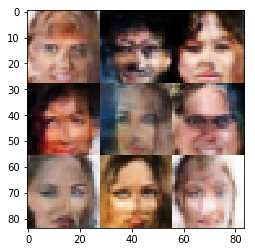

Epoch 3/5: steps 2510 Discriminator Loss: 1.1512... Generator Loss: 0.8148
Epoch 3/5: steps 2520 Discriminator Loss: 1.0531... Generator Loss: 0.9289
Epoch 3/5: steps 2530 Discriminator Loss: 1.1962... Generator Loss: 0.8293
Epoch 3/5: steps 2540 Discriminator Loss: 1.2820... Generator Loss: 0.8435
Epoch 3/5: steps 2550 Discriminator Loss: 1.2016... Generator Loss: 0.9945
Epoch 3/5: steps 2560 Discriminator Loss: 1.2056... Generator Loss: 0.7903
Epoch 3/5: steps 2570 Discriminator Loss: 1.2517... Generator Loss: 0.8856
Epoch 3/5: steps 2580 Discriminator Loss: 1.1432... Generator Loss: 0.9097
Epoch 3/5: steps 2590 Discriminator Loss: 1.1521... Generator Loss: 0.8859
Epoch 3/5: steps 2600 Discriminator Loss: 1.1912... Generator Loss: 1.0028


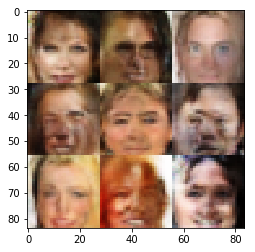

Epoch 3/5: steps 2610 Discriminator Loss: 1.1412... Generator Loss: 1.0590
Epoch 3/5: steps 2620 Discriminator Loss: 1.1386... Generator Loss: 0.9250
Epoch 3/5: steps 2630 Discriminator Loss: 1.1286... Generator Loss: 1.1911
Epoch 3/5: steps 2640 Discriminator Loss: 1.1961... Generator Loss: 0.8180
Epoch 3/5: steps 2650 Discriminator Loss: 1.1347... Generator Loss: 1.0594
Epoch 3/5: steps 2660 Discriminator Loss: 1.1630... Generator Loss: 0.9311
Epoch 3/5: steps 2670 Discriminator Loss: 1.1821... Generator Loss: 0.9157
Epoch 3/5: steps 2680 Discriminator Loss: 1.2137... Generator Loss: 1.0527
Epoch 3/5: steps 2690 Discriminator Loss: 1.1797... Generator Loss: 0.8407
Epoch 3/5: steps 2700 Discriminator Loss: 1.1702... Generator Loss: 0.9149


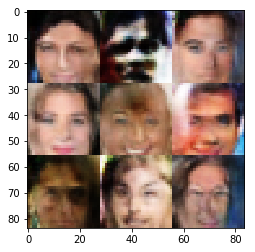

Epoch 3/5: steps 2710 Discriminator Loss: 1.1433... Generator Loss: 0.9343
Epoch 3/5: steps 2720 Discriminator Loss: 1.2316... Generator Loss: 0.8356
Epoch 3/5: steps 2730 Discriminator Loss: 1.2721... Generator Loss: 0.7900
Epoch 3/5: steps 2740 Discriminator Loss: 1.1509... Generator Loss: 0.9519
Epoch 3/5: steps 2750 Discriminator Loss: 1.1389... Generator Loss: 1.1834
Epoch 3/5: steps 2760 Discriminator Loss: 1.2558... Generator Loss: 0.8812
Epoch 3/5: steps 2770 Discriminator Loss: 1.3077... Generator Loss: 0.7349
Epoch 3/5: steps 2780 Discriminator Loss: 1.1358... Generator Loss: 0.8280
Epoch 3/5: steps 2790 Discriminator Loss: 1.1564... Generator Loss: 0.9085
Epoch 3/5: steps 2800 Discriminator Loss: 1.0785... Generator Loss: 1.0245


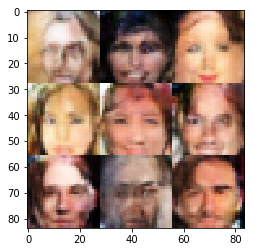

Epoch 3/5: steps 2810 Discriminator Loss: 1.2840... Generator Loss: 0.7222
Epoch 3/5: steps 2820 Discriminator Loss: 1.2584... Generator Loss: 0.7761
Epoch 3/5: steps 2830 Discriminator Loss: 1.0415... Generator Loss: 0.9779
Epoch 3/5: steps 2840 Discriminator Loss: 1.2276... Generator Loss: 1.0202
Epoch 3/5: steps 2850 Discriminator Loss: 1.1630... Generator Loss: 0.9132
Epoch 3/5: steps 2860 Discriminator Loss: 1.2346... Generator Loss: 0.9586
Epoch 3/5: steps 2870 Discriminator Loss: 1.1793... Generator Loss: 0.8653
Epoch 3/5: steps 2880 Discriminator Loss: 1.0618... Generator Loss: 1.0159
Epoch 3/5: steps 2890 Discriminator Loss: 1.1603... Generator Loss: 0.8558
Epoch 3/5: steps 2900 Discriminator Loss: 1.1828... Generator Loss: 0.9912


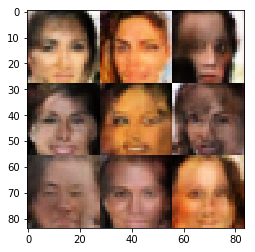

Epoch 3/5: steps 2910 Discriminator Loss: 1.1519... Generator Loss: 1.0092
Epoch 3/5: steps 2920 Discriminator Loss: 1.0804... Generator Loss: 0.9423
Epoch 3/5: steps 2930 Discriminator Loss: 1.1571... Generator Loss: 0.8617
Epoch 3/5: steps 2940 Discriminator Loss: 1.1512... Generator Loss: 1.0967
Epoch 3/5: steps 2950 Discriminator Loss: 1.2042... Generator Loss: 0.7822
Epoch 3/5: steps 2960 Discriminator Loss: 1.1425... Generator Loss: 0.9832
Epoch 3/5: steps 2970 Discriminator Loss: 1.2127... Generator Loss: 0.7482
Epoch 3/5: steps 2980 Discriminator Loss: 1.3192... Generator Loss: 0.8475
Epoch 3/5: steps 2990 Discriminator Loss: 1.1808... Generator Loss: 0.8771
Epoch 3/5: steps 3000 Discriminator Loss: 1.1570... Generator Loss: 1.0068


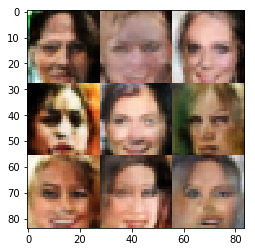

Epoch 3/5: steps 3010 Discriminator Loss: 1.0872... Generator Loss: 0.9424
Epoch 3/5: steps 3020 Discriminator Loss: 1.1862... Generator Loss: 0.8935
Epoch 3/5: steps 3030 Discriminator Loss: 1.2695... Generator Loss: 1.0046
Epoch 3/5: steps 3040 Discriminator Loss: 1.1880... Generator Loss: 1.0054
Epoch 3/5: steps 3050 Discriminator Loss: 1.1707... Generator Loss: 0.9831
Epoch 3/5: steps 3060 Discriminator Loss: 1.1865... Generator Loss: 0.9574
Epoch 3/5: steps 3070 Discriminator Loss: 1.1917... Generator Loss: 0.9253
Epoch 3/5: steps 3080 Discriminator Loss: 1.1591... Generator Loss: 1.0310
Epoch 3/5: steps 3090 Discriminator Loss: 1.1328... Generator Loss: 0.9069
Epoch 3/5: steps 3100 Discriminator Loss: 1.1648... Generator Loss: 0.7787


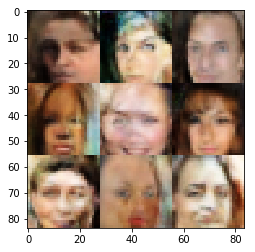

Epoch 3/5: steps 3110 Discriminator Loss: 1.1958... Generator Loss: 0.8838
Epoch 3/5: steps 3120 Discriminator Loss: 1.2015... Generator Loss: 0.8988
Epoch 3/5: steps 3130 Discriminator Loss: 1.1225... Generator Loss: 0.8645
Epoch 3/5: steps 3140 Discriminator Loss: 1.0582... Generator Loss: 1.0863
Epoch 3/5: steps 3150 Discriminator Loss: 1.2196... Generator Loss: 1.0086
Epoch 3/5: steps 3160 Discriminator Loss: 1.1476... Generator Loss: 0.8801
Epoch 4/5: steps 10 Discriminator Loss: 1.5667... Generator Loss: 1.7700
Epoch 4/5: steps 20 Discriminator Loss: 1.1163... Generator Loss: 0.9374
Epoch 4/5: steps 30 Discriminator Loss: 1.3060... Generator Loss: 0.7114
Epoch 4/5: steps 40 Discriminator Loss: 1.3058... Generator Loss: 0.7045
Epoch 4/5: steps 50 Discriminator Loss: 1.1628... Generator Loss: 0.8878
Epoch 4/5: steps 60 Discriminator Loss: 1.1911... Generator Loss: 0.9504
Epoch 4/5: steps 70 Discriminator Loss: 1.1839... Generator Loss: 0.8333
Epoch 4/5: steps 80 Discriminator Loss:

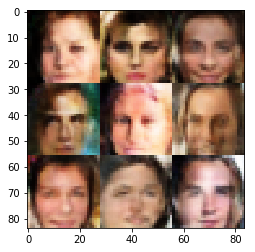

Epoch 4/5: steps 110 Discriminator Loss: 1.1815... Generator Loss: 0.8185
Epoch 4/5: steps 120 Discriminator Loss: 1.0978... Generator Loss: 0.8648
Epoch 4/5: steps 130 Discriminator Loss: 1.2530... Generator Loss: 0.8746
Epoch 4/5: steps 140 Discriminator Loss: 1.2151... Generator Loss: 0.8585
Epoch 4/5: steps 150 Discriminator Loss: 1.2759... Generator Loss: 0.8618
Epoch 4/5: steps 160 Discriminator Loss: 1.1805... Generator Loss: 0.8869
Epoch 4/5: steps 170 Discriminator Loss: 1.2062... Generator Loss: 0.9057
Epoch 4/5: steps 180 Discriminator Loss: 1.1138... Generator Loss: 1.0318
Epoch 4/5: steps 190 Discriminator Loss: 1.1783... Generator Loss: 0.7582
Epoch 4/5: steps 200 Discriminator Loss: 1.2184... Generator Loss: 0.9120


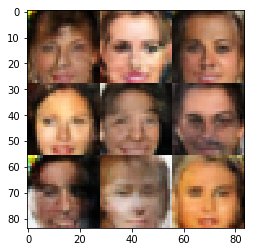

Epoch 4/5: steps 210 Discriminator Loss: 1.1338... Generator Loss: 0.8385
Epoch 4/5: steps 220 Discriminator Loss: 1.2310... Generator Loss: 0.8542
Epoch 4/5: steps 230 Discriminator Loss: 1.2567... Generator Loss: 0.7670
Epoch 4/5: steps 240 Discriminator Loss: 1.2113... Generator Loss: 0.8863
Epoch 4/5: steps 250 Discriminator Loss: 1.2711... Generator Loss: 0.7394
Epoch 4/5: steps 260 Discriminator Loss: 1.2732... Generator Loss: 0.8827
Epoch 4/5: steps 270 Discriminator Loss: 1.0907... Generator Loss: 0.9457
Epoch 4/5: steps 280 Discriminator Loss: 1.0086... Generator Loss: 0.9913
Epoch 4/5: steps 290 Discriminator Loss: 1.1355... Generator Loss: 0.9700
Epoch 4/5: steps 300 Discriminator Loss: 1.1980... Generator Loss: 0.9867


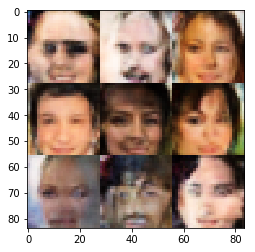

Epoch 4/5: steps 310 Discriminator Loss: 1.1600... Generator Loss: 0.9053
Epoch 4/5: steps 320 Discriminator Loss: 1.1273... Generator Loss: 0.9734
Epoch 4/5: steps 330 Discriminator Loss: 1.2550... Generator Loss: 0.8637
Epoch 4/5: steps 340 Discriminator Loss: 1.1808... Generator Loss: 0.8201
Epoch 4/5: steps 350 Discriminator Loss: 1.2425... Generator Loss: 0.9455
Epoch 4/5: steps 360 Discriminator Loss: 1.1337... Generator Loss: 0.8266
Epoch 4/5: steps 370 Discriminator Loss: 1.2328... Generator Loss: 1.0000
Epoch 4/5: steps 380 Discriminator Loss: 1.3687... Generator Loss: 0.9234
Epoch 4/5: steps 390 Discriminator Loss: 1.1873... Generator Loss: 1.0979
Epoch 4/5: steps 400 Discriminator Loss: 1.2090... Generator Loss: 0.8603


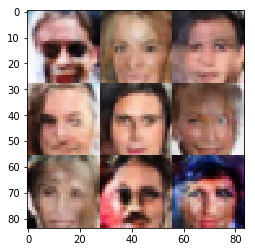

Epoch 4/5: steps 410 Discriminator Loss: 1.2336... Generator Loss: 0.9023
Epoch 4/5: steps 420 Discriminator Loss: 1.2656... Generator Loss: 0.8121
Epoch 4/5: steps 430 Discriminator Loss: 1.1511... Generator Loss: 0.9175
Epoch 4/5: steps 440 Discriminator Loss: 1.3171... Generator Loss: 1.0042
Epoch 4/5: steps 450 Discriminator Loss: 1.2193... Generator Loss: 1.0043
Epoch 4/5: steps 460 Discriminator Loss: 1.2419... Generator Loss: 0.8454
Epoch 4/5: steps 470 Discriminator Loss: 1.2704... Generator Loss: 0.9884
Epoch 4/5: steps 480 Discriminator Loss: 1.1768... Generator Loss: 1.0643
Epoch 4/5: steps 490 Discriminator Loss: 1.2021... Generator Loss: 0.7910
Epoch 4/5: steps 500 Discriminator Loss: 1.1264... Generator Loss: 0.8848


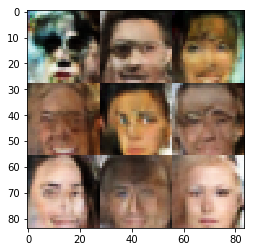

Epoch 4/5: steps 510 Discriminator Loss: 1.0982... Generator Loss: 1.2437
Epoch 4/5: steps 520 Discriminator Loss: 1.1208... Generator Loss: 0.8717
Epoch 4/5: steps 530 Discriminator Loss: 1.2853... Generator Loss: 0.6251
Epoch 4/5: steps 540 Discriminator Loss: 1.1898... Generator Loss: 0.8844
Epoch 4/5: steps 550 Discriminator Loss: 1.1673... Generator Loss: 0.8530
Epoch 4/5: steps 560 Discriminator Loss: 1.1492... Generator Loss: 0.9561
Epoch 4/5: steps 570 Discriminator Loss: 1.2302... Generator Loss: 0.8366
Epoch 4/5: steps 580 Discriminator Loss: 1.2232... Generator Loss: 0.9636
Epoch 4/5: steps 590 Discriminator Loss: 1.2043... Generator Loss: 0.9514
Epoch 4/5: steps 600 Discriminator Loss: 1.2604... Generator Loss: 0.8927


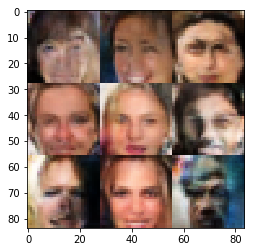

Epoch 4/5: steps 610 Discriminator Loss: 1.2376... Generator Loss: 0.9340
Epoch 4/5: steps 620 Discriminator Loss: 1.2202... Generator Loss: 0.9110
Epoch 4/5: steps 630 Discriminator Loss: 1.2440... Generator Loss: 0.9418
Epoch 4/5: steps 640 Discriminator Loss: 1.0930... Generator Loss: 0.8504
Epoch 4/5: steps 650 Discriminator Loss: 1.0923... Generator Loss: 0.9309
Epoch 4/5: steps 660 Discriminator Loss: 1.1403... Generator Loss: 0.9965
Epoch 4/5: steps 670 Discriminator Loss: 1.2109... Generator Loss: 0.8581
Epoch 4/5: steps 680 Discriminator Loss: 1.1647... Generator Loss: 0.9631
Epoch 4/5: steps 690 Discriminator Loss: 1.2456... Generator Loss: 0.8214
Epoch 4/5: steps 700 Discriminator Loss: 1.2935... Generator Loss: 0.7306


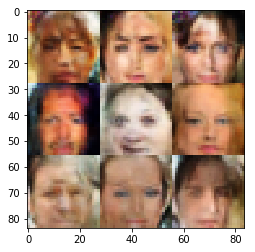

Epoch 4/5: steps 710 Discriminator Loss: 1.2779... Generator Loss: 0.9123
Epoch 4/5: steps 720 Discriminator Loss: 1.1135... Generator Loss: 1.0723
Epoch 4/5: steps 730 Discriminator Loss: 1.2704... Generator Loss: 0.7906
Epoch 4/5: steps 740 Discriminator Loss: 1.1543... Generator Loss: 0.8214
Epoch 4/5: steps 750 Discriminator Loss: 1.1471... Generator Loss: 0.9207
Epoch 4/5: steps 760 Discriminator Loss: 1.2422... Generator Loss: 0.8756
Epoch 4/5: steps 770 Discriminator Loss: 1.1288... Generator Loss: 0.8366
Epoch 4/5: steps 780 Discriminator Loss: 1.2719... Generator Loss: 0.7332
Epoch 4/5: steps 790 Discriminator Loss: 1.1465... Generator Loss: 0.9304
Epoch 4/5: steps 800 Discriminator Loss: 1.2191... Generator Loss: 1.0165


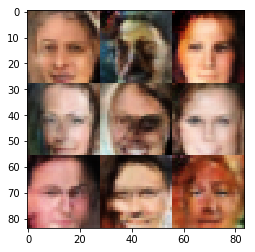

Epoch 4/5: steps 810 Discriminator Loss: 1.1654... Generator Loss: 0.8571
Epoch 4/5: steps 820 Discriminator Loss: 1.2602... Generator Loss: 0.7287
Epoch 4/5: steps 830 Discriminator Loss: 1.2420... Generator Loss: 0.7935
Epoch 4/5: steps 840 Discriminator Loss: 1.2553... Generator Loss: 0.9697
Epoch 4/5: steps 850 Discriminator Loss: 1.1947... Generator Loss: 0.8461
Epoch 4/5: steps 860 Discriminator Loss: 1.2963... Generator Loss: 0.8122
Epoch 4/5: steps 870 Discriminator Loss: 1.1584... Generator Loss: 0.8693
Epoch 4/5: steps 880 Discriminator Loss: 1.2633... Generator Loss: 0.9345
Epoch 4/5: steps 890 Discriminator Loss: 1.3412... Generator Loss: 1.0136
Epoch 4/5: steps 900 Discriminator Loss: 1.2200... Generator Loss: 0.8911


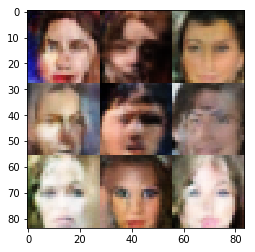

Epoch 4/5: steps 910 Discriminator Loss: 1.2399... Generator Loss: 0.7769
Epoch 4/5: steps 920 Discriminator Loss: 1.1283... Generator Loss: 0.9236
Epoch 4/5: steps 930 Discriminator Loss: 1.1980... Generator Loss: 0.9100
Epoch 4/5: steps 940 Discriminator Loss: 1.1905... Generator Loss: 1.0508
Epoch 4/5: steps 950 Discriminator Loss: 1.1398... Generator Loss: 0.9995
Epoch 4/5: steps 960 Discriminator Loss: 1.1322... Generator Loss: 0.8657
Epoch 4/5: steps 970 Discriminator Loss: 1.2244... Generator Loss: 1.0093
Epoch 4/5: steps 980 Discriminator Loss: 1.2722... Generator Loss: 0.9909
Epoch 4/5: steps 990 Discriminator Loss: 1.2053... Generator Loss: 0.8438
Epoch 4/5: steps 1000 Discriminator Loss: 1.1564... Generator Loss: 1.1488


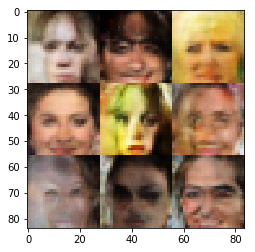

Epoch 4/5: steps 1010 Discriminator Loss: 1.1714... Generator Loss: 0.9708
Epoch 4/5: steps 1020 Discriminator Loss: 1.1729... Generator Loss: 0.9360
Epoch 4/5: steps 1030 Discriminator Loss: 1.2783... Generator Loss: 1.0790
Epoch 4/5: steps 1040 Discriminator Loss: 1.1766... Generator Loss: 0.9473
Epoch 4/5: steps 1050 Discriminator Loss: 1.3170... Generator Loss: 0.8127
Epoch 4/5: steps 1060 Discriminator Loss: 1.2640... Generator Loss: 0.8188
Epoch 4/5: steps 1070 Discriminator Loss: 1.1784... Generator Loss: 0.9034
Epoch 4/5: steps 1080 Discriminator Loss: 1.2317... Generator Loss: 0.8705
Epoch 4/5: steps 1090 Discriminator Loss: 1.2768... Generator Loss: 0.7948
Epoch 4/5: steps 1100 Discriminator Loss: 1.2061... Generator Loss: 0.8845


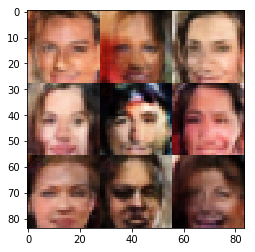

Epoch 4/5: steps 1110 Discriminator Loss: 1.4164... Generator Loss: 1.1895
Epoch 4/5: steps 1120 Discriminator Loss: 1.1618... Generator Loss: 0.9107
Epoch 4/5: steps 1130 Discriminator Loss: 1.2545... Generator Loss: 0.8394
Epoch 4/5: steps 1140 Discriminator Loss: 1.2596... Generator Loss: 0.9626
Epoch 4/5: steps 1150 Discriminator Loss: 1.0852... Generator Loss: 0.9633
Epoch 4/5: steps 1160 Discriminator Loss: 1.1597... Generator Loss: 0.8538
Epoch 4/5: steps 1170 Discriminator Loss: 1.2741... Generator Loss: 0.8653
Epoch 4/5: steps 1180 Discriminator Loss: 1.3788... Generator Loss: 0.5644
Epoch 4/5: steps 1190 Discriminator Loss: 1.4064... Generator Loss: 1.2687
Epoch 4/5: steps 1200 Discriminator Loss: 1.1613... Generator Loss: 0.8219


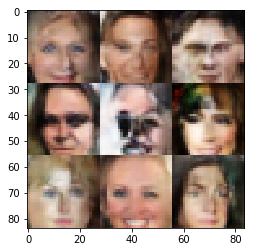

Epoch 4/5: steps 1210 Discriminator Loss: 1.2508... Generator Loss: 0.9754
Epoch 4/5: steps 1220 Discriminator Loss: 1.2295... Generator Loss: 0.9521
Epoch 4/5: steps 1230 Discriminator Loss: 1.2226... Generator Loss: 0.8963
Epoch 4/5: steps 1240 Discriminator Loss: 1.2451... Generator Loss: 0.8052
Epoch 4/5: steps 1250 Discriminator Loss: 1.3034... Generator Loss: 1.0011
Epoch 4/5: steps 1260 Discriminator Loss: 1.2519... Generator Loss: 0.7939
Epoch 4/5: steps 1270 Discriminator Loss: 1.2046... Generator Loss: 0.8251
Epoch 4/5: steps 1280 Discriminator Loss: 1.1790... Generator Loss: 0.9151
Epoch 4/5: steps 1290 Discriminator Loss: 1.1566... Generator Loss: 0.8045
Epoch 4/5: steps 1300 Discriminator Loss: 1.1685... Generator Loss: 0.8600


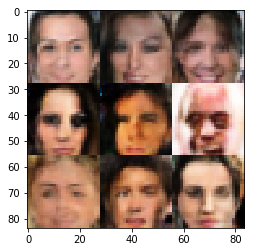

Epoch 4/5: steps 1310 Discriminator Loss: 1.1920... Generator Loss: 0.8811
Epoch 4/5: steps 1320 Discriminator Loss: 1.2199... Generator Loss: 0.9268
Epoch 4/5: steps 1330 Discriminator Loss: 1.1782... Generator Loss: 0.7968
Epoch 4/5: steps 1340 Discriminator Loss: 1.2010... Generator Loss: 0.9277
Epoch 4/5: steps 1350 Discriminator Loss: 1.1816... Generator Loss: 0.9242
Epoch 4/5: steps 1360 Discriminator Loss: 1.2142... Generator Loss: 0.8010
Epoch 4/5: steps 1370 Discriminator Loss: 1.2577... Generator Loss: 0.9436
Epoch 4/5: steps 1380 Discriminator Loss: 1.1296... Generator Loss: 0.8569
Epoch 4/5: steps 1390 Discriminator Loss: 1.2006... Generator Loss: 0.9115
Epoch 4/5: steps 1400 Discriminator Loss: 1.1464... Generator Loss: 0.7687


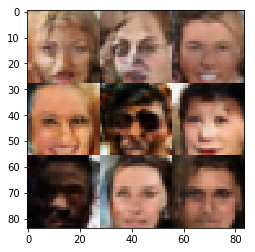

Epoch 4/5: steps 1410 Discriminator Loss: 1.2995... Generator Loss: 0.9458
Epoch 4/5: steps 1420 Discriminator Loss: 1.1405... Generator Loss: 0.8751
Epoch 4/5: steps 1430 Discriminator Loss: 1.1785... Generator Loss: 0.8363
Epoch 4/5: steps 1440 Discriminator Loss: 1.2211... Generator Loss: 0.9430
Epoch 4/5: steps 1450 Discriminator Loss: 1.3015... Generator Loss: 0.8765
Epoch 4/5: steps 1460 Discriminator Loss: 1.1908... Generator Loss: 0.8770
Epoch 4/5: steps 1470 Discriminator Loss: 1.1881... Generator Loss: 0.7675
Epoch 4/5: steps 1480 Discriminator Loss: 1.1855... Generator Loss: 0.9064
Epoch 4/5: steps 1490 Discriminator Loss: 1.2278... Generator Loss: 0.9461
Epoch 4/5: steps 1500 Discriminator Loss: 1.3049... Generator Loss: 0.7890


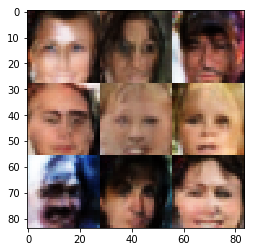

Epoch 4/5: steps 1510 Discriminator Loss: 1.0399... Generator Loss: 0.9114
Epoch 4/5: steps 1520 Discriminator Loss: 1.3346... Generator Loss: 0.8713
Epoch 4/5: steps 1530 Discriminator Loss: 1.2132... Generator Loss: 0.8275
Epoch 4/5: steps 1540 Discriminator Loss: 1.0228... Generator Loss: 1.1396
Epoch 4/5: steps 1550 Discriminator Loss: 1.3334... Generator Loss: 0.8613
Epoch 4/5: steps 1560 Discriminator Loss: 1.1619... Generator Loss: 1.0690
Epoch 4/5: steps 1570 Discriminator Loss: 1.1236... Generator Loss: 0.8514
Epoch 4/5: steps 1580 Discriminator Loss: 1.1164... Generator Loss: 1.0202
Epoch 4/5: steps 1590 Discriminator Loss: 1.3195... Generator Loss: 0.9088
Epoch 4/5: steps 1600 Discriminator Loss: 1.2358... Generator Loss: 0.9289


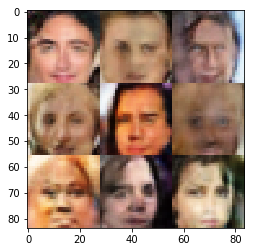

Epoch 4/5: steps 1610 Discriminator Loss: 1.2201... Generator Loss: 0.8768
Epoch 4/5: steps 1620 Discriminator Loss: 1.2980... Generator Loss: 0.7527
Epoch 4/5: steps 1630 Discriminator Loss: 1.1600... Generator Loss: 0.7720
Epoch 4/5: steps 1640 Discriminator Loss: 1.3314... Generator Loss: 0.9717
Epoch 4/5: steps 1650 Discriminator Loss: 1.3633... Generator Loss: 0.7077
Epoch 4/5: steps 1660 Discriminator Loss: 1.3089... Generator Loss: 0.9121
Epoch 4/5: steps 1670 Discriminator Loss: 1.2532... Generator Loss: 0.7800
Epoch 4/5: steps 1680 Discriminator Loss: 1.2205... Generator Loss: 1.0214
Epoch 4/5: steps 1690 Discriminator Loss: 1.2067... Generator Loss: 0.8590
Epoch 4/5: steps 1700 Discriminator Loss: 1.1943... Generator Loss: 0.9253


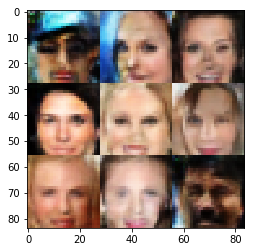

Epoch 4/5: steps 1710 Discriminator Loss: 1.1931... Generator Loss: 0.8540
Epoch 4/5: steps 1720 Discriminator Loss: 1.1756... Generator Loss: 0.8107
Epoch 4/5: steps 1730 Discriminator Loss: 1.2307... Generator Loss: 0.9299
Epoch 4/5: steps 1740 Discriminator Loss: 1.2318... Generator Loss: 0.8286
Epoch 4/5: steps 1750 Discriminator Loss: 1.3546... Generator Loss: 0.9051
Epoch 4/5: steps 1760 Discriminator Loss: 1.1649... Generator Loss: 0.9201
Epoch 4/5: steps 1770 Discriminator Loss: 1.2428... Generator Loss: 0.7639
Epoch 4/5: steps 1780 Discriminator Loss: 1.2985... Generator Loss: 0.8311
Epoch 4/5: steps 1790 Discriminator Loss: 1.2269... Generator Loss: 0.8754
Epoch 4/5: steps 1800 Discriminator Loss: 1.2508... Generator Loss: 0.7958


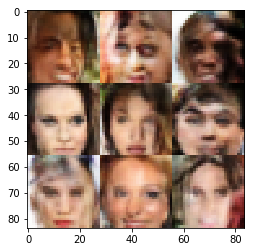

Epoch 4/5: steps 1810 Discriminator Loss: 1.2373... Generator Loss: 0.7933
Epoch 4/5: steps 1820 Discriminator Loss: 1.2738... Generator Loss: 0.8303
Epoch 4/5: steps 1830 Discriminator Loss: 1.1610... Generator Loss: 0.8311
Epoch 4/5: steps 1840 Discriminator Loss: 1.1473... Generator Loss: 0.9764
Epoch 4/5: steps 1850 Discriminator Loss: 1.2226... Generator Loss: 0.9562
Epoch 4/5: steps 1860 Discriminator Loss: 1.2610... Generator Loss: 0.8472
Epoch 4/5: steps 1870 Discriminator Loss: 1.3056... Generator Loss: 0.8623
Epoch 4/5: steps 1880 Discriminator Loss: 1.2169... Generator Loss: 0.8795
Epoch 4/5: steps 1890 Discriminator Loss: 1.1341... Generator Loss: 0.9355
Epoch 4/5: steps 1900 Discriminator Loss: 1.2035... Generator Loss: 0.9893


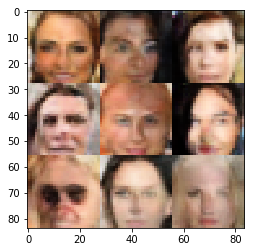

Epoch 4/5: steps 1910 Discriminator Loss: 1.2423... Generator Loss: 1.0340
Epoch 4/5: steps 1920 Discriminator Loss: 1.2470... Generator Loss: 0.7612
Epoch 4/5: steps 1930 Discriminator Loss: 1.2265... Generator Loss: 0.8396
Epoch 4/5: steps 1940 Discriminator Loss: 1.1540... Generator Loss: 0.8220
Epoch 4/5: steps 1950 Discriminator Loss: 1.2638... Generator Loss: 0.8896
Epoch 4/5: steps 1960 Discriminator Loss: 1.2611... Generator Loss: 0.7791
Epoch 4/5: steps 1970 Discriminator Loss: 1.1766... Generator Loss: 0.8385
Epoch 4/5: steps 1980 Discriminator Loss: 1.2117... Generator Loss: 0.8799
Epoch 4/5: steps 1990 Discriminator Loss: 1.2274... Generator Loss: 0.8760
Epoch 4/5: steps 2000 Discriminator Loss: 1.1841... Generator Loss: 0.8749


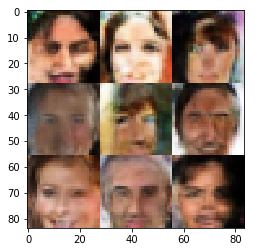

Epoch 4/5: steps 2010 Discriminator Loss: 1.2906... Generator Loss: 0.8948
Epoch 4/5: steps 2020 Discriminator Loss: 1.1849... Generator Loss: 0.8977
Epoch 4/5: steps 2030 Discriminator Loss: 1.1508... Generator Loss: 0.9859
Epoch 4/5: steps 2040 Discriminator Loss: 1.1835... Generator Loss: 0.6929
Epoch 4/5: steps 2050 Discriminator Loss: 1.2320... Generator Loss: 1.0538
Epoch 4/5: steps 2060 Discriminator Loss: 1.2607... Generator Loss: 0.7364
Epoch 4/5: steps 2070 Discriminator Loss: 1.2603... Generator Loss: 0.7485
Epoch 4/5: steps 2080 Discriminator Loss: 1.2284... Generator Loss: 0.9307
Epoch 4/5: steps 2090 Discriminator Loss: 1.2030... Generator Loss: 0.8348
Epoch 4/5: steps 2100 Discriminator Loss: 1.1713... Generator Loss: 0.9754


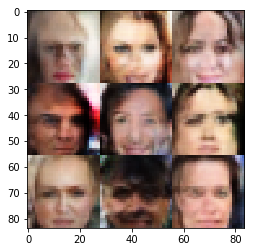

Epoch 4/5: steps 2110 Discriminator Loss: 1.2778... Generator Loss: 0.7881
Epoch 4/5: steps 2120 Discriminator Loss: 1.2086... Generator Loss: 0.9190
Epoch 4/5: steps 2130 Discriminator Loss: 1.2833... Generator Loss: 0.7641
Epoch 4/5: steps 2140 Discriminator Loss: 1.2242... Generator Loss: 0.9494
Epoch 4/5: steps 2150 Discriminator Loss: 1.1660... Generator Loss: 0.8400
Epoch 4/5: steps 2160 Discriminator Loss: 1.1712... Generator Loss: 0.9371
Epoch 4/5: steps 2170 Discriminator Loss: 1.1544... Generator Loss: 0.9447
Epoch 4/5: steps 2180 Discriminator Loss: 1.1667... Generator Loss: 1.0562
Epoch 4/5: steps 2190 Discriminator Loss: 1.2729... Generator Loss: 0.8766
Epoch 4/5: steps 2200 Discriminator Loss: 1.2159... Generator Loss: 0.8370


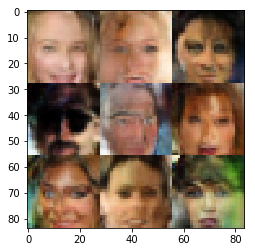

Epoch 4/5: steps 2210 Discriminator Loss: 1.3539... Generator Loss: 0.9144
Epoch 4/5: steps 2220 Discriminator Loss: 1.1911... Generator Loss: 1.0012
Epoch 4/5: steps 2230 Discriminator Loss: 1.1896... Generator Loss: 0.8849
Epoch 4/5: steps 2240 Discriminator Loss: 1.2410... Generator Loss: 0.8520
Epoch 4/5: steps 2250 Discriminator Loss: 1.1714... Generator Loss: 0.7987
Epoch 4/5: steps 2260 Discriminator Loss: 1.2661... Generator Loss: 0.8151
Epoch 4/5: steps 2270 Discriminator Loss: 1.2622... Generator Loss: 0.9205
Epoch 4/5: steps 2280 Discriminator Loss: 1.1783... Generator Loss: 1.1115
Epoch 4/5: steps 2290 Discriminator Loss: 1.3264... Generator Loss: 0.8723
Epoch 4/5: steps 2300 Discriminator Loss: 1.1942... Generator Loss: 1.1061


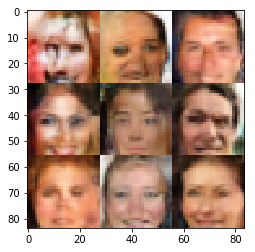

Epoch 4/5: steps 2310 Discriminator Loss: 1.1709... Generator Loss: 0.8895
Epoch 4/5: steps 2320 Discriminator Loss: 1.2148... Generator Loss: 0.8099
Epoch 4/5: steps 2330 Discriminator Loss: 1.1220... Generator Loss: 0.9236
Epoch 4/5: steps 2340 Discriminator Loss: 1.2523... Generator Loss: 0.8172
Epoch 4/5: steps 2350 Discriminator Loss: 1.1836... Generator Loss: 0.8279
Epoch 4/5: steps 2360 Discriminator Loss: 1.1571... Generator Loss: 0.8635
Epoch 4/5: steps 2370 Discriminator Loss: 1.2437... Generator Loss: 0.7756
Epoch 4/5: steps 2380 Discriminator Loss: 1.2809... Generator Loss: 1.0439
Epoch 4/5: steps 2390 Discriminator Loss: 1.1947... Generator Loss: 0.8218
Epoch 4/5: steps 2400 Discriminator Loss: 1.1322... Generator Loss: 0.9081


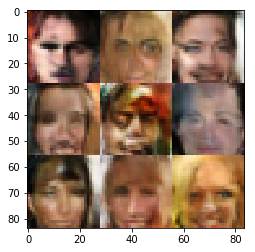

Epoch 4/5: steps 2410 Discriminator Loss: 1.1981... Generator Loss: 1.0141
Epoch 4/5: steps 2420 Discriminator Loss: 1.2268... Generator Loss: 0.7609
Epoch 4/5: steps 2430 Discriminator Loss: 1.1421... Generator Loss: 0.8649
Epoch 4/5: steps 2440 Discriminator Loss: 1.2736... Generator Loss: 0.8753
Epoch 4/5: steps 2450 Discriminator Loss: 1.1893... Generator Loss: 0.8606
Epoch 4/5: steps 2460 Discriminator Loss: 1.2254... Generator Loss: 0.8722
Epoch 4/5: steps 2470 Discriminator Loss: 1.2709... Generator Loss: 0.9255
Epoch 4/5: steps 2480 Discriminator Loss: 1.1976... Generator Loss: 0.8410
Epoch 4/5: steps 2490 Discriminator Loss: 1.1818... Generator Loss: 0.8224
Epoch 4/5: steps 2500 Discriminator Loss: 1.3020... Generator Loss: 0.9435


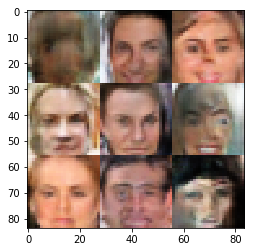

Epoch 4/5: steps 2510 Discriminator Loss: 1.3345... Generator Loss: 0.9411
Epoch 4/5: steps 2520 Discriminator Loss: 1.1711... Generator Loss: 0.9043
Epoch 4/5: steps 2530 Discriminator Loss: 1.2716... Generator Loss: 0.8430
Epoch 4/5: steps 2540 Discriminator Loss: 1.2418... Generator Loss: 0.9343
Epoch 4/5: steps 2550 Discriminator Loss: 1.1810... Generator Loss: 0.7917
Epoch 4/5: steps 2560 Discriminator Loss: 1.3175... Generator Loss: 0.9259
Epoch 4/5: steps 2570 Discriminator Loss: 1.2229... Generator Loss: 0.8525
Epoch 4/5: steps 2580 Discriminator Loss: 1.1818... Generator Loss: 0.9415
Epoch 4/5: steps 2590 Discriminator Loss: 1.1385... Generator Loss: 0.9994
Epoch 4/5: steps 2600 Discriminator Loss: 1.2753... Generator Loss: 0.8052


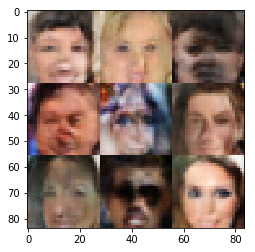

Epoch 4/5: steps 2610 Discriminator Loss: 1.1671... Generator Loss: 0.8368
Epoch 4/5: steps 2620 Discriminator Loss: 1.2314... Generator Loss: 0.8691
Epoch 4/5: steps 2630 Discriminator Loss: 1.1032... Generator Loss: 0.7737
Epoch 4/5: steps 2640 Discriminator Loss: 1.3401... Generator Loss: 0.9250
Epoch 4/5: steps 2650 Discriminator Loss: 1.2090... Generator Loss: 0.7626
Epoch 4/5: steps 2660 Discriminator Loss: 1.2330... Generator Loss: 0.8745
Epoch 4/5: steps 2670 Discriminator Loss: 1.2232... Generator Loss: 0.7345
Epoch 4/5: steps 2680 Discriminator Loss: 1.0794... Generator Loss: 1.0383
Epoch 4/5: steps 2690 Discriminator Loss: 1.2416... Generator Loss: 0.8301
Epoch 4/5: steps 2700 Discriminator Loss: 1.2690... Generator Loss: 0.8239


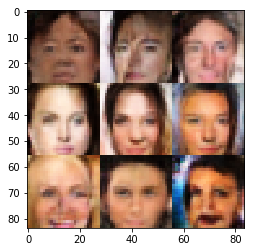

Epoch 4/5: steps 2710 Discriminator Loss: 1.2702... Generator Loss: 0.8333
Epoch 4/5: steps 2720 Discriminator Loss: 1.3177... Generator Loss: 0.7012
Epoch 4/5: steps 2730 Discriminator Loss: 1.2871... Generator Loss: 0.8068
Epoch 4/5: steps 2740 Discriminator Loss: 1.2794... Generator Loss: 0.8665
Epoch 4/5: steps 2750 Discriminator Loss: 1.2188... Generator Loss: 0.8939
Epoch 4/5: steps 2760 Discriminator Loss: 1.3225... Generator Loss: 0.8957
Epoch 4/5: steps 2770 Discriminator Loss: 1.3631... Generator Loss: 0.8912
Epoch 4/5: steps 2780 Discriminator Loss: 1.1839... Generator Loss: 0.7948
Epoch 4/5: steps 2790 Discriminator Loss: 1.3299... Generator Loss: 1.0364
Epoch 4/5: steps 2800 Discriminator Loss: 1.2122... Generator Loss: 0.7650


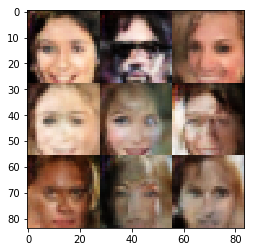

Epoch 4/5: steps 2810 Discriminator Loss: 1.2822... Generator Loss: 0.7172
Epoch 4/5: steps 2820 Discriminator Loss: 1.2914... Generator Loss: 0.7071
Epoch 4/5: steps 2830 Discriminator Loss: 1.2149... Generator Loss: 0.9155
Epoch 4/5: steps 2840 Discriminator Loss: 1.2257... Generator Loss: 0.7672
Epoch 4/5: steps 2850 Discriminator Loss: 1.1649... Generator Loss: 0.8167
Epoch 4/5: steps 2860 Discriminator Loss: 1.1295... Generator Loss: 0.9016
Epoch 4/5: steps 2870 Discriminator Loss: 1.2006... Generator Loss: 0.8154
Epoch 4/5: steps 2880 Discriminator Loss: 1.1942... Generator Loss: 0.8419
Epoch 4/5: steps 2890 Discriminator Loss: 1.2653... Generator Loss: 0.8311
Epoch 4/5: steps 2900 Discriminator Loss: 1.2396... Generator Loss: 0.9171


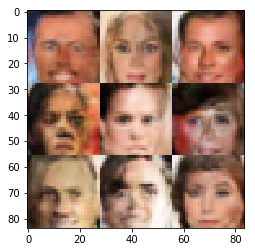

Epoch 4/5: steps 2910 Discriminator Loss: 1.2551... Generator Loss: 0.8552
Epoch 4/5: steps 2920 Discriminator Loss: 1.2229... Generator Loss: 0.8183
Epoch 4/5: steps 2930 Discriminator Loss: 1.2928... Generator Loss: 0.7570
Epoch 4/5: steps 2940 Discriminator Loss: 1.2415... Generator Loss: 0.8468
Epoch 4/5: steps 2950 Discriminator Loss: 1.1998... Generator Loss: 0.9614
Epoch 4/5: steps 2960 Discriminator Loss: 1.1906... Generator Loss: 0.9142
Epoch 4/5: steps 2970 Discriminator Loss: 1.2280... Generator Loss: 0.7553
Epoch 4/5: steps 2980 Discriminator Loss: 1.2892... Generator Loss: 0.8471
Epoch 4/5: steps 2990 Discriminator Loss: 1.2391... Generator Loss: 0.7333
Epoch 4/5: steps 3000 Discriminator Loss: 1.3978... Generator Loss: 0.8571


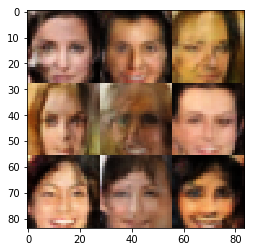

Epoch 4/5: steps 3010 Discriminator Loss: 1.2360... Generator Loss: 0.8407
Epoch 4/5: steps 3020 Discriminator Loss: 1.3186... Generator Loss: 0.7994
Epoch 4/5: steps 3030 Discriminator Loss: 1.2637... Generator Loss: 0.8033
Epoch 4/5: steps 3040 Discriminator Loss: 1.3302... Generator Loss: 0.8964
Epoch 4/5: steps 3050 Discriminator Loss: 1.3331... Generator Loss: 0.6972
Epoch 4/5: steps 3060 Discriminator Loss: 1.2624... Generator Loss: 0.8297
Epoch 4/5: steps 3070 Discriminator Loss: 1.2509... Generator Loss: 0.8964
Epoch 4/5: steps 3080 Discriminator Loss: 1.1805... Generator Loss: 0.8826
Epoch 4/5: steps 3090 Discriminator Loss: 1.2374... Generator Loss: 0.7807
Epoch 4/5: steps 3100 Discriminator Loss: 1.2416... Generator Loss: 0.8235


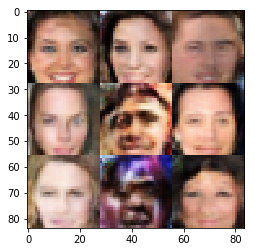

Epoch 4/5: steps 3110 Discriminator Loss: 1.2761... Generator Loss: 0.8778
Epoch 4/5: steps 3120 Discriminator Loss: 1.1735... Generator Loss: 0.7858
Epoch 4/5: steps 3130 Discriminator Loss: 1.2204... Generator Loss: 0.9456
Epoch 4/5: steps 3140 Discriminator Loss: 1.2137... Generator Loss: 0.8639
Epoch 4/5: steps 3150 Discriminator Loss: 1.2134... Generator Loss: 0.7575
Epoch 4/5: steps 3160 Discriminator Loss: 1.2035... Generator Loss: 0.8485
Epoch 5/5: steps 10 Discriminator Loss: 1.2387... Generator Loss: 0.8504
Epoch 5/5: steps 20 Discriminator Loss: 1.0563... Generator Loss: 0.9794
Epoch 5/5: steps 30 Discriminator Loss: 1.1953... Generator Loss: 0.7961
Epoch 5/5: steps 40 Discriminator Loss: 1.1840... Generator Loss: 0.8057
Epoch 5/5: steps 50 Discriminator Loss: 1.1802... Generator Loss: 0.9721
Epoch 5/5: steps 60 Discriminator Loss: 1.2586... Generator Loss: 0.9799
Epoch 5/5: steps 70 Discriminator Loss: 1.2965... Generator Loss: 0.7759
Epoch 5/5: steps 80 Discriminator Loss:

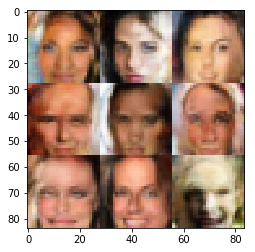

Epoch 5/5: steps 110 Discriminator Loss: 1.3293... Generator Loss: 0.8323
Epoch 5/5: steps 120 Discriminator Loss: 1.2256... Generator Loss: 0.9430
Epoch 5/5: steps 130 Discriminator Loss: 1.2852... Generator Loss: 0.8320
Epoch 5/5: steps 140 Discriminator Loss: 1.2834... Generator Loss: 0.8454
Epoch 5/5: steps 150 Discriminator Loss: 1.2535... Generator Loss: 0.9311
Epoch 5/5: steps 160 Discriminator Loss: 1.1709... Generator Loss: 0.9080
Epoch 5/5: steps 170 Discriminator Loss: 1.2635... Generator Loss: 0.8017
Epoch 5/5: steps 180 Discriminator Loss: 1.1828... Generator Loss: 0.8612
Epoch 5/5: steps 190 Discriminator Loss: 1.3120... Generator Loss: 0.8766
Epoch 5/5: steps 200 Discriminator Loss: 1.2745... Generator Loss: 0.7462


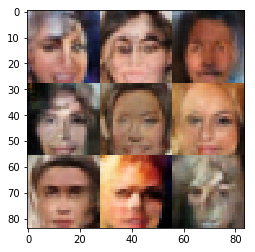

Epoch 5/5: steps 210 Discriminator Loss: 1.2556... Generator Loss: 0.8668
Epoch 5/5: steps 220 Discriminator Loss: 1.3304... Generator Loss: 0.6871
Epoch 5/5: steps 230 Discriminator Loss: 1.2263... Generator Loss: 0.8443
Epoch 5/5: steps 240 Discriminator Loss: 1.2655... Generator Loss: 0.7455
Epoch 5/5: steps 250 Discriminator Loss: 1.2275... Generator Loss: 0.8710
Epoch 5/5: steps 260 Discriminator Loss: 1.2055... Generator Loss: 0.8273
Epoch 5/5: steps 270 Discriminator Loss: 1.1698... Generator Loss: 1.0101
Epoch 5/5: steps 280 Discriminator Loss: 1.1955... Generator Loss: 0.8932
Epoch 5/5: steps 290 Discriminator Loss: 1.2759... Generator Loss: 0.8662
Epoch 5/5: steps 300 Discriminator Loss: 1.2226... Generator Loss: 0.8548


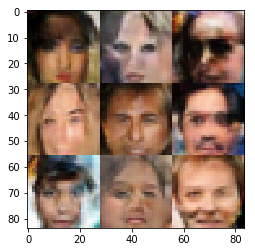

Epoch 5/5: steps 310 Discriminator Loss: 1.1901... Generator Loss: 0.9033
Epoch 5/5: steps 320 Discriminator Loss: 1.2014... Generator Loss: 0.9697
Epoch 5/5: steps 330 Discriminator Loss: 1.4126... Generator Loss: 0.8621
Epoch 5/5: steps 340 Discriminator Loss: 1.1883... Generator Loss: 0.8218
Epoch 5/5: steps 350 Discriminator Loss: 1.3317... Generator Loss: 0.8208
Epoch 5/5: steps 360 Discriminator Loss: 1.2980... Generator Loss: 0.9548
Epoch 5/5: steps 370 Discriminator Loss: 1.3083... Generator Loss: 0.8463
Epoch 5/5: steps 380 Discriminator Loss: 1.2630... Generator Loss: 0.9357
Epoch 5/5: steps 390 Discriminator Loss: 1.1182... Generator Loss: 0.9385
Epoch 5/5: steps 400 Discriminator Loss: 1.3053... Generator Loss: 0.8004


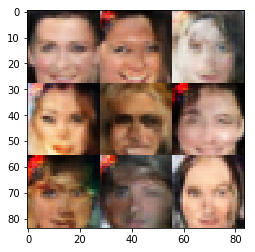

Epoch 5/5: steps 410 Discriminator Loss: 1.2363... Generator Loss: 0.9048
Epoch 5/5: steps 420 Discriminator Loss: 1.3377... Generator Loss: 0.9102
Epoch 5/5: steps 430 Discriminator Loss: 1.2925... Generator Loss: 0.7919
Epoch 5/5: steps 440 Discriminator Loss: 1.2923... Generator Loss: 0.8686
Epoch 5/5: steps 450 Discriminator Loss: 1.2473... Generator Loss: 0.7907
Epoch 5/5: steps 460 Discriminator Loss: 1.2485... Generator Loss: 0.8571
Epoch 5/5: steps 470 Discriminator Loss: 1.2154... Generator Loss: 0.9350
Epoch 5/5: steps 480 Discriminator Loss: 1.2970... Generator Loss: 0.8694
Epoch 5/5: steps 490 Discriminator Loss: 1.2925... Generator Loss: 0.8619
Epoch 5/5: steps 500 Discriminator Loss: 1.2469... Generator Loss: 0.8118


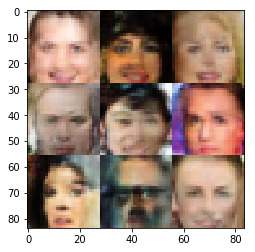

Epoch 5/5: steps 510 Discriminator Loss: 1.3475... Generator Loss: 0.8343
Epoch 5/5: steps 520 Discriminator Loss: 1.2049... Generator Loss: 0.8561
Epoch 5/5: steps 530 Discriminator Loss: 1.2237... Generator Loss: 0.7938
Epoch 5/5: steps 540 Discriminator Loss: 1.3173... Generator Loss: 0.8024
Epoch 5/5: steps 550 Discriminator Loss: 1.2628... Generator Loss: 0.8507
Epoch 5/5: steps 560 Discriminator Loss: 1.1290... Generator Loss: 0.8431
Epoch 5/5: steps 570 Discriminator Loss: 1.3570... Generator Loss: 0.7494
Epoch 5/5: steps 580 Discriminator Loss: 1.3279... Generator Loss: 0.9032
Epoch 5/5: steps 590 Discriminator Loss: 1.2178... Generator Loss: 0.9073
Epoch 5/5: steps 600 Discriminator Loss: 1.2076... Generator Loss: 0.8520


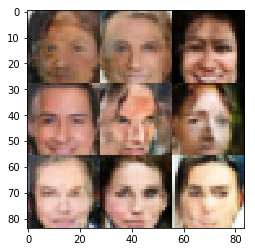

Epoch 5/5: steps 610 Discriminator Loss: 1.2489... Generator Loss: 0.9164
Epoch 5/5: steps 620 Discriminator Loss: 1.2792... Generator Loss: 0.7475
Epoch 5/5: steps 630 Discriminator Loss: 1.2736... Generator Loss: 0.8026
Epoch 5/5: steps 640 Discriminator Loss: 1.2243... Generator Loss: 0.8412
Epoch 5/5: steps 650 Discriminator Loss: 1.2397... Generator Loss: 0.8098
Epoch 5/5: steps 660 Discriminator Loss: 1.2410... Generator Loss: 0.8374
Epoch 5/5: steps 670 Discriminator Loss: 1.2408... Generator Loss: 0.8358
Epoch 5/5: steps 680 Discriminator Loss: 1.2140... Generator Loss: 0.9918
Epoch 5/5: steps 690 Discriminator Loss: 1.1863... Generator Loss: 1.0018
Epoch 5/5: steps 700 Discriminator Loss: 1.2992... Generator Loss: 0.8748


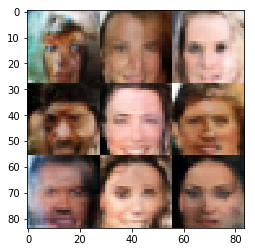

Epoch 5/5: steps 710 Discriminator Loss: 1.2353... Generator Loss: 0.8486
Epoch 5/5: steps 720 Discriminator Loss: 1.2636... Generator Loss: 0.8820
Epoch 5/5: steps 730 Discriminator Loss: 1.3149... Generator Loss: 0.6892
Epoch 5/5: steps 740 Discriminator Loss: 1.2811... Generator Loss: 0.8894
Epoch 5/5: steps 750 Discriminator Loss: 1.1962... Generator Loss: 0.9361
Epoch 5/5: steps 760 Discriminator Loss: 1.2933... Generator Loss: 0.8423
Epoch 5/5: steps 770 Discriminator Loss: 1.2607... Generator Loss: 0.8434
Epoch 5/5: steps 780 Discriminator Loss: 1.2768... Generator Loss: 0.8102
Epoch 5/5: steps 790 Discriminator Loss: 1.3313... Generator Loss: 0.7388
Epoch 5/5: steps 800 Discriminator Loss: 1.3182... Generator Loss: 0.9906


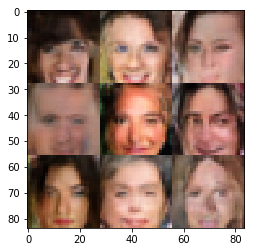

Epoch 5/5: steps 810 Discriminator Loss: 1.2409... Generator Loss: 0.8325
Epoch 5/5: steps 820 Discriminator Loss: 1.2002... Generator Loss: 0.8787
Epoch 5/5: steps 830 Discriminator Loss: 1.2499... Generator Loss: 0.8761
Epoch 5/5: steps 840 Discriminator Loss: 1.3032... Generator Loss: 1.0228
Epoch 5/5: steps 850 Discriminator Loss: 1.1920... Generator Loss: 0.7910
Epoch 5/5: steps 860 Discriminator Loss: 1.2789... Generator Loss: 0.7735
Epoch 5/5: steps 870 Discriminator Loss: 1.1839... Generator Loss: 0.8891
Epoch 5/5: steps 880 Discriminator Loss: 1.2066... Generator Loss: 0.8713
Epoch 5/5: steps 890 Discriminator Loss: 1.3821... Generator Loss: 0.7659
Epoch 5/5: steps 900 Discriminator Loss: 1.1485... Generator Loss: 0.8072


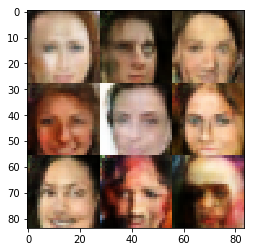

Epoch 5/5: steps 910 Discriminator Loss: 1.2011... Generator Loss: 0.9359
Epoch 5/5: steps 920 Discriminator Loss: 1.2509... Generator Loss: 0.8109
Epoch 5/5: steps 930 Discriminator Loss: 1.2086... Generator Loss: 0.7915
Epoch 5/5: steps 940 Discriminator Loss: 1.2781... Generator Loss: 0.7904
Epoch 5/5: steps 950 Discriminator Loss: 1.2440... Generator Loss: 0.8433
Epoch 5/5: steps 960 Discriminator Loss: 1.1905... Generator Loss: 0.8424
Epoch 5/5: steps 970 Discriminator Loss: 1.3048... Generator Loss: 0.7922
Epoch 5/5: steps 980 Discriminator Loss: 1.2642... Generator Loss: 0.8807
Epoch 5/5: steps 990 Discriminator Loss: 1.3406... Generator Loss: 0.7702
Epoch 5/5: steps 1000 Discriminator Loss: 1.2968... Generator Loss: 0.8084


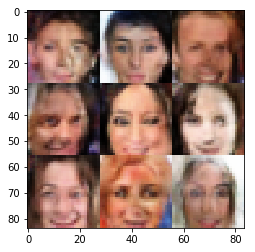

Epoch 5/5: steps 1010 Discriminator Loss: 1.2290... Generator Loss: 0.7910
Epoch 5/5: steps 1020 Discriminator Loss: 1.1247... Generator Loss: 0.9359
Epoch 5/5: steps 1030 Discriminator Loss: 1.2714... Generator Loss: 0.8345
Epoch 5/5: steps 1040 Discriminator Loss: 1.2943... Generator Loss: 0.8131
Epoch 5/5: steps 1050 Discriminator Loss: 1.2976... Generator Loss: 0.8399
Epoch 5/5: steps 1060 Discriminator Loss: 1.2907... Generator Loss: 0.8275
Epoch 5/5: steps 1070 Discriminator Loss: 1.2476... Generator Loss: 0.8991
Epoch 5/5: steps 1080 Discriminator Loss: 1.2366... Generator Loss: 0.8263
Epoch 5/5: steps 1090 Discriminator Loss: 1.3261... Generator Loss: 0.8010
Epoch 5/5: steps 1100 Discriminator Loss: 1.1997... Generator Loss: 0.8319


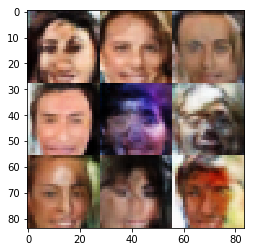

Epoch 5/5: steps 1110 Discriminator Loss: 1.2959... Generator Loss: 0.7552
Epoch 5/5: steps 1120 Discriminator Loss: 1.2408... Generator Loss: 0.8515
Epoch 5/5: steps 1130 Discriminator Loss: 1.3133... Generator Loss: 0.8141
Epoch 5/5: steps 1140 Discriminator Loss: 1.2953... Generator Loss: 0.8873
Epoch 5/5: steps 1150 Discriminator Loss: 1.2690... Generator Loss: 0.9273
Epoch 5/5: steps 1160 Discriminator Loss: 1.3057... Generator Loss: 0.9310
Epoch 5/5: steps 1170 Discriminator Loss: 1.2554... Generator Loss: 0.7609
Epoch 5/5: steps 1180 Discriminator Loss: 1.2984... Generator Loss: 0.7476
Epoch 5/5: steps 1190 Discriminator Loss: 1.2116... Generator Loss: 0.8781
Epoch 5/5: steps 1200 Discriminator Loss: 1.2001... Generator Loss: 1.0048


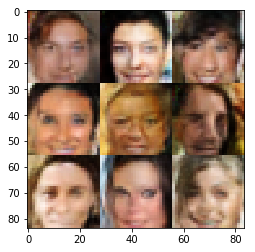

Epoch 5/5: steps 1210 Discriminator Loss: 1.1824... Generator Loss: 0.8867
Epoch 5/5: steps 1220 Discriminator Loss: 1.1831... Generator Loss: 0.9371
Epoch 5/5: steps 1230 Discriminator Loss: 1.2350... Generator Loss: 0.8697
Epoch 5/5: steps 1240 Discriminator Loss: 1.2489... Generator Loss: 0.8597
Epoch 5/5: steps 1250 Discriminator Loss: 1.3222... Generator Loss: 0.8933
Epoch 5/5: steps 1260 Discriminator Loss: 1.3218... Generator Loss: 0.7887
Epoch 5/5: steps 1270 Discriminator Loss: 1.2048... Generator Loss: 0.9058
Epoch 5/5: steps 1280 Discriminator Loss: 1.3435... Generator Loss: 0.8035
Epoch 5/5: steps 1290 Discriminator Loss: 1.2725... Generator Loss: 0.8150
Epoch 5/5: steps 1300 Discriminator Loss: 1.3564... Generator Loss: 0.8841


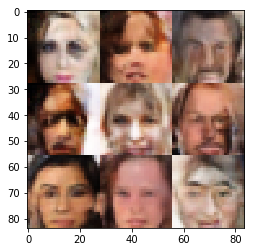

Epoch 5/5: steps 1310 Discriminator Loss: 1.3483... Generator Loss: 0.7987
Epoch 5/5: steps 1320 Discriminator Loss: 1.2783... Generator Loss: 1.0231
Epoch 5/5: steps 1330 Discriminator Loss: 1.2015... Generator Loss: 0.8961
Epoch 5/5: steps 1340 Discriminator Loss: 1.3368... Generator Loss: 0.7939
Epoch 5/5: steps 1350 Discriminator Loss: 1.2143... Generator Loss: 0.7735
Epoch 5/5: steps 1360 Discriminator Loss: 1.3205... Generator Loss: 1.0277
Epoch 5/5: steps 1370 Discriminator Loss: 1.3439... Generator Loss: 0.8768
Epoch 5/5: steps 1380 Discriminator Loss: 1.2625... Generator Loss: 0.7949
Epoch 5/5: steps 1390 Discriminator Loss: 1.1865... Generator Loss: 0.7990
Epoch 5/5: steps 1400 Discriminator Loss: 1.2515... Generator Loss: 0.8589


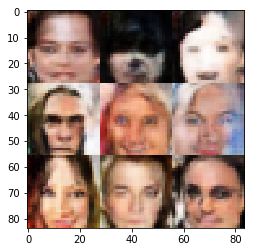

Epoch 5/5: steps 1410 Discriminator Loss: 1.3024... Generator Loss: 0.8059
Epoch 5/5: steps 1420 Discriminator Loss: 1.3236... Generator Loss: 0.8182
Epoch 5/5: steps 1430 Discriminator Loss: 1.2999... Generator Loss: 0.7875
Epoch 5/5: steps 1440 Discriminator Loss: 1.3236... Generator Loss: 0.8343
Epoch 5/5: steps 1450 Discriminator Loss: 1.2148... Generator Loss: 0.9418
Epoch 5/5: steps 1460 Discriminator Loss: 1.2845... Generator Loss: 0.8105
Epoch 5/5: steps 1470 Discriminator Loss: 1.2522... Generator Loss: 0.7611
Epoch 5/5: steps 1480 Discriminator Loss: 1.1997... Generator Loss: 0.8308
Epoch 5/5: steps 1490 Discriminator Loss: 1.3233... Generator Loss: 0.8422
Epoch 5/5: steps 1500 Discriminator Loss: 1.2862... Generator Loss: 0.8033


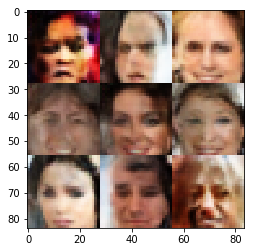

Epoch 5/5: steps 1510 Discriminator Loss: 1.2421... Generator Loss: 0.8326
Epoch 5/5: steps 1520 Discriminator Loss: 1.2225... Generator Loss: 0.9029
Epoch 5/5: steps 1530 Discriminator Loss: 1.2354... Generator Loss: 0.8879
Epoch 5/5: steps 1540 Discriminator Loss: 1.3094... Generator Loss: 1.0017
Epoch 5/5: steps 1550 Discriminator Loss: 1.3761... Generator Loss: 0.8935
Epoch 5/5: steps 1560 Discriminator Loss: 1.2756... Generator Loss: 0.9449
Epoch 5/5: steps 1570 Discriminator Loss: 1.2031... Generator Loss: 0.7649
Epoch 5/5: steps 1580 Discriminator Loss: 1.2583... Generator Loss: 0.7692
Epoch 5/5: steps 1590 Discriminator Loss: 1.2564... Generator Loss: 0.7615
Epoch 5/5: steps 1600 Discriminator Loss: 1.2081... Generator Loss: 0.8346


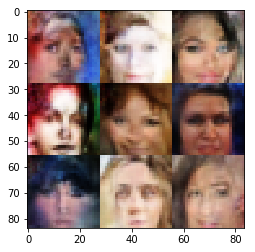

Epoch 5/5: steps 1610 Discriminator Loss: 1.2672... Generator Loss: 0.8893
Epoch 5/5: steps 1620 Discriminator Loss: 1.2680... Generator Loss: 0.8753
Epoch 5/5: steps 1630 Discriminator Loss: 1.3189... Generator Loss: 0.8385
Epoch 5/5: steps 1640 Discriminator Loss: 1.2666... Generator Loss: 0.8304
Epoch 5/5: steps 1650 Discriminator Loss: 1.2404... Generator Loss: 0.8038
Epoch 5/5: steps 1660 Discriminator Loss: 1.3354... Generator Loss: 0.9302
Epoch 5/5: steps 1670 Discriminator Loss: 1.2408... Generator Loss: 0.8488
Epoch 5/5: steps 1680 Discriminator Loss: 1.2940... Generator Loss: 0.7738
Epoch 5/5: steps 1690 Discriminator Loss: 1.2379... Generator Loss: 0.8724
Epoch 5/5: steps 1700 Discriminator Loss: 1.2346... Generator Loss: 0.8135


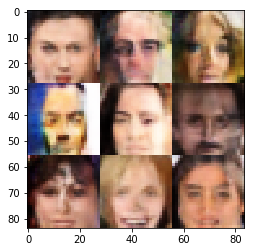

Epoch 5/5: steps 1710 Discriminator Loss: 1.2312... Generator Loss: 0.9301
Epoch 5/5: steps 1720 Discriminator Loss: 1.2151... Generator Loss: 0.8558
Epoch 5/5: steps 1730 Discriminator Loss: 1.2146... Generator Loss: 0.8440
Epoch 5/5: steps 1740 Discriminator Loss: 1.3369... Generator Loss: 0.7900
Epoch 5/5: steps 1750 Discriminator Loss: 1.2640... Generator Loss: 0.7974
Epoch 5/5: steps 1760 Discriminator Loss: 1.2449... Generator Loss: 0.9209
Epoch 5/5: steps 1770 Discriminator Loss: 1.1730... Generator Loss: 0.7265
Epoch 5/5: steps 1780 Discriminator Loss: 1.3543... Generator Loss: 0.8019
Epoch 5/5: steps 1790 Discriminator Loss: 1.2515... Generator Loss: 0.7860
Epoch 5/5: steps 1800 Discriminator Loss: 1.3380... Generator Loss: 0.8995


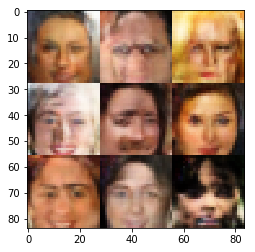

Epoch 5/5: steps 1810 Discriminator Loss: 1.2652... Generator Loss: 0.8014
Epoch 5/5: steps 1820 Discriminator Loss: 1.2527... Generator Loss: 0.7476
Epoch 5/5: steps 1830 Discriminator Loss: 1.1533... Generator Loss: 0.8209
Epoch 5/5: steps 1840 Discriminator Loss: 1.2602... Generator Loss: 0.8133
Epoch 5/5: steps 1850 Discriminator Loss: 1.1874... Generator Loss: 0.8410
Epoch 5/5: steps 1860 Discriminator Loss: 1.2920... Generator Loss: 0.7321
Epoch 5/5: steps 1870 Discriminator Loss: 1.2916... Generator Loss: 0.8098
Epoch 5/5: steps 1880 Discriminator Loss: 1.2583... Generator Loss: 0.8001
Epoch 5/5: steps 1890 Discriminator Loss: 1.2503... Generator Loss: 0.8932
Epoch 5/5: steps 1900 Discriminator Loss: 1.2880... Generator Loss: 0.8714


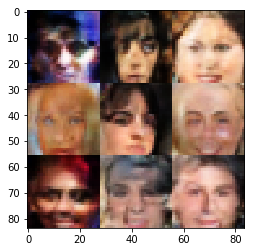

Epoch 5/5: steps 1910 Discriminator Loss: 1.2736... Generator Loss: 0.8351
Epoch 5/5: steps 1920 Discriminator Loss: 1.3171... Generator Loss: 0.8543
Epoch 5/5: steps 1930 Discriminator Loss: 1.2347... Generator Loss: 0.8005
Epoch 5/5: steps 1940 Discriminator Loss: 1.2754... Generator Loss: 0.8741
Epoch 5/5: steps 1950 Discriminator Loss: 1.2918... Generator Loss: 0.7896
Epoch 5/5: steps 1960 Discriminator Loss: 1.2623... Generator Loss: 0.8101
Epoch 5/5: steps 1970 Discriminator Loss: 1.2138... Generator Loss: 0.8832
Epoch 5/5: steps 1980 Discriminator Loss: 1.2220... Generator Loss: 0.7669
Epoch 5/5: steps 1990 Discriminator Loss: 1.2065... Generator Loss: 0.8931
Epoch 5/5: steps 2000 Discriminator Loss: 1.2230... Generator Loss: 0.8193


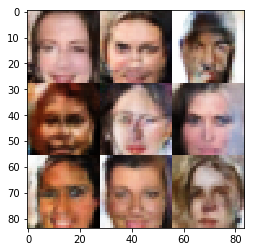

Epoch 5/5: steps 2010 Discriminator Loss: 1.2003... Generator Loss: 0.9030
Epoch 5/5: steps 2020 Discriminator Loss: 1.3480... Generator Loss: 0.8050
Epoch 5/5: steps 2030 Discriminator Loss: 1.1766... Generator Loss: 0.8440
Epoch 5/5: steps 2040 Discriminator Loss: 1.2873... Generator Loss: 0.8141
Epoch 5/5: steps 2050 Discriminator Loss: 1.2233... Generator Loss: 0.8807
Epoch 5/5: steps 2060 Discriminator Loss: 1.2299... Generator Loss: 0.8722
Epoch 5/5: steps 2070 Discriminator Loss: 1.3051... Generator Loss: 0.8981
Epoch 5/5: steps 2080 Discriminator Loss: 1.1994... Generator Loss: 0.8258
Epoch 5/5: steps 2090 Discriminator Loss: 1.1723... Generator Loss: 0.8065
Epoch 5/5: steps 2100 Discriminator Loss: 1.2240... Generator Loss: 0.7806


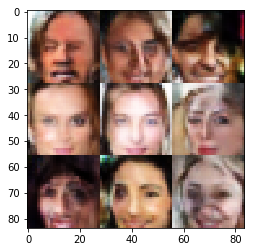

Epoch 5/5: steps 2110 Discriminator Loss: 1.2218... Generator Loss: 0.8823
Epoch 5/5: steps 2120 Discriminator Loss: 1.2842... Generator Loss: 0.7304
Epoch 5/5: steps 2130 Discriminator Loss: 1.3379... Generator Loss: 0.8884
Epoch 5/5: steps 2140 Discriminator Loss: 1.2679... Generator Loss: 0.8161
Epoch 5/5: steps 2150 Discriminator Loss: 1.1894... Generator Loss: 0.8844
Epoch 5/5: steps 2160 Discriminator Loss: 1.2864... Generator Loss: 0.8943
Epoch 5/5: steps 2170 Discriminator Loss: 1.1655... Generator Loss: 0.9262
Epoch 5/5: steps 2180 Discriminator Loss: 1.1849... Generator Loss: 1.0414
Epoch 5/5: steps 2190 Discriminator Loss: 1.2017... Generator Loss: 0.9664
Epoch 5/5: steps 2200 Discriminator Loss: 1.3422... Generator Loss: 0.7801


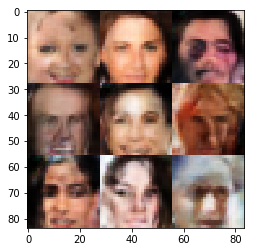

Epoch 5/5: steps 2210 Discriminator Loss: 1.1587... Generator Loss: 0.7848
Epoch 5/5: steps 2220 Discriminator Loss: 1.3389... Generator Loss: 0.9032
Epoch 5/5: steps 2230 Discriminator Loss: 1.2417... Generator Loss: 0.7283
Epoch 5/5: steps 2240 Discriminator Loss: 1.2292... Generator Loss: 0.7419
Epoch 5/5: steps 2250 Discriminator Loss: 1.2320... Generator Loss: 0.8047
Epoch 5/5: steps 2260 Discriminator Loss: 1.2835... Generator Loss: 0.7885
Epoch 5/5: steps 2270 Discriminator Loss: 1.1922... Generator Loss: 0.8882
Epoch 5/5: steps 2280 Discriminator Loss: 1.2853... Generator Loss: 0.8875
Epoch 5/5: steps 2290 Discriminator Loss: 1.2697... Generator Loss: 0.7753
Epoch 5/5: steps 2300 Discriminator Loss: 1.2379... Generator Loss: 0.8155


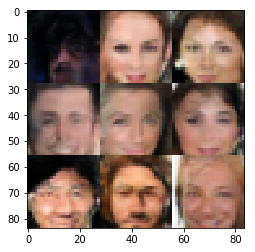

Epoch 5/5: steps 2310 Discriminator Loss: 1.2802... Generator Loss: 0.7753
Epoch 5/5: steps 2320 Discriminator Loss: 1.2958... Generator Loss: 0.8306
Epoch 5/5: steps 2330 Discriminator Loss: 1.2673... Generator Loss: 0.9220
Epoch 5/5: steps 2340 Discriminator Loss: 1.2699... Generator Loss: 0.7999
Epoch 5/5: steps 2350 Discriminator Loss: 1.2312... Generator Loss: 0.7555
Epoch 5/5: steps 2360 Discriminator Loss: 1.1186... Generator Loss: 0.8781
Epoch 5/5: steps 2370 Discriminator Loss: 1.2265... Generator Loss: 0.7659
Epoch 5/5: steps 2380 Discriminator Loss: 1.3353... Generator Loss: 0.8512
Epoch 5/5: steps 2390 Discriminator Loss: 1.3053... Generator Loss: 0.8733
Epoch 5/5: steps 2400 Discriminator Loss: 1.1566... Generator Loss: 0.8465


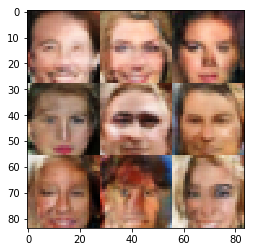

Epoch 5/5: steps 2410 Discriminator Loss: 1.2491... Generator Loss: 0.9140
Epoch 5/5: steps 2420 Discriminator Loss: 1.2911... Generator Loss: 0.7821
Epoch 5/5: steps 2430 Discriminator Loss: 1.2513... Generator Loss: 0.7686
Epoch 5/5: steps 2440 Discriminator Loss: 1.2637... Generator Loss: 0.8193
Epoch 5/5: steps 2450 Discriminator Loss: 1.2709... Generator Loss: 0.8311
Epoch 5/5: steps 2460 Discriminator Loss: 1.3026... Generator Loss: 0.8837
Epoch 5/5: steps 2470 Discriminator Loss: 1.1826... Generator Loss: 0.7793
Epoch 5/5: steps 2480 Discriminator Loss: 1.2028... Generator Loss: 0.9382
Epoch 5/5: steps 2490 Discriminator Loss: 1.2665... Generator Loss: 0.8479
Epoch 5/5: steps 2500 Discriminator Loss: 1.3138... Generator Loss: 0.8159


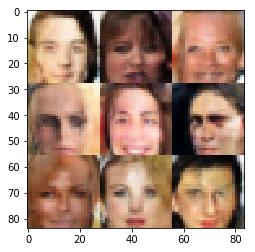

Epoch 5/5: steps 2510 Discriminator Loss: 1.2120... Generator Loss: 0.7802
Epoch 5/5: steps 2520 Discriminator Loss: 1.1927... Generator Loss: 0.7935
Epoch 5/5: steps 2530 Discriminator Loss: 1.2185... Generator Loss: 0.8532
Epoch 5/5: steps 2540 Discriminator Loss: 1.2211... Generator Loss: 0.9653
Epoch 5/5: steps 2550 Discriminator Loss: 1.1974... Generator Loss: 0.9718
Epoch 5/5: steps 2560 Discriminator Loss: 1.2954... Generator Loss: 0.7135
Epoch 5/5: steps 2570 Discriminator Loss: 1.2366... Generator Loss: 0.9337
Epoch 5/5: steps 2580 Discriminator Loss: 1.2737... Generator Loss: 0.6627
Epoch 5/5: steps 2590 Discriminator Loss: 1.2743... Generator Loss: 0.8301
Epoch 5/5: steps 2600 Discriminator Loss: 1.2920... Generator Loss: 0.8704


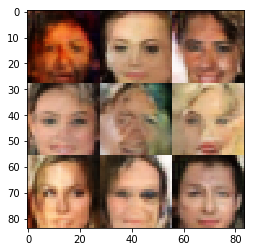

Epoch 5/5: steps 2610 Discriminator Loss: 1.2389... Generator Loss: 0.8284
Epoch 5/5: steps 2620 Discriminator Loss: 1.3791... Generator Loss: 0.8421
Epoch 5/5: steps 2630 Discriminator Loss: 1.2367... Generator Loss: 0.7096
Epoch 5/5: steps 2640 Discriminator Loss: 1.2381... Generator Loss: 0.7645
Epoch 5/5: steps 2650 Discriminator Loss: 1.1665... Generator Loss: 0.8408
Epoch 5/5: steps 2660 Discriminator Loss: 1.2864... Generator Loss: 0.8882
Epoch 5/5: steps 2670 Discriminator Loss: 1.2525... Generator Loss: 0.7916
Epoch 5/5: steps 2680 Discriminator Loss: 1.2213... Generator Loss: 0.8585
Epoch 5/5: steps 2690 Discriminator Loss: 1.3064... Generator Loss: 0.7914
Epoch 5/5: steps 2700 Discriminator Loss: 1.3328... Generator Loss: 0.9519


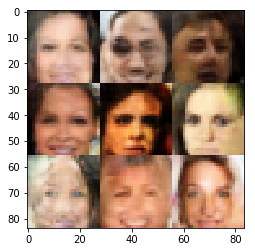

Epoch 5/5: steps 2710 Discriminator Loss: 1.2313... Generator Loss: 0.8762
Epoch 5/5: steps 2720 Discriminator Loss: 1.3194... Generator Loss: 0.6515
Epoch 5/5: steps 2730 Discriminator Loss: 1.3312... Generator Loss: 0.8960
Epoch 5/5: steps 2740 Discriminator Loss: 1.1492... Generator Loss: 0.8921
Epoch 5/5: steps 2750 Discriminator Loss: 1.1828... Generator Loss: 1.0069
Epoch 5/5: steps 2760 Discriminator Loss: 1.2651... Generator Loss: 0.7855
Epoch 5/5: steps 2770 Discriminator Loss: 1.2705... Generator Loss: 0.7496
Epoch 5/5: steps 2780 Discriminator Loss: 1.2289... Generator Loss: 0.7489
Epoch 5/5: steps 2790 Discriminator Loss: 1.2493... Generator Loss: 0.7192
Epoch 5/5: steps 2800 Discriminator Loss: 1.2080... Generator Loss: 0.8579


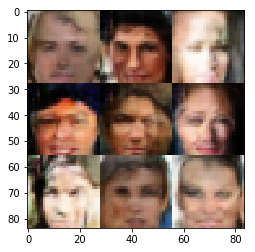

Epoch 5/5: steps 2810 Discriminator Loss: 1.2994... Generator Loss: 0.7967
Epoch 5/5: steps 2820 Discriminator Loss: 1.3402... Generator Loss: 0.8120
Epoch 5/5: steps 2830 Discriminator Loss: 1.3705... Generator Loss: 0.8465
Epoch 5/5: steps 2840 Discriminator Loss: 1.2790... Generator Loss: 0.8538
Epoch 5/5: steps 2850 Discriminator Loss: 1.1929... Generator Loss: 0.7849
Epoch 5/5: steps 2860 Discriminator Loss: 1.2188... Generator Loss: 0.9683
Epoch 5/5: steps 2870 Discriminator Loss: 1.2608... Generator Loss: 0.8488
Epoch 5/5: steps 2880 Discriminator Loss: 1.2252... Generator Loss: 0.7942
Epoch 5/5: steps 2890 Discriminator Loss: 1.2312... Generator Loss: 0.7999
Epoch 5/5: steps 2900 Discriminator Loss: 1.2553... Generator Loss: 0.8016


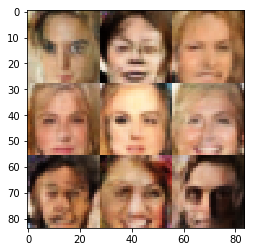

Epoch 5/5: steps 2910 Discriminator Loss: 1.2959... Generator Loss: 0.8622
Epoch 5/5: steps 2920 Discriminator Loss: 1.2687... Generator Loss: 0.7583
Epoch 5/5: steps 2930 Discriminator Loss: 1.2993... Generator Loss: 0.7165
Epoch 5/5: steps 2940 Discriminator Loss: 1.2542... Generator Loss: 0.7762
Epoch 5/5: steps 2950 Discriminator Loss: 1.2370... Generator Loss: 0.7281
Epoch 5/5: steps 2960 Discriminator Loss: 1.2496... Generator Loss: 0.8692
Epoch 5/5: steps 2970 Discriminator Loss: 1.2163... Generator Loss: 0.8229
Epoch 5/5: steps 2980 Discriminator Loss: 1.2383... Generator Loss: 0.8246
Epoch 5/5: steps 2990 Discriminator Loss: 1.2582... Generator Loss: 0.8115
Epoch 5/5: steps 3000 Discriminator Loss: 1.2820... Generator Loss: 0.8374


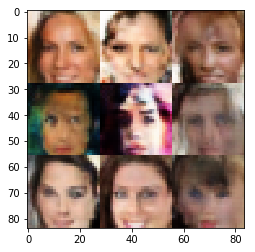

Epoch 5/5: steps 3010 Discriminator Loss: 1.3977... Generator Loss: 0.6979
Epoch 5/5: steps 3020 Discriminator Loss: 1.2175... Generator Loss: 0.7732
Epoch 5/5: steps 3030 Discriminator Loss: 1.2392... Generator Loss: 0.9160
Epoch 5/5: steps 3040 Discriminator Loss: 1.2995... Generator Loss: 0.9068
Epoch 5/5: steps 3050 Discriminator Loss: 1.2533... Generator Loss: 0.8163
Epoch 5/5: steps 3060 Discriminator Loss: 1.2588... Generator Loss: 0.8472
Epoch 5/5: steps 3070 Discriminator Loss: 1.2821... Generator Loss: 0.7237
Epoch 5/5: steps 3080 Discriminator Loss: 1.2410... Generator Loss: 0.8805
Epoch 5/5: steps 3090 Discriminator Loss: 1.2508... Generator Loss: 0.7943
Epoch 5/5: steps 3100 Discriminator Loss: 1.2649... Generator Loss: 0.7699


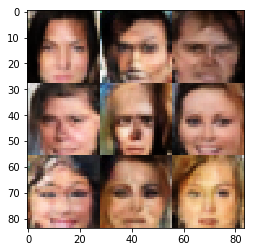

Epoch 5/5: steps 3110 Discriminator Loss: 1.2785... Generator Loss: 0.7435
Epoch 5/5: steps 3120 Discriminator Loss: 1.1741... Generator Loss: 0.8145
Epoch 5/5: steps 3130 Discriminator Loss: 1.2824... Generator Loss: 0.8262
Epoch 5/5: steps 3140 Discriminator Loss: 1.2282... Generator Loss: 0.8088
Epoch 5/5: steps 3150 Discriminator Loss: 1.3663... Generator Loss: 0.8152
Epoch 5/5: steps 3160 Discriminator Loss: 1.2372... Generator Loss: 0.8812


In [86]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.